# INSTALL

In [1]:
# !pip install -q faiss-cpu sentence-transformers transformers torch torchvision accelerate safetensors networkx

# IMPORTS

In [2]:
import os
import json
import torch
import faiss
import pickle
import warnings
import numpy as np
import igraph as ig
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from dataclasses import dataclass
from collections import defaultdict, deque
from sentence_transformers import SentenceTransformer
from transformers import (
    CLIPProcessor, CLIPModel,
    AutoTokenizer, AutoModelForCausalLM
)
warnings.filterwarnings('ignore')


/home/jay/miniconda3/envs/adl_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# CONSTANTS & CONFIG


In [3]:
@dataclass
class Config:
    DATASET_PATH: str = '/storage32Tb/jay/mixtralModel/ADL Project/Dataset'
    DATABASE_JSON: str = f'{DATASET_PATH}/database.json'
    TRAIN_CSV: str = f'{DATASET_PATH}/train_set.csv'
    TEST_CSV: str = f'{DATASET_PATH}/test_public.csv'
    IMAGE_DIR: str = f'{DATASET_PATH}/database_images_compressed90'

    PRECOMPUTED_PATH: str = '/storage32Tb/jay/mixtralModel/ADL Project/eventa_embeddings_Qwen3'
    EMBEDDINGS_FILE: str = f'{PRECOMPUTED_PATH}/database_embeddings_Qwen3.npy'
    ARTICLE_IDS_FILE: str = f'{PRECOMPUTED_PATH}/database_article_ids_Qwen3.npy'
    FAISS_INDEX_FILE: str = f'{PRECOMPUTED_PATH}/database_faiss_index_Qwen3.bin'

    GRAPH_PATH: str = '/storage32Tb/jay/mixtralModel/ADL Project/temporal_graphs_output/graph_temporal.pkl'
    NODE_MAPPING_PATH: str = '/storage32Tb/jay/mixtralModel/ADL Project/temporal_graphs_output/node_mapping_temporal.json'

    EMBEDDING_MODEL: str = 'Qwen/Qwen3-Embedding-0.6B'
    CLIP_MODEL: str = "openai/clip-vit-large-patch14"

    DEVICE: str = 'cuda' if torch.cuda.is_available() else 'cpu'

    EMBEDDING_BATCH_SIZE: int = 64
    RERANK_BATCH_SIZE: int = 64
    IMG_BATCH: int = 32

    TOP_K_ARTICLES: int = 100
    TOP_K_ARTICLES_RERANK: int = 20
    TOP_K_IMAGES: int = 10

    TOP_K_IMAGES_FAISS: int = 20

    MAX_RERANKER_LENGTH: int = 4096
    MAX_DOC_CHARS: int = 2000
    MAX_CLIP_TOKENS: int = 75

    GRAPH_HOPS: int = 5
    MAX_GRAPH_CANDIDATES: int = 200

    GRAPH_EXPANSION_MODE: str = "weighted_hops"
    PER_NODE_TOPK: int = 20

    TRAIN_VAL_SPLIT: float = 0.999
    RANDOM_SEED: int = 42

config = Config()
print("Device:", config.DEVICE)

Device: cuda


# UTILITY FUNCTIONS

In [4]:
def load_json(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        return json.load(f)

def train_val_split(df, split_ratio=0.9, seed=42):
    train = df.sample(frac=split_ratio, random_state=seed)
    val = df.drop(train.index)
    return train.reset_index(drop=True), val.reset_index(drop=True)

def normalize_embeddings(E):
    E = E.astype(np.float32)
    faiss.normalize_L2(E)
    return E

def load_graph(graph_path, node_map_path):
    with open(graph_path, 'rb') as f:
        g = pickle.load(f)

    with open(node_map_path, 'r', encoding='utf-8') as f:
        node_map = json.load(f)

    edge_list = g.get('edge_list', [])

    adj = defaultdict(set)

    adj_w = defaultdict(dict)

    for a, b, w in edge_list:
        a_i = int(a)
        b_i = int(b)
        w_f = float(w)
        adj[a_i].add(b_i)
        adj[b_i].add(a_i)

        prev = adj_w[a_i].get(b_i, None)
        if prev is None or w_f > prev:
            adj_w[a_i][b_i] = w_f
        prev = adj_w[b_i].get(a_i, None)
        if prev is None or w_f > prev:
            adj_w[b_i][a_i] = w_f

    if "sorted_index_to_article_id" in node_map:
        node_map = node_map["sorted_index_to_article_id"]

    idx_to_aid = {int(k): v for k, v in node_map.items()}
    aid_to_idx = {v: int(k) for k, v in node_map.items()}

    return adj, adj_w, idx_to_aid, aid_to_idx

def expand_candidates_via_graph(
    seed_article_ids,
    graph_adj,
    aid_to_idx,
    idx_to_aid,
    graph_weights=None,
    mode="bfs",
    hops=1,
    max_candidates=200,
    topk_per_node=None
):
    if topk_per_node is None:
        topk_per_node = config.PER_NODE_TOPK

    seed_idxs = []
    for aid in seed_article_ids:
        if aid in aid_to_idx:
            seed_idxs.append(aid_to_idx[aid])

    if not seed_idxs:
        return []

    if mode == "bfs" or graph_weights is None:
        visited = set(seed_idxs)
        q = deque([(s, 0) for s in seed_idxs])
        while q:
            node, d = q.popleft()
            if d >= hops:
                continue
            for nbr in graph_adj.get(node, []):
                if nbr not in visited:
                    visited.add(nbr)
                    q.append((nbr, d+1))
                if len(visited) >= max_candidates:
                    break
            if len(visited) >= max_candidates:
                break

        result = []
        for idx in seed_idxs:
            if idx in visited:
                result.append(idx_to_aid[idx])
        for idx in visited:
            aid = idx_to_aid[idx]
            if aid not in result:
                result.append(aid)
            if len(result) >= max_candidates:
                break
        return result[:max_candidates]

    if mode == "weighted_topk":
        score = defaultdict(float)
        for s in seed_idxs:
            nbrs = graph_weights.get(s, {})
            for nbr, w in nbrs.items():
                if nbr in seed_idxs:
                    continue
                score[nbr] += float(w)

        ranked = sorted(score.items(), key=lambda x: x[1], reverse=True)
        selected = [idx for idx, _ in ranked][:max_candidates]

        result = []
        for idx in seed_idxs:
            if idx not in result:
                result.append(idx_to_aid[idx])
        for idx in selected:
            aid = idx_to_aid.get(idx)
            if aid is None:
                continue
            if aid not in result:
                result.append(aid)
            if len(result) >= max_candidates:
                break
        return result[:max_candidates]

    if mode == "weighted_hops":
        visited = set(seed_idxs)
        q = deque([(s, 0) for s in seed_idxs])
        while q:
            node, d = q.popleft()
            if d >= hops:
                continue

            nbr_w = graph_weights.get(node, None)
            if nbr_w:
                nbr_candidates = sorted(nbr_w.items(), key=lambda x: x[1], reverse=True)
                nbr_candidates = [n for n, _ in nbr_candidates[:topk_per_node]]
            else:
                nbr_candidates = list(graph_adj.get(node, []))

            for nbr in nbr_candidates:
                if nbr not in visited:
                    visited.add(nbr)
                    q.append((nbr, d+1))
                if len(visited) >= max_candidates:
                    break
            if len(visited) >= max_candidates:
                break

        result = []
        for idx in seed_idxs:
            if idx in visited:
                result.append(idx_to_aid[idx])
        for idx in visited:
            aid = idx_to_aid[idx]
            if aid not in result:
                result.append(aid)
            if len(result) >= max_candidates:
                break
        return result[:max_candidates]

    return expand_candidates_via_graph(seed_article_ids, graph_adj, aid_to_idx, idx_to_aid,
                                       graph_weights=None, mode="bfs", hops=hops, max_candidates=max_candidates)



# METRIC FUNCTIONS

In [5]:
def compute_recall_at_k(pred, gt, k):
    hit = sum(1 for p, g in zip(pred, gt) if g in p[:k])
    return hit / len(gt)

def compute_mrr(pred, gt):
    s = []
    for p, g in zip(pred, gt):
        s.append(1/(p.index(g)+1) if g in p else 0)
    return sum(s)/len(gt)

def compute_map(pred, gt):
    s = []
    for p, g in zip(pred, gt):
        s.append(1/(p.index(g)+1) if g in p else 0)
    return sum(s)/len(gt)

def evaluate_retrieval(pred, gt, name):
    print(f"\n{name} Metrics:")
    metrics = {
        "mAP": compute_map(pred, gt),
        "MRR": compute_mrr(pred, gt),
        "Recall@1": compute_recall_at_k(pred, gt, 1),
        "Recall@5": compute_recall_at_k(pred, gt, 5),
        "Recall@10": compute_recall_at_k(pred, gt, 10),
        "Recall@20": compute_recall_at_k(pred, gt, 20),
        "Recall@50": compute_recall_at_k(pred, gt, 50),
    }
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    return metrics


# DATALOADER/DATASET

In [6]:
database = load_json(config.DATABASE_JSON)
train_df = pd.read_csv(config.TRAIN_CSV)
train_df, val_df = train_val_split(train_df, config.TRAIN_VAL_SPLIT, config.RANDOM_SEED)

article_image_map = defaultdict(list)
for aid, data in database.items():
    imgs = data.get("images", []) or []
    for img in imgs:
        if isinstance(img, str):
            iid = os.path.splitext(os.path.basename(img))[0]
            article_image_map[aid].append(iid)
            continue
        if isinstance(img, dict):
            for key in ["image_id","id","file_name","filename","path","file"]:
                if key in img:
                    iid = os.path.splitext(os.path.basename(img[key]))[0]
                    article_image_map[aid].append(iid)
                    break

print("Train:", len(train_df), "Val:", len(val_df))

Train: 22018 Val: 22


# ARCHITECTURE

## EMBEDDING & FAISS

In [7]:
def load_embedding_model():
    m = SentenceTransformer(config.EMBEDDING_MODEL, device=config.DEVICE, trust_remote_code=True)
    if config.DEVICE == 'cuda':
        m.half()
    return m

def generate_embeddings(model, texts, batch=64):
    out = []
    for i in tqdm(range(0, len(texts), batch)):
        b = model.encode(texts[i:i+batch], convert_to_numpy=True)
        out.append(b)
    return np.vstack(out)

def search_index(index, Q, k):
    Q = normalize_embeddings(Q)
    dist, idx = index.search(Q, k)
    return dist, idx

## QWEN3 RERANKER

In [8]:
def rerank_articles_graph_only(article_ids, graph_adj_w, aid_to_idx, idx_to_aid):
    scores = {}
    for aid in article_ids:
        if aid not in aid_to_idx:
            continue
        idx = aid_to_idx[aid]
        for nbr, w in graph_adj_w[idx].items():
            aid_nbr = idx_to_aid[nbr]
            scores[aid_nbr] = scores.get(aid_nbr, 0) + w
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return [aid for aid, _ in ranked][:config.TOP_K_ARTICLES_RERANK]


## IMAGE RERANKER

In [9]:
clip_model = CLIPModel.from_pretrained(config.CLIP_MODEL).to(config.DEVICE).eval()
clip_processor = CLIPProcessor.from_pretrained(config.CLIP_MODEL)

def path_for(img_id):
    if "." not in img_id:
        return os.path.join(config.IMAGE_DIR, f"{img_id}.jpg")
    return os.path.join(config.IMAGE_DIR, img_id)

@torch.no_grad()
def rerank_images_clip(query, image_ids, top_k):
    text_inputs = clip_processor.tokenizer(
        query,
        truncation=True,
        max_length=config.MAX_CLIP_TOKENS,
        return_tensors="pt",
    )
    query = clip_processor.tokenizer.decode(text_inputs["input_ids"][0], skip_special_tokens=True)
    images = []
    valid = []
    for iid in image_ids:
        p = path_for(iid)
        try:
            images.append(Image.open(p).convert("RGB"))
            valid.append(iid)
        except:
            pass
    if not images:
        return ["#"] * top_k
    text_inputs = clip_processor(text=[query], return_tensors="pt").to(config.DEVICE)
    text_emb = clip_model.get_text_features(**text_inputs)
    all_embs = []
    for i in range(0, len(images), config.IMG_BATCH):
        batch_imgs = images[i:i+config.IMG_BATCH]
        inputs = clip_processor(images=batch_imgs, return_tensors="pt", padding=True).to(config.DEVICE)
        img_feats = clip_model.get_image_features(**inputs)
        all_embs.append(img_feats)
    img_emb = torch.cat(all_embs, dim=0)
    text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)
    img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)
    sims = (img_emb @ text_emb.T).squeeze(-1).cpu().numpy()
    ranked = sorted(zip(valid, sims), key=lambda x: x[1], reverse=True)
    return [iid for iid, _ in ranked[:top_k]]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


# LOAD PRECOMPUTED

In [10]:
database_embeddings = np.load(config.EMBEDDINGS_FILE, mmap_mode='r')
database_article_ids = np.load(config.ARTICLE_IDS_FILE, allow_pickle=True).tolist()
faiss_index = faiss.read_index(config.FAISS_INDEX_FILE, faiss.IO_FLAG_MMAP)
embedding_model = load_embedding_model()

graph_adj, graph_adj_weighted, idx_to_aid, aid_to_idx = load_graph(
    config.GRAPH_PATH,
    config.NODE_MAPPING_PATH
)

# INFERENCE - VALIDATION

In [11]:
val_queries = val_df['caption'].tolist()
val_gt_articles = val_df['retrieved_article_id'].astype(str).tolist()
val_gt_images = val_df['retrieved_image_id'].astype(str).tolist()

Q = generate_embeddings(embedding_model, val_queries, config.EMBEDDING_BATCH_SIZE)
Q = normalize_embeddings(Q)

_, idx = search_index(faiss_index, Q, config.TOP_K_ARTICLES)
candidates = [[database_article_ids[i] for i in row] for row in idx]

reranked_articles = []
for i in tqdm(range(0, len(val_queries), config.RERANK_BATCH_SIZE)):
    batch_queries = val_queries[i:i+config.RERANK_BATCH_SIZE]
    batch_candidates = candidates[i:i+config.RERANK_BATCH_SIZE]
    batch_results = []
    for q, c in zip(batch_queries, batch_candidates):
        expanded = expand_candidates_via_graph(
            c,
            graph_adj,
            aid_to_idx,
            idx_to_aid,
            graph_weights=graph_adj_weighted,
            mode=config.GRAPH_EXPANSION_MODE,
            hops=config.GRAPH_HOPS,
            max_candidates=config.MAX_GRAPH_CANDIDATES,
            topk_per_node=config.PER_NODE_TOPK
        )
        batch_results.append(rerank_articles_graph_only(expanded, graph_adj_weighted, aid_to_idx, idx_to_aid))
    reranked_articles.extend(batch_results)

final_images = []
for q, arts in tqdm(zip(val_queries, reranked_articles), total=len(val_queries)):
    imgs = []
    for a in arts:
        imgs.extend(article_image_map.get(a, []))
    final_images.append(rerank_images_clip(q, imgs, config.TOP_K_IMAGES))

article_metrics = evaluate_retrieval(reranked_articles, val_gt_articles, "Article Retrieval")
image_metrics = evaluate_retrieval(final_images, val_gt_images, "Image Retrieval")

baseline_top1 = [c[0] for c in candidates]
graph_top1 = [r[0] for r in reranked_articles]
agree = [1 if a==b else 0 for a,b in zip(baseline_top1, graph_top1)]

plt.scatter(range(len(agree)), agree, alpha=0.5)
plt.title("Top-1 Agreement: Baseline vs Graph")
plt.savefig("scatter_top1_baseline_vs_graph.png", dpi=150)
plt.close()

neighbor_counts = []
for c in candidates:
    exp = expand_candidates_via_graph(
        c,
        graph_adj,
        aid_to_idx,
        idx_to_aid,
        graph_weights=graph_adj_weighted,
        mode=config.GRAPH_EXPANSION_MODE,
        hops=config.GRAPH_HOPS,
        max_candidates=config.MAX_GRAPH_CANDIDATES,
        topk_per_node=config.PER_NODE_TOPK
    )
    neighbor_counts.append(len(set(exp) - set(c)))

plt.hist(neighbor_counts, bins=40)
plt.title("Graph Neighbor Expansion Counts")
plt.savefig("graph_neighbor_overlap.png", dpi=150)
plt.close()

qual = []
for idx in np.random.choice(len(val_queries), 5, replace=False):
    qual.append({
        "query": val_queries[idx],
        "baseline_top5": candidates[idx][:5],
        "graph_top5": reranked_articles[idx][:5]
    })

pd.DataFrame(qual).to_csv("qualitative_graph_comparison.csv", index=False)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  5%|▍         | 1/22 [00:02<00:48,  2.31s/it]

  9%|▉         | 2/22 [00:04<00:41,  2.08s/it]

 14%|█▎        | 3/22 [00:15<01:58,  6.24s/it]

 18%|█▊        | 4/22 [00:16<01:18,  4.37s/it]

 23%|██▎       | 5/22 [00:18<00:58,  3.47s/it]

 27%|██▋       | 6/22 [00:20<00:48,  3.03s/it]

 32%|███▏      | 7/22 [00:23<00:41,  2.80s/it]

 36%|███▋      | 8/22 [00:24<00:31,  2.28s/it]

 41%|████      | 9/22 [00:27<00:32,  2.51s/it]

 45%|████▌     | 10/22 [00:29<00:28,  2.33s/it]

 50%|█████     | 11/22 [00:30<00:22,  2.03s/it]

 55%|█████▍    | 12/22 [00:32<00:19,  1.96s/it]

 59%|█████▉    | 13/22 [00:34<00:17,  1.91s/it]

 64%|██████▎   | 14/22 [00:39<00:23,  2.94s/it]

 68%|██████▊   | 15/22 [00:41<00:18,  2.62s/it]

 73%|███████▎  | 16/22 [00:43<00:14,  2.46s/it]

 77%|███████▋  | 17/22 [00:46<00:13,  2.67s/it]

 82%|████████▏ | 18/22 [00:48<00:09,  2.31s/it]

 86%|████████▋ | 19/22 [00:49<00:06,  2.05s/it]

 91%|█████████ | 20/22 [00:51<00:03,  1.94s/it]

 95%|█████████▌| 21/22 [00:52<00:01,  1.59s/it]

100%|██████████| 22/22 [00:53<00:00,  1.52s/it]

100%|██████████| 22/22 [00:53<00:00,  2.43s/it]


Article Retrieval Metrics:
mAP: 0.0000
MRR: 0.0000
Recall@1: 0.0000
Recall@5: 0.0000
Recall@10: 0.0000
Recall@20: 0.0000
Recall@50: 0.0000

Image Retrieval Metrics:
mAP: 0.0000
MRR: 0.0000
Recall@1: 0.0000
Recall@5: 0.0000
Recall@10: 0.0000
Recall@20: 0.0000
Recall@50: 0.0000


# VISUALIZATION

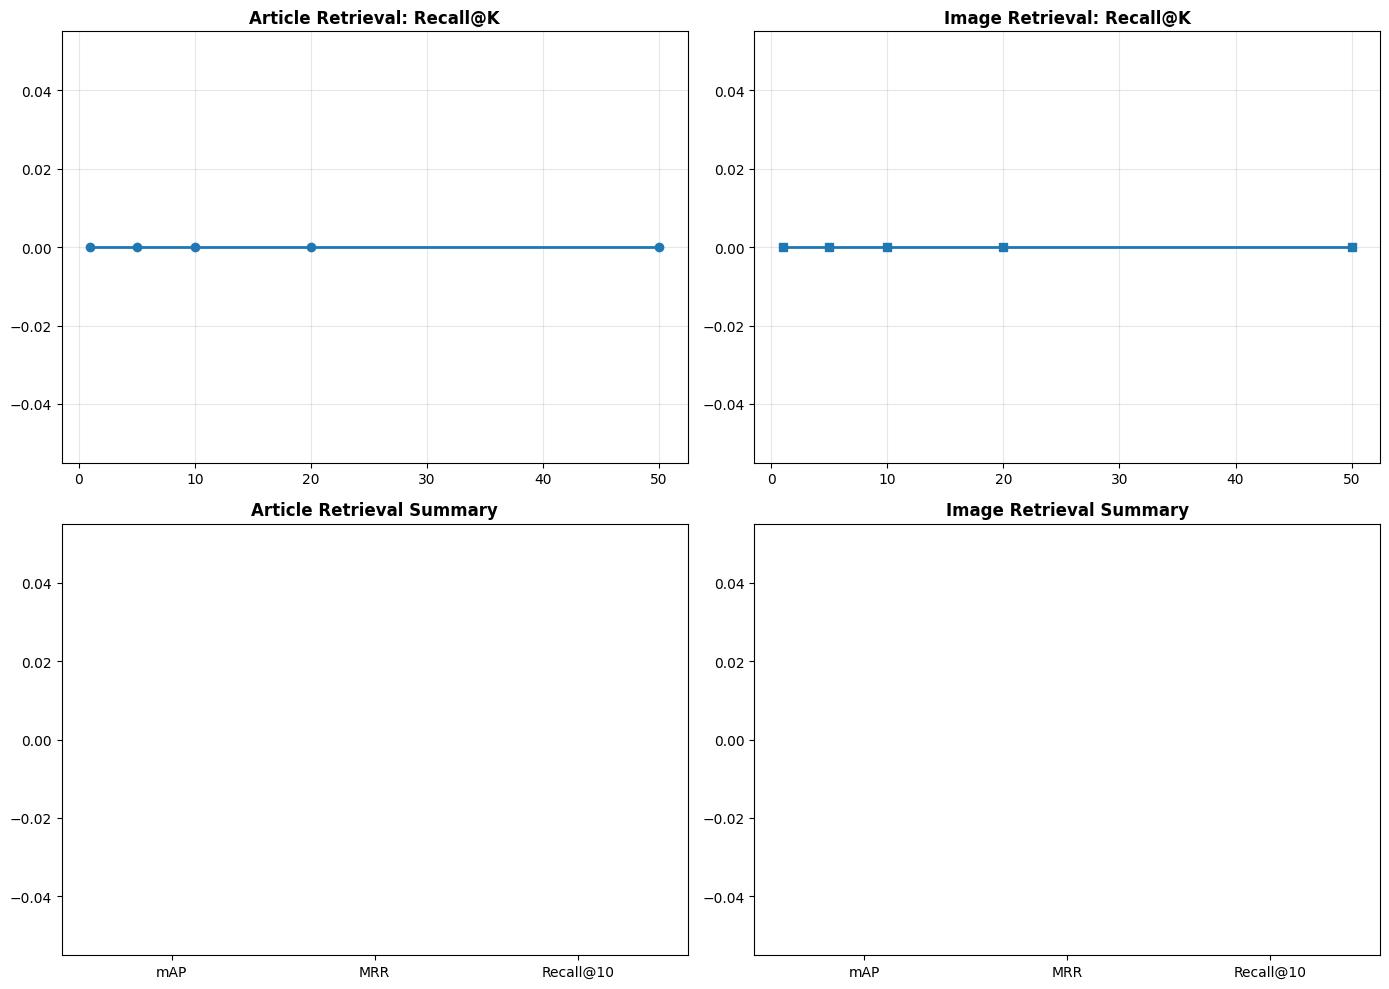

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
k_vals = [1, 5, 10, 20, 50]
article_recalls = [article_metrics[f"Recall@{k}"] for k in k_vals]
axes[0, 0].plot(k_vals, article_recalls, marker='o', linewidth=2)
axes[0, 0].set_title("Article Retrieval: Recall@K", fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

image_recalls = [image_metrics[f"Recall@{k}"] for k in k_vals]
axes[0, 1].plot(k_vals, image_recalls, marker='s', linewidth=2)
axes[0, 1].set_title("Image Retrieval: Recall@K", fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

article_summary_keys = ["mAP", "MRR", "Recall@10"]
article_summary_vals = [article_metrics[k] for k in article_summary_keys]
axes[1, 0].bar(article_summary_keys, article_summary_vals, alpha=0.7)
axes[1, 0].set_title("Article Retrieval Summary", fontsize=12, fontweight='bold')

image_summary_keys = ["mAP", "MRR", "Recall@10"]
image_summary_vals = [image_metrics[k] for k in image_summary_keys]
axes[1, 1].bar(image_summary_keys, image_summary_vals, alpha=0.7)
axes[1, 1].set_title("Image Retrieval Summary", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig("qwen3_results.png", dpi=150)
plt.show()


# TEST INFERENCE & SUBMISSION

In [13]:
test_df = pd.read_csv(config.TEST_CSV)
test_queries = test_df['query_text'].tolist()
test_ids = test_df['query_index'].tolist()

Q = generate_embeddings(embedding_model, test_queries, batch=config.EMBEDDING_BATCH_SIZE)
Q = normalize_embeddings(Q)
_, idx = search_index(faiss_index, Q, config.TOP_K_ARTICLES)
test_candidates = [[database_article_ids[i] for i in row] for row in idx]

test_articles = []
for i in tqdm(range(0, len(test_queries), config.RERANK_BATCH_SIZE)):
    batch_queries = test_queries[i:i+config.RERANK_BATCH_SIZE]
    batch_candidates = test_candidates[i:i+config.RERANK_BATCH_SIZE]
    batch_results = []
    for q, c in zip(batch_queries, batch_candidates):
        expanded = expand_candidates_via_graph(
            c,
            graph_adj,
            aid_to_idx,
            idx_to_aid,
            graph_weights=graph_adj_weighted,
            mode=config.GRAPH_EXPANSION_MODE,
            hops=config.GRAPH_HOPS,
            max_candidates=config.MAX_GRAPH_CANDIDATES,
            topk_per_node=config.PER_NODE_TOPK
        )
        batch_results.append(rerank_articles_graph_only(expanded, graph_adj_weighted, aid_to_idx, idx_to_aid))
    test_articles.extend(batch_results)

test_images = []
for q, arts in tqdm(zip(test_queries, test_articles), total=len(test_queries)):
    imgs = []
    for a in arts:
        imgs.extend(article_image_map.get(a, []))
    test_images.append(rerank_images_clip(q, imgs, config.TOP_K_IMAGES))

rows = []
for qid, imgs in zip(test_ids, test_images):
    rows.append([qid] + imgs + ["#"]*(config.TOP_K_IMAGES-len(imgs)))

sub = pd.DataFrame(rows, columns=["query_id"]+[f"image_id_{i+1}" for i in range(config.TOP_K_IMAGES)])
sub.to_csv("submission.csv", index=False)
print("Saved submission.csv")


  0%|          | 0/47 [00:00<?, ?it/s]

  2%|▏         | 1/47 [00:01<00:49,  1.08s/it]

  4%|▍         | 2/47 [00:01<00:39,  1.14it/s]

  6%|▋         | 3/47 [00:02<00:44,  1.01s/it]

  9%|▊         | 4/47 [00:04<00:47,  1.11s/it]

 11%|█         | 5/47 [00:05<00:41,  1.00it/s]

 13%|█▎        | 6/47 [00:06<00:41,  1.00s/it]

 15%|█▍        | 7/47 [00:07<00:39,  1.01it/s]

 17%|█▋        | 8/47 [00:07<00:37,  1.03it/s]

 19%|█▉        | 9/47 [00:09<00:38,  1.02s/it]

 21%|██▏       | 10/47 [00:10<00:43,  1.16s/it]

 23%|██▎       | 11/47 [00:11<00:39,  1.08s/it]

 26%|██▌       | 12/47 [00:12<00:40,  1.16s/it]

 28%|██▊       | 13/47 [00:14<00:40,  1.21s/it]

 30%|██▉       | 14/47 [00:15<00:37,  1.15s/it]

 32%|███▏      | 15/47 [00:15<00:33,  1.04s/it]

 34%|███▍      | 16/47 [00:16<00:29,  1.05it/s]

 36%|███▌      | 17/47 [00:17<00:27,  1.11it/s]

 38%|███▊      | 18/47 [00:18<00:25,  1.13it/s]

 40%|████      | 19/47 [00:19<00:27,  1.01it/s]

 43%|████▎     | 20/47 [00:20<00:27,  1.01s/it]

 45%|████▍     | 21/47 [00:21<00:25,  1.01it/s]

 47%|████▋     | 22/47 [00:22<00:27,  1.10s/it]

 49%|████▉     | 23/47 [00:23<00:26,  1.10s/it]

 51%|█████     | 24/47 [00:25<00:30,  1.32s/it]

 53%|█████▎    | 25/47 [00:27<00:28,  1.28s/it]

 55%|█████▌    | 26/47 [00:27<00:23,  1.13s/it]

 57%|█████▋    | 27/47 [00:29<00:24,  1.24s/it]

 60%|█████▉    | 28/47 [00:30<00:24,  1.27s/it]

 62%|██████▏   | 29/47 [00:32<00:24,  1.34s/it]

 64%|██████▍   | 30/47 [00:33<00:23,  1.36s/it]

 66%|██████▌   | 31/47 [00:34<00:20,  1.29s/it]

 68%|██████▊   | 32/47 [00:35<00:17,  1.15s/it]

 70%|███████   | 33/47 [00:36<00:16,  1.17s/it]

 72%|███████▏  | 34/47 [00:38<00:16,  1.28s/it]

 74%|███████▍  | 35/47 [00:39<00:13,  1.17s/it]

 77%|███████▋  | 36/47 [00:40<00:13,  1.18s/it]

 79%|███████▊  | 37/47 [00:41<00:13,  1.32s/it]

 81%|████████  | 38/47 [00:43<00:11,  1.31s/it]

 83%|████████▎ | 39/47 [00:44<00:10,  1.31s/it]

 85%|████████▌ | 40/47 [00:45<00:09,  1.33s/it]

 87%|████████▋ | 41/47 [00:47<00:08,  1.48s/it]

 89%|████████▉ | 42/47 [00:49<00:07,  1.49s/it]

 91%|█████████▏| 43/47 [00:51<00:06,  1.59s/it]

 94%|█████████▎| 44/47 [00:52<00:04,  1.65s/it]

 96%|█████████▌| 45/47 [00:54<00:03,  1.58s/it]

 98%|█████████▊| 46/47 [00:55<00:01,  1.46s/it]

100%|██████████| 47/47 [00:56<00:00,  1.38s/it]

100%|██████████| 47/47 [00:56<00:00,  1.21s/it]

  0%|          | 0/47 [00:00<?, ?it/s]

  2%|▏         | 1/47 [00:01<00:54,  1.19s/it]

  4%|▍         | 2/47 [00:02<00:47,  1.05s/it]

  6%|▋         | 3/47 [00:02<00:38,  1.13it/s]

  9%|▊         | 4/47 [00:03<00:34,  1.24it/s]

 11%|█         | 5/47 [00:04<00:31,  1.32it/s]

 13%|█▎        | 6/47 [00:05<00:31,  1.29it/s]

 15%|█▍        | 7/47 [00:05<00:29,  1.35it/s]

 17%|█▋        | 8/47 [00:06<00:26,  1.47it/s]

 19%|█▉        | 9/47 [00:06<00:26,  1.45it/s]

 21%|██▏       | 10/47 [00:07<00:23,  1.56it/s]

 23%|██▎       | 11/47 [00:08<00:22,  1.61it/s]

 26%|██▌       | 12/47 [00:08<00:21,  1.61it/s]

 28%|██▊       | 13/47 [00:09<00:20,  1.68it/s]

 30%|██▉       | 14/47 [00:09<00:19,  1.72it/s]

 32%|███▏      | 15/47 [00:10<00:20,  1.57it/s]

 34%|███▍      | 16/47 [00:11<00:20,  1.54it/s]

 36%|███▌      | 17/47 [00:13<00:31,  1.05s/it]

 38%|███▊      | 18/47 [00:13<00:27,  1.05it/s]

 40%|████      | 19/47 [00:14<00:24,  1.13it/s]

 43%|████▎     | 20/47 [00:15<00:22,  1.21it/s]

 45%|████▍     | 21/47 [00:16<00:20,  1.25it/s]

 47%|████▋     | 22/47 [00:16<00:19,  1.25it/s]

 49%|████▉     | 23/47 [00:17<00:18,  1.32it/s]

 51%|█████     | 24/47 [00:18<00:17,  1.33it/s]

 53%|█████▎    | 25/47 [00:18<00:15,  1.38it/s]

 55%|█████▌    | 26/47 [00:19<00:14,  1.47it/s]

 57%|█████▋    | 27/47 [00:20<00:13,  1.50it/s]

 60%|█████▉    | 28/47 [00:20<00:12,  1.54it/s]

 62%|██████▏   | 29/47 [00:21<00:12,  1.40it/s]

 64%|██████▍   | 30/47 [00:22<00:14,  1.19it/s]

 66%|██████▌   | 31/47 [00:23<00:13,  1.19it/s]

 68%|██████▊   | 32/47 [00:24<00:12,  1.17it/s]

 70%|███████   | 33/47 [00:25<00:11,  1.19it/s]

 72%|███████▏  | 34/47 [00:26<00:11,  1.18it/s]

 74%|███████▍  | 35/47 [00:26<00:09,  1.25it/s]

 77%|███████▋  | 36/47 [00:27<00:08,  1.32it/s]

 79%|███████▊  | 37/47 [00:28<00:07,  1.38it/s]

 81%|████████  | 38/47 [00:28<00:06,  1.34it/s]

 83%|████████▎ | 39/47 [00:29<00:05,  1.37it/s]

 85%|████████▌ | 40/47 [00:30<00:04,  1.40it/s]

 87%|████████▋ | 41/47 [00:31<00:04,  1.39it/s]

 89%|████████▉ | 42/47 [00:31<00:03,  1.41it/s]

 91%|█████████▏| 43/47 [00:32<00:02,  1.39it/s]

 94%|█████████▎| 44/47 [00:33<00:02,  1.43it/s]

 96%|█████████▌| 45/47 [00:33<00:01,  1.46it/s]

 98%|█████████▊| 46/47 [00:34<00:00,  1.45it/s]

100%|██████████| 47/47 [00:35<00:00,  1.49it/s]

100%|██████████| 47/47 [00:35<00:00,  1.34it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 1/3000 [00:07<6:33:48,  7.88s/it]

  0%|          | 2/3000 [00:10<3:54:55,  4.70s/it]

  0%|          | 3/3000 [00:13<3:16:14,  3.93s/it]

  0%|          | 4/3000 [00:16<2:54:43,  3.50s/it]

  0%|          | 5/3000 [01:23<21:56:03, 26.37s/it]

  0%|          | 6/3000 [02:17<29:57:24, 36.02s/it]

  0%|          | 7/3000 [02:35<24:49:48, 29.87s/it]

  0%|          | 8/3000 [02:36<17:24:56, 20.95s/it]

  0%|          | 9/3000 [02:38<12:29:48, 15.04s/it]

  0%|          | 10/3000 [05:32<53:05:50, 63.93s/it]

  0%|          | 11/3000 [05:33<37:09:13, 44.75s/it]

  0%|          | 12/3000 [05:34<26:03:09, 31.39s/it]

  0%|          | 13/3000 [05:35<18:27:39, 22.25s/it]

  0%|          | 14/3000 [05:45<15:16:07, 18.41s/it]

  0%|          | 15/3000 [05:46<10:54:14, 13.15s/it]

  1%|          | 16/3000 [05:47<8:03:43,  9.73s/it] 

  1%|          | 17/3000 [05:49<5:56:28,  7.17s/it]

  1%|          | 18/3000 [05:49<4:17:59,  5.19s/it]

  1%|          | 19/3000 [05:50<3:13:57,  3.90s/it]

  1%|          | 20/3000 [05:51<2:32:59,  3.08s/it]

  1%|          | 21/3000 [05:59<3:40:32,  4.44s/it]

  1%|          | 22/3000 [06:00<2:54:23,  3.51s/it]

  1%|          | 23/3000 [06:01<2:14:29,  2.71s/it]

  1%|          | 24/3000 [06:02<1:46:12,  2.14s/it]

  1%|          | 25/3000 [06:03<1:26:22,  1.74s/it]

  1%|          | 26/3000 [06:04<1:12:31,  1.46s/it]

  1%|          | 27/3000 [06:05<1:15:49,  1.53s/it]

  1%|          | 28/3000 [06:06<1:05:10,  1.32s/it]

  1%|          | 29/3000 [06:07<59:50,  1.21s/it]  

  1%|          | 30/3000 [06:08<51:11,  1.03s/it]

  1%|          | 31/3000 [06:08<45:29,  1.09it/s]

  1%|          | 32/3000 [06:15<2:04:03,  2.51s/it]

  1%|          | 33/3000 [06:15<1:34:41,  1.91s/it]

  1%|          | 34/3000 [06:16<1:17:34,  1.57s/it]

  1%|          | 35/3000 [06:19<1:48:08,  2.19s/it]

  1%|          | 36/3000 [06:21<1:43:35,  2.10s/it]

  1%|          | 37/3000 [06:24<1:57:43,  2.38s/it]

  1%|▏         | 38/3000 [06:25<1:31:21,  1.85s/it]

  1%|▏         | 39/3000 [06:28<1:50:43,  2.24s/it]

  1%|▏         | 40/3000 [06:29<1:26:20,  1.75s/it]

  1%|▏         | 41/3000 [06:31<1:29:59,  1.82s/it]

  1%|▏         | 42/3000 [06:32<1:18:41,  1.60s/it]

  1%|▏         | 43/3000 [06:34<1:27:39,  1.78s/it]

  1%|▏         | 44/3000 [06:35<1:22:39,  1.68s/it]

  2%|▏         | 45/3000 [06:37<1:14:15,  1.51s/it]

  2%|▏         | 46/3000 [06:38<1:07:29,  1.37s/it]

  2%|▏         | 47/3000 [06:39<1:08:26,  1.39s/it]

  2%|▏         | 48/3000 [06:40<55:11,  1.12s/it]  

  2%|▏         | 49/3000 [06:41<57:14,  1.16s/it]

  2%|▏         | 50/3000 [06:41<49:11,  1.00s/it]

  2%|▏         | 51/3000 [06:42<42:31,  1.16it/s]

  2%|▏         | 52/3000 [06:43<39:18,  1.25it/s]

  2%|▏         | 53/3000 [06:44<41:06,  1.19it/s]

  2%|▏         | 54/3000 [06:49<1:51:02,  2.26s/it]

  2%|▏         | 55/3000 [07:02<4:25:32,  5.41s/it]

  2%|▏         | 56/3000 [07:03<3:15:07,  3.98s/it]

  2%|▏         | 57/3000 [07:04<2:33:36,  3.13s/it]

  2%|▏         | 58/3000 [07:05<2:11:09,  2.67s/it]

  2%|▏         | 59/3000 [07:07<1:50:45,  2.26s/it]

  2%|▏         | 60/3000 [07:12<2:42:53,  3.32s/it]

  2%|▏         | 61/3000 [07:17<3:03:30,  3.75s/it]

  2%|▏         | 62/3000 [07:18<2:22:55,  2.92s/it]

  2%|▏         | 63/3000 [07:19<1:58:11,  2.41s/it]

  2%|▏         | 64/3000 [07:27<3:11:04,  3.90s/it]

  2%|▏         | 65/3000 [07:28<2:26:38,  3.00s/it]

  2%|▏         | 66/3000 [07:33<2:57:57,  3.64s/it]

  2%|▏         | 67/3000 [07:34<2:17:02,  2.80s/it]

  2%|▏         | 68/3000 [07:35<1:50:48,  2.27s/it]

  2%|▏         | 69/3000 [07:37<1:49:22,  2.24s/it]

  2%|▏         | 70/3000 [07:39<1:52:29,  2.30s/it]

  2%|▏         | 71/3000 [11:15<54:04:10, 66.46s/it]

  2%|▏         | 72/3000 [11:17<38:17:23, 47.08s/it]

  2%|▏         | 73/3000 [11:19<27:11:29, 33.44s/it]

  2%|▏         | 74/3000 [11:21<19:27:20, 23.94s/it]

  2%|▎         | 75/3000 [11:22<13:52:18, 17.07s/it]

  3%|▎         | 76/3000 [11:24<10:21:14, 12.75s/it]

  3%|▎         | 77/3000 [11:27<7:59:44,  9.85s/it] 

  3%|▎         | 78/3000 [11:29<5:53:10,  7.25s/it]

  3%|▎         | 79/3000 [11:30<4:19:52,  5.34s/it]

  3%|▎         | 80/3000 [11:31<3:19:17,  4.09s/it]

  3%|▎         | 81/3000 [11:33<2:58:47,  3.68s/it]

  3%|▎         | 82/3000 [11:39<3:20:19,  4.12s/it]

  3%|▎         | 83/3000 [11:41<2:50:31,  3.51s/it]

  3%|▎         | 84/3000 [11:42<2:14:13,  2.76s/it]

  3%|▎         | 85/3000 [11:44<2:01:10,  2.49s/it]

  3%|▎         | 86/3000 [11:46<1:54:23,  2.36s/it]

  3%|▎         | 87/3000 [11:47<1:40:27,  2.07s/it]

  3%|▎         | 88/3000 [11:48<1:26:20,  1.78s/it]

  3%|▎         | 89/3000 [11:58<3:20:22,  4.13s/it]

  3%|▎         | 90/3000 [12:01<3:09:30,  3.91s/it]

  3%|▎         | 91/3000 [12:03<2:34:20,  3.18s/it]

  3%|▎         | 92/3000 [12:05<2:30:35,  3.11s/it]

  3%|▎         | 93/3000 [12:14<3:43:16,  4.61s/it]

  3%|▎         | 94/3000 [12:15<2:50:05,  3.51s/it]

  3%|▎         | 95/3000 [12:16<2:25:27,  3.00s/it]

  3%|▎         | 96/3000 [12:18<2:02:46,  2.54s/it]

  3%|▎         | 97/3000 [12:19<1:39:43,  2.06s/it]

  3%|▎         | 98/3000 [12:20<1:33:18,  1.93s/it]

  3%|▎         | 99/3000 [12:22<1:24:53,  1.76s/it]

  3%|▎         | 100/3000 [12:26<1:55:07,  2.38s/it]

  3%|▎         | 101/3000 [12:28<1:52:38,  2.33s/it]

  3%|▎         | 102/3000 [12:30<1:47:59,  2.24s/it]

  3%|▎         | 103/3000 [12:31<1:33:19,  1.93s/it]

  3%|▎         | 104/3000 [12:35<2:05:04,  2.59s/it]

  4%|▎         | 105/3000 [12:37<1:48:59,  2.26s/it]

  4%|▎         | 106/3000 [12:38<1:32:42,  1.92s/it]

  4%|▎         | 107/3000 [12:40<1:33:21,  1.94s/it]

  4%|▎         | 108/3000 [12:40<1:15:56,  1.58s/it]

  4%|▎         | 109/3000 [12:44<1:43:18,  2.14s/it]

  4%|▎         | 110/3000 [12:45<1:24:53,  1.76s/it]

  4%|▎         | 111/3000 [12:47<1:31:00,  1.89s/it]

  4%|▎         | 112/3000 [12:53<2:31:30,  3.15s/it]

  4%|▍         | 113/3000 [12:54<2:00:49,  2.51s/it]

  4%|▍         | 114/3000 [12:56<1:45:03,  2.18s/it]

  4%|▍         | 115/3000 [12:57<1:32:44,  1.93s/it]

  4%|▍         | 116/3000 [12:58<1:21:38,  1.70s/it]

  4%|▍         | 117/3000 [12:59<1:11:02,  1.48s/it]

  4%|▍         | 118/3000 [13:00<1:04:12,  1.34s/it]

  4%|▍         | 119/3000 [13:03<1:21:16,  1.69s/it]

  4%|▍         | 120/3000 [13:04<1:23:28,  1.74s/it]

  4%|▍         | 121/3000 [13:12<2:52:13,  3.59s/it]

  4%|▍         | 122/3000 [13:13<2:08:07,  2.67s/it]

  4%|▍         | 123/3000 [13:14<1:40:01,  2.09s/it]

  4%|▍         | 124/3000 [13:14<1:17:21,  1.61s/it]

  4%|▍         | 125/3000 [13:22<2:46:39,  3.48s/it]

  4%|▍         | 126/3000 [13:26<2:57:40,  3.71s/it]

  4%|▍         | 127/3000 [13:27<2:15:47,  2.84s/it]

  4%|▍         | 128/3000 [13:30<2:17:53,  2.88s/it]

  4%|▍         | 129/3000 [13:33<2:26:55,  3.07s/it]

  4%|▍         | 130/3000 [13:35<2:03:26,  2.58s/it]

  4%|▍         | 131/3000 [13:38<2:10:06,  2.72s/it]

  4%|▍         | 132/3000 [13:47<3:34:33,  4.49s/it]

  4%|▍         | 133/3000 [13:47<2:43:14,  3.42s/it]

  4%|▍         | 134/3000 [13:48<2:01:28,  2.54s/it]

  4%|▍         | 135/3000 [13:48<1:32:37,  1.94s/it]

  5%|▍         | 136/3000 [13:49<1:17:56,  1.63s/it]

  5%|▍         | 137/3000 [13:50<1:02:24,  1.31s/it]

  5%|▍         | 138/3000 [13:50<50:05,  1.05s/it]  

  5%|▍         | 139/3000 [13:51<50:28,  1.06s/it]

  5%|▍         | 140/3000 [13:52<43:43,  1.09it/s]

  5%|▍         | 141/3000 [13:53<47:03,  1.01it/s]

  5%|▍         | 142/3000 [13:54<48:20,  1.01s/it]

  5%|▍         | 143/3000 [13:59<1:42:32,  2.15s/it]

  5%|▍         | 144/3000 [14:00<1:26:54,  1.83s/it]

  5%|▍         | 145/3000 [14:01<1:15:20,  1.58s/it]

  5%|▍         | 146/3000 [14:02<1:06:22,  1.40s/it]

  5%|▍         | 147/3000 [14:03<57:12,  1.20s/it]  

  5%|▍         | 148/3000 [14:04<50:00,  1.05s/it]

  5%|▍         | 149/3000 [14:04<41:14,  1.15it/s]

  5%|▌         | 150/3000 [14:05<40:21,  1.18it/s]

  5%|▌         | 151/3000 [14:06<43:08,  1.10it/s]

  5%|▌         | 152/3000 [14:07<40:02,  1.19it/s]

  5%|▌         | 153/3000 [14:12<1:43:03,  2.17s/it]

  5%|▌         | 154/3000 [14:17<2:31:20,  3.19s/it]

  5%|▌         | 155/3000 [14:22<2:46:12,  3.51s/it]

  5%|▌         | 156/3000 [14:22<2:07:02,  2.68s/it]

  5%|▌         | 157/3000 [14:27<2:32:44,  3.22s/it]

  5%|▌         | 158/3000 [14:31<2:40:31,  3.39s/it]

  5%|▌         | 159/3000 [14:31<2:00:49,  2.55s/it]

  5%|▌         | 160/3000 [14:35<2:11:19,  2.77s/it]

  5%|▌         | 161/3000 [14:35<1:40:42,  2.13s/it]

  5%|▌         | 162/3000 [14:36<1:20:14,  1.70s/it]

  5%|▌         | 163/3000 [14:39<1:36:19,  2.04s/it]

  5%|▌         | 164/3000 [14:39<1:17:59,  1.65s/it]

  6%|▌         | 165/3000 [14:40<1:05:12,  1.38s/it]

  6%|▌         | 166/3000 [14:41<57:51,  1.22s/it]  

  6%|▌         | 167/3000 [14:42<48:02,  1.02s/it]

  6%|▌         | 168/3000 [14:44<1:07:33,  1.43s/it]

  6%|▌         | 169/3000 [14:45<1:01:16,  1.30s/it]

  6%|▌         | 170/3000 [14:46<59:20,  1.26s/it]  

  6%|▌         | 171/3000 [14:47<50:08,  1.06s/it]

  6%|▌         | 172/3000 [14:47<42:56,  1.10it/s]

  6%|▌         | 173/3000 [14:50<1:03:25,  1.35s/it]

  6%|▌         | 174/3000 [14:50<54:27,  1.16s/it]  

  6%|▌         | 175/3000 [14:52<53:46,  1.14s/it]

  6%|▌         | 176/3000 [15:26<8:43:59, 11.13s/it]

  6%|▌         | 177/3000 [15:27<6:20:58,  8.10s/it]

  6%|▌         | 178/3000 [17:59<40:14:39, 51.34s/it]

  6%|▌         | 179/3000 [20:02<57:01:36, 72.77s/it]

  6%|▌         | 180/3000 [20:55<52:17:18, 66.75s/it]

  6%|▌         | 181/3000 [20:56<36:50:14, 47.04s/it]

  6%|▌         | 182/3000 [21:00<26:51:24, 34.31s/it]

  6%|▌         | 183/3000 [21:05<19:54:34, 25.44s/it]

  6%|▌         | 184/3000 [21:06<14:10:29, 18.12s/it]

  6%|▌         | 185/3000 [21:07<10:03:00, 12.85s/it]

  6%|▌         | 186/3000 [21:07<7:08:12,  9.13s/it] 

  6%|▌         | 187/3000 [22:22<22:38:45, 28.98s/it]

  6%|▋         | 188/3000 [22:24<16:14:59, 20.80s/it]

  6%|▋         | 189/3000 [22:30<12:45:53, 16.35s/it]

  6%|▋         | 190/3000 [22:35<10:04:01, 12.90s/it]

  6%|▋         | 191/3000 [22:37<7:24:48,  9.50s/it] 

  6%|▋         | 192/3000 [23:05<11:53:41, 15.25s/it]

  6%|▋         | 193/3000 [23:06<8:26:36, 10.83s/it] 

  6%|▋         | 194/3000 [23:06<6:04:05,  7.79s/it]

  6%|▋         | 195/3000 [23:07<4:27:38,  5.72s/it]

  7%|▋         | 196/3000 [23:10<3:38:31,  4.68s/it]

  7%|▋         | 197/3000 [23:10<2:40:01,  3.43s/it]

  7%|▋         | 198/3000 [23:13<2:27:44,  3.16s/it]

  7%|▋         | 199/3000 [23:13<1:49:30,  2.35s/it]

  7%|▋         | 200/3000 [23:14<1:24:38,  1.81s/it]

  7%|▋         | 201/3000 [23:14<1:07:58,  1.46s/it]

  7%|▋         | 202/3000 [23:22<2:34:34,  3.31s/it]

  7%|▋         | 203/3000 [23:23<2:03:09,  2.64s/it]

  7%|▋         | 204/3000 [23:24<1:40:33,  2.16s/it]

  7%|▋         | 205/3000 [23:25<1:23:03,  1.78s/it]

  7%|▋         | 206/3000 [23:26<1:08:02,  1.46s/it]

  7%|▋         | 207/3000 [23:30<1:53:50,  2.45s/it]

  7%|▋         | 208/3000 [23:31<1:32:37,  1.99s/it]

  7%|▋         | 209/3000 [23:34<1:42:14,  2.20s/it]

  7%|▋         | 210/3000 [23:36<1:36:10,  2.07s/it]

  7%|▋         | 211/3000 [23:41<2:26:46,  3.16s/it]

  7%|▋         | 212/3000 [23:45<2:36:43,  3.37s/it]

  7%|▋         | 213/3000 [23:46<2:03:29,  2.66s/it]

  7%|▋         | 214/3000 [23:49<2:10:32,  2.81s/it]

  7%|▋         | 215/3000 [23:50<1:41:18,  2.18s/it]

  7%|▋         | 216/3000 [23:57<2:49:58,  3.66s/it]

  7%|▋         | 217/3000 [23:58<2:08:12,  2.76s/it]

  7%|▋         | 218/3000 [24:05<3:06:32,  4.02s/it]

  7%|▋         | 219/3000 [24:11<3:38:02,  4.70s/it]

  7%|▋         | 220/3000 [24:12<2:42:05,  3.50s/it]

  7%|▋         | 221/3000 [24:12<2:00:23,  2.60s/it]

  7%|▋         | 222/3000 [24:13<1:33:49,  2.03s/it]

  7%|▋         | 223/3000 [24:14<1:12:32,  1.57s/it]

  7%|▋         | 224/3000 [24:17<1:39:24,  2.15s/it]

  8%|▊         | 225/3000 [24:18<1:21:01,  1.75s/it]

  8%|▊         | 226/3000 [24:26<2:47:10,  3.62s/it]

  8%|▊         | 227/3000 [25:04<10:49:23, 14.05s/it]

  8%|▊         | 228/3000 [25:54<19:00:09, 24.68s/it]

  8%|▊         | 229/3000 [25:54<13:27:38, 17.49s/it]

  8%|▊         | 230/3000 [25:55<9:32:51, 12.41s/it] 

  8%|▊         | 231/3000 [25:56<6:51:00,  8.91s/it]

  8%|▊         | 232/3000 [25:56<4:53:23,  6.36s/it]

  8%|▊         | 233/3000 [25:57<3:32:13,  4.60s/it]

  8%|▊         | 234/3000 [25:58<2:43:55,  3.56s/it]

  8%|▊         | 235/3000 [25:59<2:17:00,  2.97s/it]

  8%|▊         | 236/3000 [26:03<2:24:16,  3.13s/it]

  8%|▊         | 237/3000 [26:06<2:26:54,  3.19s/it]

  8%|▊         | 238/3000 [26:12<3:01:56,  3.95s/it]

  8%|▊         | 239/3000 [26:19<3:49:14,  4.98s/it]

  8%|▊         | 240/3000 [26:21<3:00:25,  3.92s/it]

  8%|▊         | 241/3000 [26:28<3:41:53,  4.83s/it]

  8%|▊         | 242/3000 [26:29<2:48:43,  3.67s/it]

  8%|▊         | 243/3000 [26:30<2:11:08,  2.85s/it]

  8%|▊         | 244/3000 [26:36<3:04:10,  4.01s/it]

  8%|▊         | 245/3000 [26:54<6:10:58,  8.08s/it]

  8%|▊         | 246/3000 [26:55<4:31:28,  5.91s/it]

  8%|▊         | 247/3000 [26:59<4:04:25,  5.33s/it]

  8%|▊         | 248/3000 [27:01<3:25:56,  4.49s/it]

  8%|▊         | 249/3000 [27:19<6:32:45,  8.57s/it]

  8%|▊         | 250/3000 [27:21<4:53:12,  6.40s/it]

  8%|▊         | 251/3000 [27:46<9:19:40, 12.22s/it]

  8%|▊         | 252/3000 [27:48<6:46:32,  8.88s/it]

  8%|▊         | 253/3000 [28:53<19:37:33, 25.72s/it]

  8%|▊         | 254/3000 [31:48<53:50:02, 70.58s/it]

  8%|▊         | 255/3000 [31:49<37:50:54, 49.64s/it]

  9%|▊         | 256/3000 [31:50<26:41:13, 35.01s/it]

  9%|▊         | 257/3000 [31:50<18:46:59, 24.65s/it]

  9%|▊         | 258/3000 [31:57<14:38:44, 19.23s/it]

  9%|▊         | 259/3000 [33:00<24:50:32, 32.63s/it]

  9%|▊         | 260/3000 [33:04<18:13:12, 23.94s/it]

  9%|▊         | 261/3000 [33:08<13:35:55, 17.87s/it]

  9%|▊         | 262/3000 [33:08<9:39:00, 12.69s/it] 

  9%|▉         | 263/3000 [33:14<8:04:21, 10.62s/it]

  9%|▉         | 264/3000 [35:30<36:31:58, 48.07s/it]

  9%|▉         | 265/3000 [35:33<26:12:53, 34.51s/it]

  9%|▉         | 266/3000 [35:42<20:26:28, 26.92s/it]

  9%|▉         | 267/3000 [35:43<14:29:41, 19.09s/it]

  9%|▉         | 268/3000 [36:06<15:32:13, 20.47s/it]

  9%|▉         | 269/3000 [36:08<11:16:18, 14.86s/it]

  9%|▉         | 270/3000 [36:11<8:32:42, 11.27s/it] 

  9%|▉         | 271/3000 [36:12<6:09:33,  8.13s/it]

  9%|▉         | 272/3000 [36:16<5:12:30,  6.87s/it]

  9%|▉         | 273/3000 [36:16<3:48:22,  5.02s/it]

  9%|▉         | 274/3000 [36:17<2:50:22,  3.75s/it]

  9%|▉         | 275/3000 [36:18<2:10:00,  2.86s/it]

  9%|▉         | 276/3000 [36:19<1:45:31,  2.32s/it]

  9%|▉         | 277/3000 [36:20<1:23:39,  1.84s/it]

  9%|▉         | 278/3000 [36:21<1:09:52,  1.54s/it]

  9%|▉         | 279/3000 [36:39<5:02:51,  6.68s/it]

  9%|▉         | 280/3000 [36:41<4:01:52,  5.34s/it]

  9%|▉         | 281/3000 [36:49<4:26:56,  5.89s/it]

  9%|▉         | 282/3000 [36:49<3:18:22,  4.38s/it]

  9%|▉         | 283/3000 [37:54<16:55:43, 22.43s/it]

  9%|▉         | 284/3000 [37:55<12:02:26, 15.96s/it]

 10%|▉         | 285/3000 [40:32<43:54:36, 58.22s/it]

 10%|▉         | 286/3000 [40:57<36:27:08, 48.35s/it]

 10%|▉         | 287/3000 [40:59<25:50:29, 34.29s/it]

 10%|▉         | 288/3000 [42:02<32:28:49, 43.12s/it]

 10%|▉         | 289/3000 [42:05<23:16:25, 30.91s/it]

 10%|▉         | 290/3000 [42:06<16:36:05, 22.05s/it]

 10%|▉         | 291/3000 [42:09<12:15:20, 16.29s/it]

 10%|▉         | 292/3000 [42:10<8:50:00, 11.74s/it] 

 10%|▉         | 293/3000 [42:42<13:23:52, 17.82s/it]

 10%|▉         | 294/3000 [42:43<9:30:47, 12.66s/it] 

 10%|▉         | 295/3000 [42:43<6:49:47,  9.09s/it]

 10%|▉         | 296/3000 [42:44<4:53:06,  6.50s/it]

 10%|▉         | 297/3000 [42:44<3:33:14,  4.73s/it]

 10%|▉         | 298/3000 [43:08<7:51:29, 10.47s/it]

 10%|▉         | 299/3000 [43:09<5:45:36,  7.68s/it]

 10%|█         | 300/3000 [43:38<10:33:33, 14.08s/it]

 10%|█         | 301/3000 [43:39<7:29:53, 10.00s/it] 

 10%|█         | 302/3000 [43:40<5:23:42,  7.20s/it]

 10%|█         | 303/3000 [43:53<6:43:37,  8.98s/it]

 10%|█         | 304/3000 [43:54<4:56:15,  6.59s/it]

 10%|█         | 305/3000 [43:55<3:39:51,  4.89s/it]

 10%|█         | 306/3000 [43:55<2:43:14,  3.64s/it]

 10%|█         | 307/3000 [43:59<2:45:53,  3.70s/it]

 10%|█         | 308/3000 [44:04<2:56:09,  3.93s/it]

 10%|█         | 309/3000 [44:05<2:16:51,  3.05s/it]

 10%|█         | 310/3000 [44:06<1:50:25,  2.46s/it]

 10%|█         | 311/3000 [44:11<2:21:51,  3.17s/it]

 10%|█         | 312/3000 [44:14<2:26:23,  3.27s/it]

 10%|█         | 313/3000 [44:18<2:28:36,  3.32s/it]

 10%|█         | 314/3000 [44:22<2:48:33,  3.77s/it]

 10%|█         | 315/3000 [44:25<2:26:23,  3.27s/it]

 11%|█         | 316/3000 [44:28<2:24:01,  3.22s/it]

 11%|█         | 317/3000 [44:31<2:26:01,  3.27s/it]

 11%|█         | 318/3000 [44:35<2:33:21,  3.43s/it]

 11%|█         | 319/3000 [44:39<2:41:12,  3.61s/it]

 11%|█         | 320/3000 [44:40<2:06:41,  2.84s/it]

 11%|█         | 321/3000 [44:41<1:39:16,  2.22s/it]

 11%|█         | 322/3000 [44:41<1:20:41,  1.81s/it]

 11%|█         | 323/3000 [44:47<2:09:29,  2.90s/it]

 11%|█         | 324/3000 [44:48<1:38:52,  2.22s/it]

 11%|█         | 325/3000 [44:48<1:19:17,  1.78s/it]

 11%|█         | 326/3000 [44:49<1:06:06,  1.48s/it]

 11%|█         | 327/3000 [44:50<56:11,  1.26s/it]  

 11%|█         | 328/3000 [44:51<49:29,  1.11s/it]

 11%|█         | 329/3000 [44:53<1:07:26,  1.52s/it]

 11%|█         | 330/3000 [44:54<58:14,  1.31s/it]  

 11%|█         | 331/3000 [44:54<48:16,  1.09s/it]

 11%|█         | 332/3000 [44:56<55:52,  1.26s/it]

 11%|█         | 333/3000 [44:58<1:04:17,  1.45s/it]

 11%|█         | 334/3000 [45:07<2:38:33,  3.57s/it]

 11%|█         | 335/3000 [45:12<3:08:23,  4.24s/it]

 11%|█         | 336/3000 [45:20<3:58:38,  5.37s/it]

 11%|█         | 337/3000 [45:29<4:41:19,  6.34s/it]

 11%|█▏        | 338/3000 [45:32<3:57:14,  5.35s/it]

 11%|█▏        | 339/3000 [45:35<3:23:40,  4.59s/it]

 11%|█▏        | 340/3000 [45:38<3:00:05,  4.06s/it]

 11%|█▏        | 341/3000 [45:39<2:23:40,  3.24s/it]

 11%|█▏        | 342/3000 [46:03<6:59:47,  9.48s/it]

 11%|█▏        | 343/3000 [46:06<5:30:09,  7.46s/it]

 11%|█▏        | 344/3000 [46:08<4:25:38,  6.00s/it]

 12%|█▏        | 345/3000 [46:11<3:35:27,  4.87s/it]

 12%|█▏        | 346/3000 [46:12<2:44:12,  3.71s/it]

 12%|█▏        | 347/3000 [46:15<2:34:24,  3.49s/it]

 12%|█▏        | 348/3000 [46:18<2:27:39,  3.34s/it]

 12%|█▏        | 349/3000 [46:20<2:16:54,  3.10s/it]

 12%|█▏        | 350/3000 [46:25<2:39:27,  3.61s/it]

 12%|█▏        | 351/3000 [46:30<3:01:56,  4.12s/it]

 12%|█▏        | 352/3000 [46:32<2:26:04,  3.31s/it]

 12%|█▏        | 353/3000 [46:41<3:44:49,  5.10s/it]

 12%|█▏        | 354/3000 [46:42<2:52:04,  3.90s/it]

 12%|█▏        | 355/3000 [46:43<2:15:28,  3.07s/it]

 12%|█▏        | 356/3000 [46:44<1:45:13,  2.39s/it]

 12%|█▏        | 357/3000 [46:45<1:23:01,  1.88s/it]

 12%|█▏        | 358/3000 [46:45<1:05:32,  1.49s/it]

 12%|█▏        | 359/3000 [46:56<3:06:20,  4.23s/it]

 12%|█▏        | 360/3000 [46:57<2:21:40,  3.22s/it]

 12%|█▏        | 361/3000 [46:59<2:14:54,  3.07s/it]

 12%|█▏        | 362/3000 [47:00<1:47:14,  2.44s/it]

 12%|█▏        | 363/3000 [47:01<1:27:31,  1.99s/it]

 12%|█▏        | 364/3000 [47:03<1:17:02,  1.75s/it]

 12%|█▏        | 365/3000 [47:04<1:07:19,  1.53s/it]

 12%|█▏        | 366/3000 [47:04<56:13,  1.28s/it]  

 12%|█▏        | 367/3000 [47:05<55:13,  1.26s/it]

 12%|█▏        | 368/3000 [47:07<56:21,  1.28s/it]

 12%|█▏        | 369/3000 [47:08<56:50,  1.30s/it]

 12%|█▏        | 370/3000 [47:09<55:06,  1.26s/it]

 12%|█▏        | 371/3000 [47:12<1:10:25,  1.61s/it]

 12%|█▏        | 372/3000 [47:15<1:28:30,  2.02s/it]

 12%|█▏        | 373/3000 [47:59<10:47:05, 14.78s/it]

 12%|█▏        | 374/3000 [48:00<7:40:46, 10.53s/it] 

 12%|█▎        | 375/3000 [48:01<5:32:16,  7.59s/it]

 13%|█▎        | 376/3000 [48:02<4:06:00,  5.63s/it]

 13%|█▎        | 377/3000 [48:07<4:07:47,  5.67s/it]

 13%|█▎        | 378/3000 [48:08<3:02:51,  4.18s/it]

 13%|█▎        | 379/3000 [48:08<2:12:30,  3.03s/it]

 13%|█▎        | 380/3000 [48:09<1:38:23,  2.25s/it]

 13%|█▎        | 381/3000 [48:09<1:15:00,  1.72s/it]

 13%|█▎        | 382/3000 [48:10<58:40,  1.34s/it]  

 13%|█▎        | 383/3000 [48:13<1:21:27,  1.87s/it]

 13%|█▎        | 384/3000 [48:25<3:33:42,  4.90s/it]

 13%|█▎        | 385/3000 [48:41<5:57:59,  8.21s/it]

 13%|█▎        | 386/3000 [48:43<4:41:16,  6.46s/it]

 13%|█▎        | 387/3000 [48:44<3:26:17,  4.74s/it]

 13%|█▎        | 388/3000 [48:47<3:08:35,  4.33s/it]

 13%|█▎        | 389/3000 [48:48<2:21:44,  3.26s/it]

 13%|█▎        | 390/3000 [48:52<2:29:04,  3.43s/it]

 13%|█▎        | 391/3000 [48:55<2:22:57,  3.29s/it]

 13%|█▎        | 392/3000 [50:07<17:18:15, 23.89s/it]

 13%|█▎        | 393/3000 [50:45<20:19:41, 28.07s/it]

 13%|█▎        | 394/3000 [50:47<14:40:23, 20.27s/it]

 13%|█▎        | 395/3000 [50:49<10:46:22, 14.89s/it]

 13%|█▎        | 396/3000 [50:51<7:58:38, 11.03s/it] 

 13%|█▎        | 397/3000 [50:54<6:10:33,  8.54s/it]

 13%|█▎        | 398/3000 [50:55<4:32:53,  6.29s/it]

 13%|█▎        | 399/3000 [50:57<3:43:29,  5.16s/it]

 13%|█▎        | 400/3000 [50:59<2:59:49,  4.15s/it]

 13%|█▎        | 401/3000 [51:01<2:26:16,  3.38s/it]

 13%|█▎        | 402/3000 [51:03<2:07:00,  2.93s/it]

 13%|█▎        | 403/3000 [51:04<1:45:15,  2.43s/it]

 13%|█▎        | 404/3000 [51:23<5:21:09,  7.42s/it]

 14%|█▎        | 405/3000 [51:25<4:06:44,  5.70s/it]

 14%|█▎        | 406/3000 [51:30<4:06:03,  5.69s/it]

 14%|█▎        | 407/3000 [51:33<3:22:45,  4.69s/it]

 14%|█▎        | 408/3000 [51:34<2:42:15,  3.76s/it]

 14%|█▎        | 409/3000 [51:36<2:18:09,  3.20s/it]

 14%|█▎        | 410/3000 [51:39<2:09:31,  3.00s/it]

 14%|█▎        | 411/3000 [51:41<1:59:09,  2.76s/it]

 14%|█▎        | 412/3000 [52:28<11:37:16, 16.17s/it]

 14%|█▍        | 413/3000 [52:30<8:25:40, 11.73s/it] 

 14%|█▍        | 414/3000 [52:31<6:10:45,  8.60s/it]

 14%|█▍        | 415/3000 [52:32<4:37:37,  6.44s/it]

 14%|█▍        | 416/3000 [52:35<3:44:34,  5.21s/it]

 14%|█▍        | 417/3000 [52:39<3:32:22,  4.93s/it]

 14%|█▍        | 418/3000 [52:57<6:21:14,  8.86s/it]

 14%|█▍        | 419/3000 [52:59<4:50:03,  6.74s/it]

 14%|█▍        | 420/3000 [53:00<3:43:22,  5.19s/it]

 14%|█▍        | 421/3000 [53:03<3:09:22,  4.41s/it]

 14%|█▍        | 422/3000 [53:11<3:52:24,  5.41s/it]

 14%|█▍        | 423/3000 [53:12<3:02:43,  4.25s/it]

 14%|█▍        | 424/3000 [53:13<2:20:44,  3.28s/it]

 14%|█▍        | 425/3000 [53:18<2:38:10,  3.69s/it]

 14%|█▍        | 426/3000 [53:19<2:05:45,  2.93s/it]

 14%|█▍        | 427/3000 [53:20<1:44:42,  2.44s/it]

 14%|█▍        | 428/3000 [53:21<1:24:01,  1.96s/it]

 14%|█▍        | 429/3000 [53:22<1:12:03,  1.68s/it]

 14%|█▍        | 430/3000 [53:24<1:08:27,  1.60s/it]

 14%|█▍        | 431/3000 [53:25<1:01:33,  1.44s/it]

 14%|█▍        | 432/3000 [53:26<54:43,  1.28s/it]  

 14%|█▍        | 433/3000 [53:26<47:36,  1.11s/it]

 14%|█▍        | 434/3000 [53:27<44:06,  1.03s/it]

 14%|█▍        | 435/3000 [53:31<1:22:56,  1.94s/it]

 15%|█▍        | 436/3000 [53:33<1:20:33,  1.89s/it]

 15%|█▍        | 437/3000 [53:35<1:18:38,  1.84s/it]

 15%|█▍        | 438/3000 [53:40<2:03:32,  2.89s/it]

 15%|█▍        | 439/3000 [53:41<1:41:29,  2.38s/it]

 15%|█▍        | 440/3000 [53:46<2:06:55,  2.97s/it]

 15%|█▍        | 441/3000 [53:56<3:43:20,  5.24s/it]

 15%|█▍        | 442/3000 [53:57<2:46:14,  3.90s/it]

 15%|█▍        | 443/3000 [53:58<2:03:48,  2.91s/it]

 15%|█▍        | 444/3000 [54:45<11:29:41, 16.19s/it]

 15%|█▍        | 445/3000 [54:49<9:03:01, 12.75s/it] 

 15%|█▍        | 446/3000 [54:50<6:31:56,  9.21s/it]

 15%|█▍        | 447/3000 [54:51<4:45:22,  6.71s/it]

 15%|█▍        | 448/3000 [54:52<3:30:17,  4.94s/it]

 15%|█▍        | 449/3000 [55:01<4:16:54,  6.04s/it]

 15%|█▌        | 450/3000 [55:02<3:13:51,  4.56s/it]

 15%|█▌        | 451/3000 [55:05<2:50:27,  4.01s/it]

 15%|█▌        | 452/3000 [55:08<2:37:25,  3.71s/it]

 15%|█▌        | 453/3000 [55:09<2:02:59,  2.90s/it]

 15%|█▌        | 454/3000 [55:09<1:36:54,  2.28s/it]

 15%|█▌        | 455/3000 [55:10<1:15:47,  1.79s/it]

 15%|█▌        | 456/3000 [55:12<1:12:51,  1.72s/it]

 15%|█▌        | 457/3000 [55:13<1:08:33,  1.62s/it]

 15%|█▌        | 458/3000 [55:14<57:03,  1.35s/it]  

 15%|█▌        | 459/3000 [55:23<2:43:57,  3.87s/it]

 15%|█▌        | 460/3000 [55:24<2:05:04,  2.95s/it]

 15%|█▌        | 461/3000 [55:25<1:34:38,  2.24s/it]

 15%|█▌        | 462/3000 [55:26<1:18:06,  1.85s/it]

 15%|█▌        | 463/3000 [55:27<1:08:12,  1.61s/it]

 15%|█▌        | 464/3000 [55:29<1:14:58,  1.77s/it]

 16%|█▌        | 465/3000 [55:39<3:02:03,  4.31s/it]

 16%|█▌        | 466/3000 [55:40<2:19:58,  3.31s/it]

 16%|█▌        | 467/3000 [56:10<7:56:45, 11.29s/it]

 16%|█▌        | 468/3000 [56:12<5:51:20,  8.33s/it]

 16%|█▌        | 469/3000 [56:12<4:12:27,  5.98s/it]

 16%|█▌        | 470/3000 [56:13<3:05:47,  4.41s/it]

 16%|█▌        | 471/3000 [56:15<2:38:29,  3.76s/it]

 16%|█▌        | 472/3000 [56:16<2:00:32,  2.86s/it]

 16%|█▌        | 473/3000 [56:17<1:40:02,  2.38s/it]

 16%|█▌        | 474/3000 [56:19<1:32:58,  2.21s/it]

 16%|█▌        | 475/3000 [56:21<1:32:50,  2.21s/it]

 16%|█▌        | 476/3000 [56:22<1:20:27,  1.91s/it]

 16%|█▌        | 477/3000 [56:52<7:12:07, 10.28s/it]

 16%|█▌        | 478/3000 [56:53<5:15:52,  7.52s/it]

 16%|█▌        | 479/3000 [56:54<3:52:08,  5.52s/it]

 16%|█▌        | 480/3000 [56:57<3:14:36,  4.63s/it]

 16%|█▌        | 481/3000 [56:58<2:36:19,  3.72s/it]

 16%|█▌        | 482/3000 [56:59<2:01:56,  2.91s/it]

 16%|█▌        | 483/3000 [57:00<1:35:42,  2.28s/it]

 16%|█▌        | 484/3000 [57:01<1:15:43,  1.81s/it]

 16%|█▌        | 485/3000 [57:01<1:01:26,  1.47s/it]

 16%|█▌        | 486/3000 [57:09<2:22:20,  3.40s/it]

 16%|█▌        | 487/3000 [57:11<1:57:24,  2.80s/it]

 16%|█▋        | 488/3000 [57:12<1:34:15,  2.25s/it]

 16%|█▋        | 489/3000 [57:22<3:11:06,  4.57s/it]

 16%|█▋        | 490/3000 [57:25<2:54:00,  4.16s/it]

 16%|█▋        | 491/3000 [57:27<2:33:52,  3.68s/it]

 16%|█▋        | 492/3000 [57:28<2:01:22,  2.90s/it]

 16%|█▋        | 493/3000 [57:29<1:35:20,  2.28s/it]

 16%|█▋        | 494/3000 [57:30<1:15:21,  1.80s/it]

 16%|█▋        | 495/3000 [57:38<2:37:36,  3.78s/it]

 17%|█▋        | 496/3000 [57:39<2:00:30,  2.89s/it]

 17%|█▋        | 497/3000 [57:41<1:47:55,  2.59s/it]

 17%|█▋        | 498/3000 [57:42<1:23:45,  2.01s/it]

 17%|█▋        | 499/3000 [57:44<1:21:54,  1.97s/it]

 17%|█▋        | 500/3000 [57:55<3:13:45,  4.65s/it]

 17%|█▋        | 501/3000 [57:56<2:36:48,  3.77s/it]

 17%|█▋        | 502/3000 [57:57<2:01:55,  2.93s/it]

 17%|█▋        | 503/3000 [58:03<2:34:46,  3.72s/it]

 17%|█▋        | 504/3000 [58:04<2:05:11,  3.01s/it]

 17%|█▋        | 505/3000 [58:13<3:13:07,  4.64s/it]

 17%|█▋        | 506/3000 [58:21<4:03:57,  5.87s/it]

 17%|█▋        | 507/3000 [58:25<3:40:55,  5.32s/it]

 17%|█▋        | 508/3000 [58:26<2:47:32,  4.03s/it]

 17%|█▋        | 509/3000 [58:27<2:05:27,  3.02s/it]

 17%|█▋        | 510/3000 [58:28<1:41:52,  2.45s/it]

 17%|█▋        | 511/3000 [58:30<1:31:19,  2.20s/it]

 17%|█▋        | 512/3000 [58:31<1:24:00,  2.03s/it]

 17%|█▋        | 513/3000 [58:38<2:18:03,  3.33s/it]

 17%|█▋        | 514/3000 [58:46<3:23:13,  4.91s/it]

 17%|█▋        | 515/3000 [58:49<2:53:04,  4.18s/it]

 17%|█▋        | 516/3000 [58:50<2:20:35,  3.40s/it]

 17%|█▋        | 517/3000 [58:52<1:59:13,  2.88s/it]

 17%|█▋        | 518/3000 [59:00<3:01:27,  4.39s/it]

 17%|█▋        | 519/3000 [59:35<9:22:07, 13.59s/it]

 17%|█▋        | 520/3000 [1:00:06<13:03:09, 18.95s/it]

 17%|█▋        | 521/3000 [1:00:18<11:30:14, 16.71s/it]

 17%|█▋        | 522/3000 [1:00:30<10:34:55, 15.37s/it]

 17%|█▋        | 523/3000 [1:00:31<7:34:09, 11.00s/it] 

 17%|█▋        | 524/3000 [1:00:32<5:24:05,  7.85s/it]

 18%|█▊        | 525/3000 [1:00:32<3:55:19,  5.70s/it]

 18%|█▊        | 526/3000 [1:00:33<2:53:57,  4.22s/it]

 18%|█▊        | 527/3000 [1:00:33<2:07:21,  3.09s/it]

 18%|█▊        | 528/3000 [1:00:34<1:39:22,  2.41s/it]

 18%|█▊        | 529/3000 [1:00:41<2:33:11,  3.72s/it]

 18%|█▊        | 530/3000 [1:00:50<3:40:58,  5.37s/it]

 18%|█▊        | 531/3000 [1:00:51<2:42:41,  3.95s/it]

 18%|█▊        | 532/3000 [1:00:52<2:01:51,  2.96s/it]

 18%|█▊        | 533/3000 [1:01:09<5:02:31,  7.36s/it]

 18%|█▊        | 534/3000 [1:01:10<3:41:31,  5.39s/it]

 18%|█▊        | 535/3000 [1:01:11<2:49:08,  4.12s/it]

 18%|█▊        | 536/3000 [1:01:13<2:15:47,  3.31s/it]

 18%|█▊        | 537/3000 [1:01:21<3:16:39,  4.79s/it]

 18%|█▊        | 538/3000 [1:01:22<2:35:43,  3.80s/it]

 18%|█▊        | 539/3000 [1:01:23<1:56:27,  2.84s/it]

 18%|█▊        | 540/3000 [1:01:24<1:39:35,  2.43s/it]

 18%|█▊        | 541/3000 [1:01:26<1:29:43,  2.19s/it]

 18%|█▊        | 542/3000 [1:02:04<8:46:26, 12.85s/it]

 18%|█▊        | 543/3000 [1:02:09<7:18:15, 10.70s/it]

 18%|█▊        | 544/3000 [1:02:11<5:21:48,  7.86s/it]

 18%|█▊        | 545/3000 [1:02:13<4:10:13,  6.12s/it]

 18%|█▊        | 546/3000 [1:02:13<3:03:53,  4.50s/it]

 18%|█▊        | 547/3000 [1:02:17<2:49:39,  4.15s/it]

 18%|█▊        | 548/3000 [1:02:19<2:25:00,  3.55s/it]

 18%|█▊        | 549/3000 [1:02:24<2:42:27,  3.98s/it]

 18%|█▊        | 550/3000 [1:02:26<2:19:30,  3.42s/it]

 18%|█▊        | 551/3000 [1:02:28<2:06:46,  3.11s/it]

 18%|█▊        | 552/3000 [1:02:30<1:46:12,  2.60s/it]

 18%|█▊        | 553/3000 [1:02:32<1:36:53,  2.38s/it]

 18%|█▊        | 554/3000 [1:02:33<1:26:18,  2.12s/it]

 18%|█▊        | 555/3000 [1:02:38<1:56:20,  2.85s/it]

 19%|█▊        | 556/3000 [1:02:42<2:09:13,  3.17s/it]

 19%|█▊        | 557/3000 [1:02:43<1:42:39,  2.52s/it]

 19%|█▊        | 558/3000 [1:02:44<1:26:39,  2.13s/it]

 19%|█▊        | 559/3000 [1:02:58<3:48:40,  5.62s/it]

 19%|█▊        | 560/3000 [1:02:59<2:52:51,  4.25s/it]

 19%|█▊        | 561/3000 [1:03:08<3:55:35,  5.80s/it]

 19%|█▊        | 562/3000 [1:03:11<3:15:50,  4.82s/it]

 19%|█▉        | 563/3000 [1:03:20<4:11:08,  6.18s/it]

 19%|█▉        | 564/3000 [1:03:22<3:17:11,  4.86s/it]

 19%|█▉        | 565/3000 [1:03:27<3:23:04,  5.00s/it]

 19%|█▉        | 566/3000 [1:03:33<3:33:06,  5.25s/it]

 19%|█▉        | 567/3000 [1:03:34<2:38:51,  3.92s/it]

 19%|█▉        | 568/3000 [1:03:46<4:16:15,  6.32s/it]

 19%|█▉        | 569/3000 [1:03:46<3:04:20,  4.55s/it]

 19%|█▉        | 570/3000 [1:03:48<2:29:44,  3.70s/it]

 19%|█▉        | 571/3000 [1:03:50<2:11:34,  3.25s/it]

 19%|█▉        | 572/3000 [1:03:51<1:50:31,  2.73s/it]

 19%|█▉        | 573/3000 [1:03:54<1:42:18,  2.53s/it]

 19%|█▉        | 574/3000 [1:03:56<1:39:45,  2.47s/it]

 19%|█▉        | 575/3000 [1:04:01<2:08:03,  3.17s/it]

 19%|█▉        | 576/3000 [1:04:03<1:56:11,  2.88s/it]

 19%|█▉        | 577/3000 [1:04:07<2:11:33,  3.26s/it]

 19%|█▉        | 578/3000 [1:04:10<2:09:01,  3.20s/it]

 19%|█▉        | 579/3000 [1:04:10<1:35:10,  2.36s/it]

 19%|█▉        | 580/3000 [1:04:11<1:17:05,  1.91s/it]

 19%|█▉        | 581/3000 [1:04:19<2:32:00,  3.77s/it]

 19%|█▉        | 582/3000 [1:04:20<1:58:51,  2.95s/it]

 19%|█▉        | 583/3000 [1:04:22<1:39:37,  2.47s/it]

 19%|█▉        | 584/3000 [1:04:23<1:24:35,  2.10s/it]

 20%|█▉        | 585/3000 [1:04:27<1:45:36,  2.62s/it]

 20%|█▉        | 586/3000 [1:04:29<1:33:34,  2.33s/it]

 20%|█▉        | 587/3000 [1:04:30<1:28:23,  2.20s/it]

 20%|█▉        | 588/3000 [1:04:32<1:18:19,  1.95s/it]

 20%|█▉        | 589/3000 [1:04:33<1:07:40,  1.68s/it]

 20%|█▉        | 590/3000 [1:04:37<1:33:23,  2.33s/it]

 20%|█▉        | 591/3000 [1:04:38<1:19:03,  1.97s/it]

 20%|█▉        | 592/3000 [1:04:40<1:27:27,  2.18s/it]

 20%|█▉        | 593/3000 [1:04:43<1:33:15,  2.32s/it]

 20%|█▉        | 594/3000 [1:04:44<1:14:41,  1.86s/it]

 20%|█▉        | 595/3000 [1:04:45<1:08:28,  1.71s/it]

 20%|█▉        | 596/3000 [1:04:47<1:05:53,  1.64s/it]

 20%|█▉        | 597/3000 [1:04:48<59:27,  1.48s/it]  

 20%|█▉        | 598/3000 [1:05:13<5:41:47,  8.54s/it]

 20%|█▉        | 599/3000 [1:05:14<4:17:39,  6.44s/it]

 20%|██        | 600/3000 [1:05:25<5:11:05,  7.78s/it]

 20%|██        | 601/3000 [1:05:28<4:04:33,  6.12s/it]

 20%|██        | 602/3000 [1:05:29<3:13:44,  4.85s/it]

 20%|██        | 603/3000 [1:05:31<2:32:29,  3.82s/it]

 20%|██        | 604/3000 [1:05:32<2:02:24,  3.07s/it]

 20%|██        | 605/3000 [1:05:33<1:38:10,  2.46s/it]

 20%|██        | 606/3000 [1:05:37<1:53:06,  2.83s/it]

 20%|██        | 607/3000 [1:05:38<1:36:35,  2.42s/it]

 20%|██        | 608/3000 [1:05:43<2:03:16,  3.09s/it]

 20%|██        | 609/3000 [1:05:47<2:17:31,  3.45s/it]

 20%|██        | 610/3000 [1:05:49<1:53:20,  2.85s/it]

 20%|██        | 611/3000 [1:05:50<1:34:57,  2.38s/it]

 20%|██        | 612/3000 [1:05:51<1:15:34,  1.90s/it]

 20%|██        | 613/3000 [1:05:53<1:12:58,  1.83s/it]

 20%|██        | 614/3000 [1:05:54<1:03:25,  1.59s/it]

 20%|██        | 615/3000 [1:05:54<51:16,  1.29s/it]  

 21%|██        | 616/3000 [1:05:57<1:04:50,  1.63s/it]

 21%|██        | 617/3000 [1:05:59<1:12:35,  1.83s/it]

 21%|██        | 618/3000 [1:06:05<2:07:10,  3.20s/it]

 21%|██        | 619/3000 [1:06:06<1:41:20,  2.55s/it]

 21%|██        | 620/3000 [1:06:09<1:39:26,  2.51s/it]

 21%|██        | 621/3000 [1:06:16<2:37:15,  3.97s/it]

 21%|██        | 622/3000 [1:06:20<2:30:52,  3.81s/it]

 21%|██        | 623/3000 [1:06:21<2:02:22,  3.09s/it]

 21%|██        | 624/3000 [1:06:22<1:39:16,  2.51s/it]

 21%|██        | 625/3000 [1:06:24<1:28:51,  2.24s/it]

 21%|██        | 626/3000 [1:06:25<1:22:31,  2.09s/it]

 21%|██        | 627/3000 [1:06:28<1:29:37,  2.27s/it]

 21%|██        | 628/3000 [1:06:31<1:35:45,  2.42s/it]

 21%|██        | 629/3000 [1:06:55<5:50:07,  8.86s/it]

 21%|██        | 630/3000 [1:06:55<4:12:54,  6.40s/it]

 21%|██        | 631/3000 [1:07:01<4:07:54,  6.28s/it]

 21%|██        | 632/3000 [1:07:02<3:02:49,  4.63s/it]

 21%|██        | 633/3000 [1:07:12<4:01:02,  6.11s/it]

 21%|██        | 634/3000 [1:07:14<3:17:55,  5.02s/it]

 21%|██        | 635/3000 [1:07:16<2:36:18,  3.97s/it]

 21%|██        | 636/3000 [1:07:18<2:11:59,  3.35s/it]

 21%|██        | 637/3000 [1:07:45<6:56:20, 10.57s/it]

 21%|██▏       | 638/3000 [1:07:46<4:59:52,  7.62s/it]

 21%|██▏       | 639/3000 [1:07:50<4:13:23,  6.44s/it]

 21%|██▏       | 640/3000 [1:07:51<3:17:08,  5.01s/it]

 21%|██▏       | 641/3000 [1:07:53<2:42:22,  4.13s/it]

 21%|██▏       | 642/3000 [1:07:55<2:12:49,  3.38s/it]

 21%|██▏       | 643/3000 [1:07:57<2:03:25,  3.14s/it]

 21%|██▏       | 644/3000 [1:08:00<1:50:42,  2.82s/it]

 22%|██▏       | 645/3000 [1:08:01<1:34:08,  2.40s/it]

 22%|██▏       | 646/3000 [1:08:02<1:15:18,  1.92s/it]

 22%|██▏       | 647/3000 [1:08:03<1:03:52,  1.63s/it]

 22%|██▏       | 648/3000 [1:08:07<1:36:34,  2.46s/it]

 22%|██▏       | 649/3000 [1:08:08<1:17:53,  1.99s/it]

 22%|██▏       | 650/3000 [1:08:09<1:09:48,  1.78s/it]

 22%|██▏       | 651/3000 [1:08:11<1:12:37,  1.86s/it]

 22%|██▏       | 652/3000 [1:08:12<1:02:55,  1.61s/it]

 22%|██▏       | 653/3000 [1:08:14<58:19,  1.49s/it]  

 22%|██▏       | 654/3000 [1:08:15<53:52,  1.38s/it]

 22%|██▏       | 655/3000 [1:08:18<1:13:46,  1.89s/it]

 22%|██▏       | 656/3000 [1:08:19<1:09:45,  1.79s/it]

 22%|██▏       | 657/3000 [1:08:38<4:27:42,  6.86s/it]

 22%|██▏       | 658/3000 [1:08:40<3:34:40,  5.50s/it]

 22%|██▏       | 659/3000 [1:08:41<2:42:19,  4.16s/it]

 22%|██▏       | 660/3000 [1:08:55<4:28:27,  6.88s/it]

 22%|██▏       | 661/3000 [1:08:56<3:23:13,  5.21s/it]

 22%|██▏       | 662/3000 [1:08:57<2:37:28,  4.04s/it]

 22%|██▏       | 663/3000 [1:08:59<2:11:44,  3.38s/it]

 22%|██▏       | 664/3000 [1:09:01<1:49:34,  2.81s/it]

 22%|██▏       | 665/3000 [1:09:02<1:29:29,  2.30s/it]

 22%|██▏       | 666/3000 [1:09:03<1:17:19,  1.99s/it]

 22%|██▏       | 667/3000 [1:09:04<1:09:25,  1.79s/it]

 22%|██▏       | 668/3000 [1:10:08<13:15:07, 20.46s/it]

 22%|██▏       | 669/3000 [1:10:17<10:54:31, 16.85s/it]

 22%|██▏       | 670/3000 [1:10:18<7:50:28, 12.12s/it] 

 22%|██▏       | 671/3000 [1:10:19<5:42:09,  8.81s/it]

 22%|██▏       | 672/3000 [1:10:20<4:14:44,  6.57s/it]

 22%|██▏       | 673/3000 [1:10:26<4:07:14,  6.37s/it]

 22%|██▏       | 674/3000 [1:10:32<3:56:01,  6.09s/it]

 22%|██▎       | 675/3000 [1:10:32<2:53:18,  4.47s/it]

 23%|██▎       | 676/3000 [1:10:34<2:16:43,  3.53s/it]

 23%|██▎       | 677/3000 [1:10:42<3:11:18,  4.94s/it]

 23%|██▎       | 678/3000 [1:10:43<2:25:11,  3.75s/it]

 23%|██▎       | 679/3000 [1:10:44<1:53:35,  2.94s/it]

 23%|██▎       | 680/3000 [1:10:45<1:29:33,  2.32s/it]

 23%|██▎       | 681/3000 [1:10:46<1:17:51,  2.01s/it]

 23%|██▎       | 682/3000 [1:10:48<1:21:23,  2.11s/it]

 23%|██▎       | 683/3000 [1:10:50<1:15:34,  1.96s/it]

 23%|██▎       | 684/3000 [1:10:52<1:15:13,  1.95s/it]

 23%|██▎       | 685/3000 [1:10:53<1:08:01,  1.76s/it]

 23%|██▎       | 686/3000 [1:10:55<1:04:13,  1.67s/it]

 23%|██▎       | 687/3000 [1:10:57<1:07:06,  1.74s/it]

 23%|██▎       | 688/3000 [1:11:24<6:02:20,  9.40s/it]

 23%|██▎       | 689/3000 [1:11:28<5:02:58,  7.87s/it]

 23%|██▎       | 690/3000 [1:11:29<3:46:53,  5.89s/it]

 23%|██▎       | 691/3000 [1:11:31<2:54:36,  4.54s/it]

 23%|██▎       | 692/3000 [1:11:33<2:29:15,  3.88s/it]

 23%|██▎       | 693/3000 [1:11:36<2:12:16,  3.44s/it]

 23%|██▎       | 694/3000 [1:11:37<1:47:15,  2.79s/it]

 23%|██▎       | 695/3000 [1:11:38<1:26:34,  2.25s/it]

 23%|██▎       | 696/3000 [1:11:39<1:12:32,  1.89s/it]

 23%|██▎       | 697/3000 [1:11:40<1:07:22,  1.76s/it]

 23%|██▎       | 698/3000 [1:11:54<3:25:13,  5.35s/it]

 23%|██▎       | 699/3000 [1:11:55<2:38:48,  4.14s/it]

 23%|██▎       | 700/3000 [1:11:56<2:03:26,  3.22s/it]

 23%|██▎       | 701/3000 [1:11:58<1:41:54,  2.66s/it]

 23%|██▎       | 702/3000 [1:12:02<1:55:35,  3.02s/it]

 23%|██▎       | 703/3000 [1:12:05<1:55:09,  3.01s/it]

 23%|██▎       | 704/3000 [1:12:07<1:51:48,  2.92s/it]

 24%|██▎       | 705/3000 [1:12:09<1:35:48,  2.50s/it]

 24%|██▎       | 706/3000 [1:12:11<1:27:13,  2.28s/it]

 24%|██▎       | 707/3000 [1:12:14<1:41:14,  2.65s/it]

 24%|██▎       | 708/3000 [1:12:15<1:25:28,  2.24s/it]

 24%|██▎       | 709/3000 [1:13:00<9:35:58, 15.08s/it]

 24%|██▎       | 710/3000 [1:13:02<6:55:46, 10.89s/it]

 24%|██▎       | 711/3000 [1:13:03<5:04:52,  7.99s/it]

 24%|██▎       | 712/3000 [1:13:04<3:49:09,  6.01s/it]

 24%|██▍       | 713/3000 [1:13:16<4:52:26,  7.67s/it]

 24%|██▍       | 714/3000 [1:13:17<3:39:08,  5.75s/it]

 24%|██▍       | 715/3000 [1:13:18<2:49:15,  4.44s/it]

 24%|██▍       | 716/3000 [1:13:20<2:15:12,  3.55s/it]

 24%|██▍       | 717/3000 [1:13:31<3:44:12,  5.89s/it]

 24%|██▍       | 718/3000 [1:13:33<2:57:42,  4.67s/it]

 24%|██▍       | 719/3000 [1:13:45<4:15:52,  6.73s/it]

 24%|██▍       | 720/3000 [1:13:46<3:18:42,  5.23s/it]

 24%|██▍       | 721/3000 [1:13:47<2:31:00,  3.98s/it]

 24%|██▍       | 722/3000 [1:13:49<1:59:20,  3.14s/it]

 24%|██▍       | 723/3000 [1:13:50<1:38:45,  2.60s/it]

 24%|██▍       | 724/3000 [1:14:05<3:57:59,  6.27s/it]

 24%|██▍       | 725/3000 [1:14:06<2:55:08,  4.62s/it]

 24%|██▍       | 726/3000 [1:14:10<2:52:38,  4.56s/it]

 24%|██▍       | 727/3000 [1:14:12<2:26:27,  3.87s/it]

 24%|██▍       | 728/3000 [1:14:13<1:51:37,  2.95s/it]

 24%|██▍       | 729/3000 [1:14:14<1:26:04,  2.27s/it]

 24%|██▍       | 730/3000 [1:15:39<17:04:40, 27.08s/it]

 24%|██▍       | 731/3000 [1:15:39<12:05:53, 19.19s/it]

 24%|██▍       | 732/3000 [1:15:41<8:46:04, 13.92s/it] 

 24%|██▍       | 733/3000 [1:15:42<6:14:56,  9.92s/it]

 24%|██▍       | 734/3000 [1:15:42<4:31:36,  7.19s/it]

 24%|██▍       | 735/3000 [1:15:48<4:13:53,  6.73s/it]

 25%|██▍       | 736/3000 [1:15:54<4:06:42,  6.54s/it]

 25%|██▍       | 737/3000 [1:15:55<3:04:44,  4.90s/it]

 25%|██▍       | 738/3000 [1:15:57<2:24:57,  3.85s/it]

 25%|██▍       | 739/3000 [1:15:58<1:53:46,  3.02s/it]

 25%|██▍       | 740/3000 [1:15:59<1:31:20,  2.42s/it]

 25%|██▍       | 741/3000 [1:16:00<1:12:12,  1.92s/it]

 25%|██▍       | 742/3000 [1:16:01<1:01:40,  1.64s/it]

 25%|██▍       | 743/3000 [1:16:01<51:51,  1.38s/it]  

 25%|██▍       | 744/3000 [1:16:02<45:13,  1.20s/it]

 25%|██▍       | 745/3000 [1:16:07<1:30:41,  2.41s/it]

 25%|██▍       | 746/3000 [1:16:15<2:34:54,  4.12s/it]

 25%|██▍       | 747/3000 [1:16:27<3:55:25,  6.27s/it]

 25%|██▍       | 748/3000 [1:16:28<2:59:50,  4.79s/it]

 25%|██▍       | 749/3000 [1:16:29<2:19:45,  3.73s/it]

 25%|██▌       | 750/3000 [1:16:31<1:53:01,  3.01s/it]

 25%|██▌       | 751/3000 [1:16:45<4:03:23,  6.49s/it]

 25%|██▌       | 752/3000 [1:16:53<4:11:59,  6.73s/it]

 25%|██▌       | 753/3000 [1:16:58<3:58:12,  6.36s/it]

 25%|██▌       | 754/3000 [1:16:59<2:58:17,  4.76s/it]

 25%|██▌       | 755/3000 [1:17:00<2:15:49,  3.63s/it]

 25%|██▌       | 756/3000 [1:17:02<1:51:52,  2.99s/it]

 25%|██▌       | 757/3000 [1:17:03<1:35:20,  2.55s/it]

 25%|██▌       | 758/3000 [1:17:04<1:17:11,  2.07s/it]

 25%|██▌       | 759/3000 [1:17:05<1:02:41,  1.68s/it]

 25%|██▌       | 760/3000 [1:17:06<58:03,  1.56s/it]  

 25%|██▌       | 761/3000 [1:17:07<51:49,  1.39s/it]

 25%|██▌       | 762/3000 [1:17:09<53:29,  1.43s/it]

 25%|██▌       | 763/3000 [1:17:10<50:34,  1.36s/it]

 25%|██▌       | 764/3000 [1:17:13<1:15:49,  2.03s/it]

 26%|██▌       | 765/3000 [1:17:18<1:47:20,  2.88s/it]

 26%|██▌       | 766/3000 [1:17:27<2:55:15,  4.71s/it]

 26%|██▌       | 767/3000 [1:17:28<2:07:11,  3.42s/it]

 26%|██▌       | 768/3000 [1:17:29<1:39:16,  2.67s/it]

 26%|██▌       | 769/3000 [1:17:29<1:19:34,  2.14s/it]

 26%|██▌       | 770/3000 [1:17:30<1:04:13,  1.73s/it]

 26%|██▌       | 771/3000 [1:17:31<51:12,  1.38s/it]  

 26%|██▌       | 772/3000 [1:17:36<1:36:34,  2.60s/it]

 26%|██▌       | 773/3000 [1:17:41<2:04:36,  3.36s/it]

 26%|██▌       | 774/3000 [1:17:55<4:01:48,  6.52s/it]

 26%|██▌       | 775/3000 [1:17:59<3:29:11,  5.64s/it]

 26%|██▌       | 776/3000 [1:17:59<2:32:29,  4.11s/it]

 26%|██▌       | 777/3000 [1:18:00<1:52:24,  3.03s/it]

 26%|██▌       | 778/3000 [1:18:01<1:27:20,  2.36s/it]

 26%|██▌       | 779/3000 [1:18:07<2:09:17,  3.49s/it]

 26%|██▌       | 780/3000 [1:18:08<1:37:51,  2.65s/it]

 26%|██▌       | 781/3000 [1:19:08<12:16:40, 19.92s/it]

 26%|██▌       | 782/3000 [1:20:12<20:33:21, 33.36s/it]

 26%|██▌       | 783/3000 [1:20:13<14:28:47, 23.51s/it]

 26%|██▌       | 784/3000 [1:20:14<10:21:11, 16.82s/it]

 26%|██▌       | 785/3000 [1:21:37<22:37:14, 36.77s/it]

 26%|██▌       | 786/3000 [1:21:38<15:59:37, 26.01s/it]

 26%|██▌       | 787/3000 [1:21:39<11:21:53, 18.49s/it]

 26%|██▋       | 788/3000 [1:21:44<8:49:13, 14.36s/it] 

 26%|██▋       | 789/3000 [1:21:54<8:05:32, 13.18s/it]

 26%|██▋       | 790/3000 [1:22:07<7:54:54, 12.89s/it]

 26%|██▋       | 791/3000 [1:22:09<5:52:53,  9.59s/it]

 26%|██▋       | 792/3000 [1:22:09<4:15:30,  6.94s/it]

 26%|██▋       | 793/3000 [1:22:10<3:11:10,  5.20s/it]

 26%|██▋       | 794/3000 [1:22:21<4:10:28,  6.81s/it]

 26%|██▋       | 795/3000 [1:22:24<3:28:30,  5.67s/it]

 27%|██▋       | 796/3000 [1:22:28<3:06:13,  5.07s/it]

 27%|██▋       | 797/3000 [1:22:37<3:49:36,  6.25s/it]

 27%|██▋       | 798/3000 [1:22:39<3:08:39,  5.14s/it]

 27%|██▋       | 799/3000 [1:22:43<2:47:45,  4.57s/it]

 27%|██▋       | 800/3000 [1:26:00<38:08:30, 62.41s/it]

 27%|██▋       | 801/3000 [1:27:52<47:10:54, 77.24s/it]

 27%|██▋       | 802/3000 [1:27:57<33:53:54, 55.52s/it]

 27%|██▋       | 803/3000 [1:27:58<23:56:08, 39.22s/it]

 27%|██▋       | 804/3000 [1:27:58<16:51:33, 27.64s/it]

 27%|██▋       | 805/3000 [1:27:59<11:57:12, 19.60s/it]

 27%|██▋       | 806/3000 [1:28:00<8:32:02, 14.00s/it] 

 27%|██▋       | 807/3000 [1:28:01<6:09:59, 10.12s/it]

 27%|██▋       | 808/3000 [1:28:02<4:30:54,  7.42s/it]

 27%|██▋       | 809/3000 [1:28:12<4:53:02,  8.02s/it]

 27%|██▋       | 810/3000 [1:31:12<36:15:15, 59.60s/it]

 27%|██▋       | 811/3000 [1:31:13<25:41:10, 42.24s/it]

 27%|██▋       | 812/3000 [1:31:14<18:05:25, 29.77s/it]

 27%|██▋       | 813/3000 [1:31:16<13:05:10, 21.54s/it]

 27%|██▋       | 814/3000 [1:31:39<13:18:55, 21.93s/it]

 27%|██▋       | 815/3000 [1:31:40<9:25:36, 15.53s/it] 

 27%|██▋       | 816/3000 [1:31:41<6:42:11, 11.05s/it]

 27%|██▋       | 817/3000 [1:31:59<8:00:07, 13.20s/it]

 27%|██▋       | 818/3000 [1:31:59<5:41:55,  9.40s/it]

 27%|██▋       | 819/3000 [1:32:58<14:35:28, 24.08s/it]

 27%|██▋       | 820/3000 [1:32:58<10:19:01, 17.04s/it]

 27%|██▋       | 821/3000 [1:33:01<7:42:21, 12.73s/it] 

 27%|██▋       | 822/3000 [1:33:02<5:30:12,  9.10s/it]

 27%|██▋       | 823/3000 [1:34:00<14:26:59, 23.90s/it]

 27%|██▋       | 824/3000 [1:34:01<10:17:10, 17.02s/it]

 28%|██▊       | 825/3000 [1:34:01<7:17:57, 12.08s/it] 

 28%|██▊       | 826/3000 [1:34:02<5:12:43,  8.63s/it]

 28%|██▊       | 827/3000 [1:34:04<3:54:43,  6.48s/it]

 28%|██▊       | 828/3000 [1:34:28<7:11:58, 11.93s/it]

 28%|██▊       | 829/3000 [1:34:29<5:10:11,  8.57s/it]

 28%|██▊       | 830/3000 [1:34:31<3:55:17,  6.51s/it]

 28%|██▊       | 831/3000 [1:34:31<2:54:03,  4.81s/it]

 28%|██▊       | 832/3000 [1:34:33<2:13:08,  3.68s/it]

 28%|██▊       | 833/3000 [1:34:33<1:40:37,  2.79s/it]

 28%|██▊       | 834/3000 [1:34:34<1:17:06,  2.14s/it]

 28%|██▊       | 835/3000 [1:34:55<4:41:21,  7.80s/it]

 28%|██▊       | 836/3000 [1:34:56<3:24:36,  5.67s/it]

 28%|██▊       | 837/3000 [1:34:59<2:57:52,  4.93s/it]

 28%|██▊       | 838/3000 [1:34:59<2:08:49,  3.57s/it]

 28%|██▊       | 839/3000 [1:35:00<1:38:17,  2.73s/it]

 28%|██▊       | 840/3000 [1:35:01<1:17:29,  2.15s/it]

 28%|██▊       | 841/3000 [1:35:01<1:01:04,  1.70s/it]

 28%|██▊       | 842/3000 [1:35:06<1:34:10,  2.62s/it]

 28%|██▊       | 843/3000 [1:35:36<6:26:09, 10.74s/it]

 28%|██▊       | 844/3000 [1:35:38<4:52:33,  8.14s/it]

 28%|██▊       | 845/3000 [1:35:41<3:58:43,  6.65s/it]

 28%|██▊       | 846/3000 [1:35:44<3:15:36,  5.45s/it]

 28%|██▊       | 847/3000 [1:35:44<2:23:37,  4.00s/it]

 28%|██▊       | 848/3000 [1:35:45<1:47:06,  2.99s/it]

 28%|██▊       | 849/3000 [1:35:46<1:21:34,  2.28s/it]

 28%|██▊       | 850/3000 [1:35:47<1:12:35,  2.03s/it]

 28%|██▊       | 851/3000 [1:35:48<1:05:20,  1.82s/it]

 28%|██▊       | 852/3000 [1:35:50<1:00:35,  1.69s/it]

 28%|██▊       | 853/3000 [1:35:50<49:20,  1.38s/it]  

 28%|██▊       | 854/3000 [1:35:51<41:05,  1.15s/it]

 28%|██▊       | 855/3000 [1:35:52<41:22,  1.16s/it]

 29%|██▊       | 856/3000 [1:35:53<33:11,  1.08it/s]

 29%|██▊       | 857/3000 [1:35:53<28:27,  1.26it/s]

 29%|██▊       | 858/3000 [1:35:55<45:58,  1.29s/it]

 29%|██▊       | 859/3000 [1:37:00<12:03:35, 20.28s/it]

 29%|██▊       | 860/3000 [1:37:01<8:32:45, 14.38s/it] 

 29%|██▊       | 861/3000 [1:37:01<6:06:17, 10.27s/it]

 29%|██▊       | 862/3000 [1:37:02<4:27:07,  7.50s/it]

 29%|██▉       | 863/3000 [1:37:03<3:16:52,  5.53s/it]

 29%|██▉       | 864/3000 [1:37:10<3:27:39,  5.83s/it]

 29%|██▉       | 865/3000 [1:37:11<2:35:19,  4.37s/it]

 29%|██▉       | 866/3000 [1:37:21<3:39:26,  6.17s/it]

 29%|██▉       | 867/3000 [1:37:23<2:50:41,  4.80s/it]

 29%|██▉       | 868/3000 [1:37:24<2:17:01,  3.86s/it]

 29%|██▉       | 869/3000 [1:37:25<1:46:40,  3.00s/it]

 29%|██▉       | 870/3000 [1:37:26<1:20:29,  2.27s/it]

 29%|██▉       | 871/3000 [1:37:48<4:50:10,  8.18s/it]

 29%|██▉       | 872/3000 [1:37:51<3:49:43,  6.48s/it]

 29%|██▉       | 873/3000 [1:37:52<2:53:12,  4.89s/it]

 29%|██▉       | 874/3000 [1:37:54<2:24:51,  4.09s/it]

 29%|██▉       | 875/3000 [1:37:54<1:45:44,  2.99s/it]

 29%|██▉       | 876/3000 [1:37:55<1:24:39,  2.39s/it]

 29%|██▉       | 877/3000 [1:37:56<1:08:26,  1.93s/it]

 29%|██▉       | 878/3000 [1:37:57<53:21,  1.51s/it]  

 29%|██▉       | 879/3000 [1:37:59<57:46,  1.63s/it]

 29%|██▉       | 880/3000 [1:38:00<53:06,  1.50s/it]

 29%|██▉       | 881/3000 [1:38:45<8:31:43, 14.49s/it]

 29%|██▉       | 882/3000 [1:38:45<6:02:14, 10.26s/it]

 29%|██▉       | 883/3000 [1:39:17<9:54:36, 16.85s/it]

 29%|██▉       | 884/3000 [1:39:18<7:01:18, 11.95s/it]

 30%|██▉       | 885/3000 [1:39:47<10:09:11, 17.28s/it]

 30%|██▉       | 886/3000 [1:39:48<7:12:40, 12.28s/it] 

 30%|██▉       | 887/3000 [1:39:49<5:16:06,  8.98s/it]

 30%|██▉       | 888/3000 [1:39:50<3:50:57,  6.56s/it]

 30%|██▉       | 889/3000 [1:39:51<2:48:19,  4.78s/it]

 30%|██▉       | 890/3000 [1:39:52<2:04:13,  3.53s/it]

 30%|██▉       | 891/3000 [1:40:30<8:13:51, 14.05s/it]

 30%|██▉       | 892/3000 [1:40:31<5:52:33, 10.03s/it]

 30%|██▉       | 893/3000 [1:40:47<7:00:19, 11.97s/it]

 30%|██▉       | 894/3000 [1:40:55<6:10:45, 10.56s/it]

 30%|██▉       | 895/3000 [1:40:55<4:26:11,  7.59s/it]

 30%|██▉       | 896/3000 [1:41:13<6:10:52, 10.58s/it]

 30%|██▉       | 897/3000 [1:41:38<8:46:19, 15.02s/it]

 30%|██▉       | 898/3000 [1:43:01<20:35:00, 35.25s/it]

 30%|██▉       | 899/3000 [1:43:16<17:10:11, 29.42s/it]

 30%|███       | 900/3000 [1:43:25<13:34:15, 23.26s/it]

 30%|███       | 901/3000 [1:44:39<22:19:24, 38.29s/it]

 30%|███       | 902/3000 [1:44:39<15:44:23, 27.01s/it]

 30%|███       | 903/3000 [1:44:43<11:34:09, 19.86s/it]

 30%|███       | 904/3000 [1:44:44<8:16:24, 14.21s/it] 

 30%|███       | 905/3000 [1:44:46<6:10:31, 10.61s/it]

 30%|███       | 906/3000 [1:44:59<6:38:28, 11.42s/it]

 30%|███       | 907/3000 [1:45:01<4:54:49,  8.45s/it]

 30%|███       | 908/3000 [1:45:15<6:01:26, 10.37s/it]

 30%|███       | 909/3000 [1:45:21<5:11:50,  8.95s/it]

 30%|███       | 910/3000 [1:45:22<3:43:17,  6.41s/it]

 30%|███       | 911/3000 [1:45:25<3:12:07,  5.52s/it]

 30%|███       | 912/3000 [1:46:10<10:08:03, 17.47s/it]

 30%|███       | 913/3000 [1:46:12<7:25:02, 12.79s/it] 

 30%|███       | 914/3000 [1:46:13<5:20:00,  9.20s/it]

 30%|███       | 915/3000 [1:46:15<4:00:26,  6.92s/it]

 31%|███       | 916/3000 [1:46:19<3:31:21,  6.09s/it]

 31%|███       | 917/3000 [1:46:20<2:41:28,  4.65s/it]

 31%|███       | 918/3000 [1:46:31<3:42:22,  6.41s/it]

 31%|███       | 919/3000 [1:46:32<2:45:02,  4.76s/it]

 31%|███       | 920/3000 [1:46:33<2:09:19,  3.73s/it]

 31%|███       | 921/3000 [1:46:35<1:49:50,  3.17s/it]

 31%|███       | 922/3000 [1:46:41<2:25:43,  4.21s/it]

 31%|███       | 923/3000 [1:47:23<8:50:20, 15.32s/it]

 31%|███       | 924/3000 [1:47:36<8:25:06, 14.60s/it]

 31%|███       | 925/3000 [1:47:36<5:58:34, 10.37s/it]

 31%|███       | 926/3000 [1:47:37<4:16:46,  7.43s/it]

 31%|███       | 927/3000 [1:47:37<3:05:53,  5.38s/it]

 31%|███       | 928/3000 [1:47:38<2:16:36,  3.96s/it]

 31%|███       | 929/3000 [1:47:38<1:41:32,  2.94s/it]

 31%|███       | 930/3000 [1:47:39<1:19:59,  2.32s/it]

 31%|███       | 931/3000 [1:47:40<1:04:30,  1.87s/it]

 31%|███       | 932/3000 [1:47:41<54:20,  1.58s/it]  

 31%|███       | 933/3000 [1:47:42<44:56,  1.30s/it]

 31%|███       | 934/3000 [1:47:42<37:47,  1.10s/it]

 31%|███       | 935/3000 [1:47:59<3:20:01,  5.81s/it]

 31%|███       | 936/3000 [1:48:54<11:44:22, 20.48s/it]

 31%|███       | 937/3000 [1:48:55<8:21:29, 14.59s/it] 

 31%|███▏      | 938/3000 [1:48:56<6:00:59, 10.50s/it]

 31%|███▏      | 939/3000 [1:48:57<4:29:50,  7.86s/it]

 31%|███▏      | 940/3000 [1:48:58<3:18:00,  5.77s/it]

 31%|███▏      | 941/3000 [1:49:01<2:50:06,  4.96s/it]

 31%|███▏      | 942/3000 [1:49:02<2:06:25,  3.69s/it]

 31%|███▏      | 943/3000 [1:49:06<2:08:17,  3.74s/it]

 31%|███▏      | 944/3000 [1:49:06<1:34:55,  2.77s/it]

 32%|███▏      | 945/3000 [1:49:07<1:12:30,  2.12s/it]

 32%|███▏      | 946/3000 [1:49:07<56:26,  1.65s/it]  

 32%|███▏      | 947/3000 [1:49:08<43:21,  1.27s/it]

 32%|███▏      | 948/3000 [1:49:08<36:07,  1.06s/it]

 32%|███▏      | 949/3000 [1:49:13<1:09:36,  2.04s/it]

 32%|███▏      | 950/3000 [1:49:39<5:13:50,  9.19s/it]

 32%|███▏      | 951/3000 [1:49:42<4:16:38,  7.52s/it]

 32%|███▏      | 952/3000 [1:49:47<3:51:10,  6.77s/it]

 32%|███▏      | 953/3000 [1:49:48<2:48:49,  4.95s/it]

 32%|███▏      | 954/3000 [1:50:00<3:57:48,  6.97s/it]

 32%|███▏      | 955/3000 [1:50:00<2:55:02,  5.14s/it]

 32%|███▏      | 956/3000 [1:52:29<27:15:51, 48.02s/it]

 32%|███▏      | 957/3000 [1:52:30<19:16:03, 33.95s/it]

 32%|███▏      | 958/3000 [1:52:31<13:38:39, 24.05s/it]

 32%|███▏      | 959/3000 [1:56:55<54:31:28, 96.17s/it]

 32%|███▏      | 960/3000 [1:56:57<38:26:26, 67.84s/it]

 32%|███▏      | 961/3000 [1:57:00<27:21:21, 48.30s/it]

 32%|███▏      | 962/3000 [1:57:04<19:48:54, 35.00s/it]

 32%|███▏      | 963/3000 [1:57:10<14:59:59, 26.51s/it]

 32%|███▏      | 964/3000 [1:57:14<11:05:55, 19.62s/it]

 32%|███▏      | 965/3000 [1:57:24<9:32:43, 16.89s/it] 

 32%|███▏      | 966/3000 [1:57:29<7:29:03, 13.25s/it]

 32%|███▏      | 967/3000 [1:57:35<6:17:31, 11.14s/it]

 32%|███▏      | 968/3000 [1:57:41<5:19:33,  9.44s/it]

 32%|███▏      | 969/3000 [1:57:44<4:16:38,  7.58s/it]

 32%|███▏      | 970/3000 [1:57:47<3:29:12,  6.18s/it]

 32%|███▏      | 971/3000 [1:58:20<7:59:14, 14.17s/it]

 32%|███▏      | 972/3000 [1:59:03<12:49:48, 22.78s/it]

 32%|███▏      | 973/3000 [1:59:11<10:28:04, 18.59s/it]

 32%|███▏      | 974/3000 [1:59:26<9:52:38, 17.55s/it] 

 32%|███▎      | 975/3000 [1:59:30<7:28:46, 13.30s/it]

 33%|███▎      | 976/3000 [1:59:38<6:39:39, 11.85s/it]

 33%|███▎      | 977/3000 [1:59:44<5:34:02,  9.91s/it]

 33%|███▎      | 978/3000 [1:59:51<5:03:11,  9.00s/it]

 33%|███▎      | 979/3000 [1:59:54<4:03:33,  7.23s/it]

 33%|███▎      | 980/3000 [1:59:59<3:43:48,  6.65s/it]

 33%|███▎      | 981/3000 [2:00:04<3:24:37,  6.08s/it]

 33%|███▎      | 982/3000 [2:00:05<2:35:52,  4.63s/it]

 33%|███▎      | 983/3000 [2:00:06<1:58:28,  3.52s/it]

 33%|███▎      | 984/3000 [2:00:17<3:18:02,  5.89s/it]

 33%|███▎      | 985/3000 [2:00:19<2:34:26,  4.60s/it]

 33%|███▎      | 986/3000 [2:00:21<2:04:51,  3.72s/it]

 33%|███▎      | 987/3000 [2:00:22<1:45:01,  3.13s/it]

 33%|███▎      | 988/3000 [2:00:24<1:32:13,  2.75s/it]

 33%|███▎      | 989/3000 [2:00:26<1:22:01,  2.45s/it]

 33%|███▎      | 990/3000 [2:00:28<1:17:13,  2.31s/it]

 33%|███▎      | 991/3000 [2:01:23<10:10:34, 18.24s/it]

 33%|███▎      | 992/3000 [2:01:29<8:00:23, 14.35s/it] 

 33%|███▎      | 993/3000 [2:01:31<5:57:16, 10.68s/it]

 33%|███▎      | 994/3000 [2:01:33<4:30:01,  8.08s/it]

 33%|███▎      | 995/3000 [2:01:34<3:19:12,  5.96s/it]

 33%|███▎      | 996/3000 [2:01:35<2:26:59,  4.40s/it]

 33%|███▎      | 997/3000 [2:01:37<2:05:18,  3.75s/it]

 33%|███▎      | 998/3000 [2:01:43<2:26:04,  4.38s/it]

 33%|███▎      | 999/3000 [2:01:44<1:55:13,  3.46s/it]

 33%|███▎      | 1000/3000 [2:01:46<1:39:41,  2.99s/it]

 33%|███▎      | 1001/3000 [2:01:47<1:22:23,  2.47s/it]

 33%|███▎      | 1002/3000 [2:01:48<1:09:30,  2.09s/it]

 33%|███▎      | 1003/3000 [2:01:53<1:31:50,  2.76s/it]

 33%|███▎      | 1004/3000 [2:01:54<1:22:13,  2.47s/it]

 34%|███▎      | 1005/3000 [2:01:55<1:04:13,  1.93s/it]

 34%|███▎      | 1006/3000 [2:01:56<51:10,  1.54s/it]  

 34%|███▎      | 1007/3000 [2:01:56<42:39,  1.28s/it]

 34%|███▎      | 1008/3000 [2:01:57<40:06,  1.21s/it]

 34%|███▎      | 1009/3000 [2:02:05<1:39:01,  2.98s/it]

 34%|███▎      | 1010/3000 [2:02:08<1:42:32,  3.09s/it]

 34%|███▎      | 1011/3000 [2:02:09<1:18:32,  2.37s/it]

 34%|███▎      | 1012/3000 [2:02:09<1:04:08,  1.94s/it]

 34%|███▍      | 1013/3000 [2:02:11<56:56,  1.72s/it]  

 34%|███▍      | 1014/3000 [2:02:13<59:53,  1.81s/it]

 34%|███▍      | 1015/3000 [2:02:14<52:46,  1.60s/it]

 34%|███▍      | 1016/3000 [2:02:14<43:25,  1.31s/it]

 34%|███▍      | 1017/3000 [2:02:19<1:12:25,  2.19s/it]

 34%|███▍      | 1018/3000 [2:02:21<1:09:18,  2.10s/it]

 34%|███▍      | 1019/3000 [2:02:21<52:58,  1.60s/it]  

 34%|███▍      | 1020/3000 [2:02:22<44:06,  1.34s/it]

 34%|███▍      | 1021/3000 [2:03:13<9:01:47, 16.43s/it]

 34%|███▍      | 1022/3000 [2:03:15<6:32:55, 11.92s/it]

 34%|███▍      | 1023/3000 [2:03:15<4:40:48,  8.52s/it]

 34%|███▍      | 1024/3000 [2:03:19<3:49:53,  6.98s/it]

 34%|███▍      | 1025/3000 [2:03:19<2:47:46,  5.10s/it]

 34%|███▍      | 1026/3000 [2:03:20<2:04:54,  3.80s/it]

 34%|███▍      | 1027/3000 [2:03:21<1:39:23,  3.02s/it]

 34%|███▍      | 1028/3000 [2:03:22<1:16:21,  2.32s/it]

 34%|███▍      | 1029/3000 [2:03:30<2:08:00,  3.90s/it]

 34%|███▍      | 1030/3000 [2:03:31<1:39:12,  3.02s/it]

 34%|███▍      | 1031/3000 [2:03:31<1:15:45,  2.31s/it]

 34%|███▍      | 1032/3000 [2:03:33<1:06:10,  2.02s/it]

 34%|███▍      | 1033/3000 [2:03:45<2:49:46,  5.18s/it]

 34%|███▍      | 1034/3000 [2:03:46<2:05:37,  3.83s/it]

 34%|███▍      | 1035/3000 [2:03:47<1:35:12,  2.91s/it]

 35%|███▍      | 1036/3000 [2:03:47<1:12:23,  2.21s/it]

 35%|███▍      | 1037/3000 [2:03:48<1:02:25,  1.91s/it]

 35%|███▍      | 1038/3000 [2:03:49<48:30,  1.48s/it]  

 35%|███▍      | 1039/3000 [2:03:57<1:50:06,  3.37s/it]

 35%|███▍      | 1040/3000 [2:03:57<1:24:04,  2.57s/it]

 35%|███▍      | 1041/3000 [2:04:06<2:19:14,  4.26s/it]

 35%|███▍      | 1042/3000 [2:04:14<2:55:15,  5.37s/it]

 35%|███▍      | 1043/3000 [2:04:22<3:28:40,  6.40s/it]

 35%|███▍      | 1044/3000 [2:04:31<3:51:25,  7.10s/it]

 35%|███▍      | 1045/3000 [2:04:32<2:47:20,  5.14s/it]

 35%|███▍      | 1046/3000 [2:04:39<3:04:06,  5.65s/it]

 35%|███▍      | 1047/3000 [2:04:48<3:36:38,  6.66s/it]

 35%|███▍      | 1048/3000 [2:04:48<2:38:17,  4.87s/it]

 35%|███▍      | 1049/3000 [2:04:49<1:58:04,  3.63s/it]

 35%|███▌      | 1050/3000 [2:04:57<2:44:00,  5.05s/it]

 35%|███▌      | 1051/3000 [2:05:16<4:56:10,  9.12s/it]

 35%|███▌      | 1052/3000 [2:05:17<3:37:11,  6.69s/it]

 35%|███▌      | 1053/3000 [2:05:18<2:39:41,  4.92s/it]

 35%|███▌      | 1054/3000 [2:05:18<1:57:40,  3.63s/it]

 35%|███▌      | 1055/3000 [2:05:19<1:30:19,  2.79s/it]

 35%|███▌      | 1056/3000 [2:05:28<2:28:04,  4.57s/it]

 35%|███▌      | 1057/3000 [2:05:36<3:05:17,  5.72s/it]

 35%|███▌      | 1058/3000 [2:05:38<2:21:30,  4.37s/it]

 35%|███▌      | 1059/3000 [2:05:45<2:54:15,  5.39s/it]

 35%|███▌      | 1060/3000 [2:05:46<2:10:13,  4.03s/it]

 35%|███▌      | 1061/3000 [2:05:55<2:54:13,  5.39s/it]

 35%|███▌      | 1062/3000 [2:06:04<3:31:56,  6.56s/it]

 35%|███▌      | 1063/3000 [2:06:06<2:47:38,  5.19s/it]

 35%|███▌      | 1064/3000 [2:06:19<4:00:07,  7.44s/it]

 36%|███▌      | 1065/3000 [2:07:26<13:43:30, 25.54s/it]

 36%|███▌      | 1066/3000 [2:07:29<9:59:37, 18.60s/it] 

 36%|███▌      | 1067/3000 [2:07:30<7:12:27, 13.42s/it]

 36%|███▌      | 1068/3000 [2:07:32<5:20:07,  9.94s/it]

 36%|███▌      | 1069/3000 [2:07:55<7:29:30, 13.97s/it]

 36%|███▌      | 1070/3000 [2:08:09<7:20:44, 13.70s/it]

 36%|███▌      | 1071/3000 [2:08:20<6:57:48, 13.00s/it]

 36%|███▌      | 1072/3000 [2:08:47<9:16:44, 17.33s/it]

 36%|███▌      | 1073/3000 [2:08:50<6:53:58, 12.89s/it]

 36%|███▌      | 1074/3000 [2:10:45<23:17:04, 43.52s/it]

 36%|███▌      | 1075/3000 [2:10:47<16:34:35, 31.00s/it]

 36%|███▌      | 1076/3000 [2:10:48<11:50:37, 22.16s/it]

 36%|███▌      | 1077/3000 [2:10:49<8:26:24, 15.80s/it] 

 36%|███▌      | 1078/3000 [2:10:51<6:14:35, 11.69s/it]

 36%|███▌      | 1079/3000 [2:10:53<4:38:33,  8.70s/it]

 36%|███▌      | 1080/3000 [2:10:55<3:38:15,  6.82s/it]

 36%|███▌      | 1081/3000 [2:11:11<5:04:07,  9.51s/it]

 36%|███▌      | 1082/3000 [2:11:13<3:53:56,  7.32s/it]

 36%|███▌      | 1083/3000 [2:11:25<4:33:43,  8.57s/it]

 36%|███▌      | 1084/3000 [2:11:35<4:48:44,  9.04s/it]

 36%|███▌      | 1085/3000 [2:11:36<3:34:20,  6.72s/it]

 36%|███▌      | 1086/3000 [2:11:37<2:39:00,  4.98s/it]

 36%|███▌      | 1087/3000 [2:11:38<1:59:33,  3.75s/it]

 36%|███▋      | 1088/3000 [2:11:51<3:23:41,  6.39s/it]

 36%|███▋      | 1089/3000 [2:11:51<2:29:17,  4.69s/it]

 36%|███▋      | 1090/3000 [2:11:55<2:18:36,  4.35s/it]

 36%|███▋      | 1091/3000 [2:11:56<1:47:44,  3.39s/it]

 36%|███▋      | 1092/3000 [2:11:59<1:38:52,  3.11s/it]

 36%|███▋      | 1093/3000 [2:11:59<1:15:27,  2.37s/it]

 36%|███▋      | 1094/3000 [2:12:00<1:02:43,  1.97s/it]

 36%|███▋      | 1095/3000 [2:12:01<51:49,  1.63s/it]  

 37%|███▋      | 1096/3000 [2:12:02<45:58,  1.45s/it]

 37%|███▋      | 1097/3000 [2:12:04<46:08,  1.45s/it]

 37%|███▋      | 1098/3000 [2:12:04<36:39,  1.16s/it]

 37%|███▋      | 1099/3000 [2:12:05<36:01,  1.14s/it]

 37%|███▋      | 1100/3000 [2:12:06<32:52,  1.04s/it]

 37%|███▋      | 1101/3000 [2:12:15<1:46:04,  3.35s/it]

 37%|███▋      | 1102/3000 [2:12:15<1:21:15,  2.57s/it]

 37%|███▋      | 1103/3000 [2:12:17<1:08:30,  2.17s/it]

 37%|███▋      | 1104/3000 [2:12:17<55:23,  1.75s/it]  

 37%|███▋      | 1105/3000 [2:12:18<44:12,  1.40s/it]

 37%|███▋      | 1106/3000 [2:12:20<48:00,  1.52s/it]

 37%|███▋      | 1107/3000 [2:12:25<1:20:48,  2.56s/it]

 37%|███▋      | 1108/3000 [2:12:27<1:16:31,  2.43s/it]

 37%|███▋      | 1109/3000 [2:12:28<1:07:33,  2.14s/it]

 37%|███▋      | 1110/3000 [2:12:29<51:56,  1.65s/it]  

 37%|███▋      | 1111/3000 [2:12:30<43:41,  1.39s/it]

 37%|███▋      | 1112/3000 [2:12:30<37:04,  1.18s/it]

 37%|███▋      | 1113/3000 [2:12:35<1:06:58,  2.13s/it]

 37%|███▋      | 1114/3000 [2:12:35<53:35,  1.70s/it]  

 37%|███▋      | 1115/3000 [2:12:36<46:29,  1.48s/it]

 37%|███▋      | 1116/3000 [2:12:39<55:17,  1.76s/it]

 37%|███▋      | 1117/3000 [2:12:52<2:42:23,  5.17s/it]

 37%|███▋      | 1118/3000 [2:12:53<2:00:42,  3.85s/it]

 37%|███▋      | 1119/3000 [2:12:53<1:31:14,  2.91s/it]

 37%|███▋      | 1120/3000 [2:12:54<1:11:06,  2.27s/it]

 37%|███▋      | 1121/3000 [2:12:55<55:39,  1.78s/it]  

 37%|███▋      | 1122/3000 [2:12:56<46:49,  1.50s/it]

 37%|███▋      | 1123/3000 [2:12:57<44:57,  1.44s/it]

 37%|███▋      | 1124/3000 [2:13:11<2:46:57,  5.34s/it]

 38%|███▊      | 1125/3000 [2:13:17<2:51:05,  5.47s/it]

 38%|███▊      | 1126/3000 [2:13:19<2:16:33,  4.37s/it]

 38%|███▊      | 1127/3000 [2:13:31<3:32:22,  6.80s/it]

 38%|███▊      | 1128/3000 [2:13:33<2:47:24,  5.37s/it]

 38%|███▊      | 1129/3000 [2:13:35<2:07:24,  4.09s/it]

 38%|███▊      | 1130/3000 [2:13:42<2:38:00,  5.07s/it]

 38%|███▊      | 1131/3000 [2:14:01<4:47:21,  9.22s/it]

 38%|███▊      | 1132/3000 [2:14:02<3:27:17,  6.66s/it]

 38%|███▊      | 1133/3000 [2:14:04<2:47:44,  5.39s/it]

 38%|███▊      | 1134/3000 [2:14:38<7:15:52, 14.02s/it]

 38%|███▊      | 1135/3000 [2:15:12<10:19:59, 19.95s/it]

 38%|███▊      | 1136/3000 [2:18:06<34:13:57, 66.11s/it]

 38%|███▊      | 1137/3000 [2:18:15<25:23:54, 49.08s/it]

 38%|███▊      | 1138/3000 [2:18:16<17:52:46, 34.57s/it]

 38%|███▊      | 1139/3000 [2:19:07<20:25:58, 39.53s/it]

 38%|███▊      | 1140/3000 [2:19:08<14:27:05, 27.97s/it]

 38%|███▊      | 1141/3000 [2:19:09<10:18:28, 19.96s/it]

 38%|███▊      | 1142/3000 [2:19:11<7:30:10, 14.54s/it] 

 38%|███▊      | 1143/3000 [2:19:12<5:24:43, 10.49s/it]

 38%|███▊      | 1144/3000 [2:19:13<3:55:10,  7.60s/it]

 38%|███▊      | 1145/3000 [2:19:14<2:55:29,  5.68s/it]

 38%|███▊      | 1146/3000 [2:19:19<2:45:16,  5.35s/it]

 38%|███▊      | 1147/3000 [2:19:22<2:29:22,  4.84s/it]

 38%|███▊      | 1148/3000 [2:19:23<1:53:40,  3.68s/it]

 38%|███▊      | 1149/3000 [2:19:25<1:37:18,  3.15s/it]

 38%|███▊      | 1150/3000 [2:19:26<1:17:16,  2.51s/it]

 38%|███▊      | 1151/3000 [2:19:33<1:53:33,  3.68s/it]

 38%|███▊      | 1152/3000 [2:19:36<1:51:56,  3.63s/it]

 38%|███▊      | 1153/3000 [2:19:37<1:25:30,  2.78s/it]

 38%|███▊      | 1154/3000 [2:19:41<1:36:20,  3.13s/it]

 38%|███▊      | 1155/3000 [2:19:42<1:20:23,  2.61s/it]

 39%|███▊      | 1156/3000 [2:19:44<1:08:33,  2.23s/it]

 39%|███▊      | 1157/3000 [2:19:45<1:01:27,  2.00s/it]

 39%|███▊      | 1158/3000 [2:19:46<52:51,  1.72s/it]  

 39%|███▊      | 1159/3000 [2:20:05<3:34:02,  6.98s/it]

 39%|███▊      | 1160/3000 [2:20:09<2:59:58,  5.87s/it]

 39%|███▊      | 1161/3000 [2:20:12<2:37:15,  5.13s/it]

 39%|███▊      | 1162/3000 [2:20:16<2:26:51,  4.79s/it]

 39%|███▉      | 1163/3000 [2:20:17<1:51:15,  3.63s/it]

 39%|███▉      | 1164/3000 [2:20:18<1:26:44,  2.83s/it]

 39%|███▉      | 1165/3000 [2:20:19<1:11:22,  2.33s/it]

 39%|███▉      | 1166/3000 [2:20:43<4:29:36,  8.82s/it]

 39%|███▉      | 1167/3000 [2:20:44<3:16:01,  6.42s/it]

 39%|███▉      | 1168/3000 [2:21:50<12:24:19, 24.38s/it]

 39%|███▉      | 1169/3000 [2:21:56<9:33:48, 18.80s/it] 

 39%|███▉      | 1170/3000 [2:21:57<6:49:49, 13.44s/it]

 39%|███▉      | 1171/3000 [2:21:58<4:58:29,  9.79s/it]

 39%|███▉      | 1172/3000 [2:21:59<3:34:09,  7.03s/it]

 39%|███▉      | 1173/3000 [2:21:59<2:35:51,  5.12s/it]

 39%|███▉      | 1174/3000 [2:22:01<1:58:48,  3.90s/it]

 39%|███▉      | 1175/3000 [2:22:04<1:53:19,  3.73s/it]

 39%|███▉      | 1176/3000 [2:22:05<1:33:00,  3.06s/it]

 39%|███▉      | 1177/3000 [2:22:06<1:10:53,  2.33s/it]

 39%|███▉      | 1178/3000 [2:22:07<55:44,  1.84s/it]  

 39%|███▉      | 1179/3000 [2:22:07<44:39,  1.47s/it]

 39%|███▉      | 1180/3000 [2:24:14<19:42:11, 38.97s/it]

 39%|███▉      | 1181/3000 [2:24:17<14:14:43, 28.19s/it]

 39%|███▉      | 1182/3000 [2:24:17<10:03:52, 19.93s/it]

 39%|███▉      | 1183/3000 [2:24:26<8:24:22, 16.66s/it] 

 39%|███▉      | 1184/3000 [2:24:30<6:26:11, 12.76s/it]

 40%|███▉      | 1185/3000 [2:24:31<4:39:39,  9.24s/it]

 40%|███▉      | 1186/3000 [2:24:34<3:39:06,  7.25s/it]

 40%|███▉      | 1187/3000 [2:24:35<2:42:10,  5.37s/it]

 40%|███▉      | 1188/3000 [2:24:40<2:41:12,  5.34s/it]

 40%|███▉      | 1189/3000 [2:24:43<2:16:01,  4.51s/it]

 40%|███▉      | 1190/3000 [2:24:48<2:19:50,  4.64s/it]

 40%|███▉      | 1191/3000 [2:24:48<1:42:53,  3.41s/it]

 40%|███▉      | 1192/3000 [2:24:52<1:46:14,  3.53s/it]

 40%|███▉      | 1193/3000 [2:24:53<1:22:15,  2.73s/it]

 40%|███▉      | 1194/3000 [2:24:54<1:06:54,  2.22s/it]

 40%|███▉      | 1195/3000 [2:24:55<56:03,  1.86s/it]  

 40%|███▉      | 1196/3000 [2:24:57<1:01:40,  2.05s/it]

 40%|███▉      | 1197/3000 [2:24:59<1:02:46,  2.09s/it]

 40%|███▉      | 1198/3000 [2:25:05<1:32:24,  3.08s/it]

 40%|███▉      | 1199/3000 [2:25:07<1:24:34,  2.82s/it]

 40%|████      | 1200/3000 [2:25:12<1:45:00,  3.50s/it]

 40%|████      | 1201/3000 [2:25:18<2:01:45,  4.06s/it]

 40%|████      | 1202/3000 [2:25:18<1:31:55,  3.07s/it]

 40%|████      | 1203/3000 [2:25:19<1:09:54,  2.33s/it]

 40%|████      | 1204/3000 [2:25:20<58:05,  1.94s/it]  

 40%|████      | 1205/3000 [2:25:23<1:11:17,  2.38s/it]

 40%|████      | 1206/3000 [2:25:24<56:07,  1.88s/it]  

 40%|████      | 1207/3000 [2:25:25<43:34,  1.46s/it]

 40%|████      | 1208/3000 [2:25:25<35:38,  1.19s/it]

 40%|████      | 1209/3000 [2:25:27<39:56,  1.34s/it]

 40%|████      | 1210/3000 [2:25:33<1:20:13,  2.69s/it]

 40%|████      | 1211/3000 [2:25:35<1:15:11,  2.52s/it]

 40%|████      | 1212/3000 [2:25:38<1:21:06,  2.72s/it]

 40%|████      | 1213/3000 [2:25:39<1:05:27,  2.20s/it]

 40%|████      | 1214/3000 [2:25:40<50:59,  1.71s/it]  

 40%|████      | 1215/3000 [2:25:40<42:24,  1.43s/it]

 41%|████      | 1216/3000 [2:25:48<1:36:12,  3.24s/it]

 41%|████      | 1217/3000 [2:26:06<3:52:10,  7.81s/it]

 41%|████      | 1218/3000 [2:26:21<4:51:35,  9.82s/it]

 41%|████      | 1219/3000 [2:26:25<4:02:19,  8.16s/it]

 41%|████      | 1220/3000 [2:26:26<2:59:42,  6.06s/it]

 41%|████      | 1221/3000 [2:26:27<2:16:42,  4.61s/it]

 41%|████      | 1222/3000 [2:26:32<2:14:08,  4.53s/it]

 41%|████      | 1223/3000 [2:26:33<1:41:07,  3.41s/it]

 41%|████      | 1224/3000 [2:26:33<1:16:24,  2.58s/it]

 41%|████      | 1225/3000 [2:26:34<1:01:08,  2.07s/it]

 41%|████      | 1226/3000 [2:26:36<1:04:03,  2.17s/it]

 41%|████      | 1227/3000 [2:26:42<1:32:29,  3.13s/it]

 41%|████      | 1228/3000 [2:26:44<1:27:47,  2.97s/it]

 41%|████      | 1229/3000 [2:26:46<1:19:39,  2.70s/it]

 41%|████      | 1230/3000 [2:26:49<1:21:04,  2.75s/it]

 41%|████      | 1231/3000 [2:26:52<1:18:50,  2.67s/it]

 41%|████      | 1232/3000 [2:26:53<1:02:45,  2.13s/it]

 41%|████      | 1233/3000 [2:26:53<50:06,  1.70s/it]  

 41%|████      | 1234/3000 [2:26:55<44:49,  1.52s/it]

 41%|████      | 1235/3000 [2:26:55<36:43,  1.25s/it]

 41%|████      | 1236/3000 [2:27:37<6:30:55, 13.30s/it]

 41%|████      | 1237/3000 [2:27:37<4:40:29,  9.55s/it]

 41%|████▏     | 1238/3000 [2:27:38<3:21:31,  6.86s/it]

 41%|████▏     | 1239/3000 [2:27:39<2:26:54,  5.01s/it]

 41%|████▏     | 1240/3000 [2:27:40<1:59:13,  4.06s/it]

 41%|████▏     | 1241/3000 [2:27:41<1:26:30,  2.95s/it]

 41%|████▏     | 1242/3000 [2:27:42<1:09:07,  2.36s/it]

 41%|████▏     | 1243/3000 [2:27:42<51:39,  1.76s/it]  

 41%|████▏     | 1244/3000 [2:27:43<45:13,  1.55s/it]

 42%|████▏     | 1245/3000 [2:27:44<38:28,  1.32s/it]

 42%|████▏     | 1246/3000 [2:27:45<31:41,  1.08s/it]

 42%|████▏     | 1247/3000 [2:27:45<29:21,  1.01s/it]

 42%|████▏     | 1248/3000 [2:27:46<25:09,  1.16it/s]

 42%|████▏     | 1249/3000 [2:27:50<57:19,  1.96s/it]

 42%|████▏     | 1250/3000 [2:28:04<2:37:44,  5.41s/it]

 42%|████▏     | 1251/3000 [2:28:05<1:58:18,  4.06s/it]

 42%|████▏     | 1252/3000 [2:28:05<1:27:19,  3.00s/it]

 42%|████▏     | 1253/3000 [2:28:07<1:13:07,  2.51s/it]

 42%|████▏     | 1254/3000 [2:28:08<58:23,  2.01s/it]  

 42%|████▏     | 1255/3000 [2:28:14<1:36:47,  3.33s/it]

 42%|████▏     | 1256/3000 [2:28:15<1:13:13,  2.52s/it]

 42%|████▏     | 1257/3000 [2:28:17<1:12:09,  2.48s/it]

 42%|████▏     | 1258/3000 [2:28:19<1:11:26,  2.46s/it]

 42%|████▏     | 1259/3000 [2:28:26<1:49:26,  3.77s/it]

 42%|████▏     | 1260/3000 [2:28:27<1:22:49,  2.86s/it]

 42%|████▏     | 1261/3000 [2:28:27<1:02:34,  2.16s/it]

 42%|████▏     | 1262/3000 [2:28:28<50:55,  1.76s/it]  

 42%|████▏     | 1263/3000 [2:28:37<1:51:22,  3.85s/it]

 42%|████▏     | 1264/3000 [2:28:38<1:23:02,  2.87s/it]

 42%|████▏     | 1265/3000 [2:28:38<1:02:10,  2.15s/it]

 42%|████▏     | 1266/3000 [2:29:13<5:48:10, 12.05s/it]

 42%|████▏     | 1267/3000 [2:29:15<4:20:01,  9.00s/it]

 42%|████▏     | 1268/3000 [2:29:16<3:10:54,  6.61s/it]

 42%|████▏     | 1269/3000 [2:29:17<2:22:02,  4.92s/it]

 42%|████▏     | 1270/3000 [2:29:42<5:14:44, 10.92s/it]

 42%|████▏     | 1271/3000 [2:29:43<3:44:45,  7.80s/it]

 42%|████▏     | 1272/3000 [2:29:45<3:00:49,  6.28s/it]

 42%|████▏     | 1273/3000 [2:29:46<2:12:42,  4.61s/it]

 42%|████▏     | 1274/3000 [2:29:53<2:32:10,  5.29s/it]

 42%|████▎     | 1275/3000 [2:29:54<1:52:45,  3.92s/it]

 43%|████▎     | 1276/3000 [2:29:56<1:43:27,  3.60s/it]

 43%|████▎     | 1277/3000 [2:29:58<1:23:49,  2.92s/it]

 43%|████▎     | 1278/3000 [2:29:59<1:09:09,  2.41s/it]

 43%|████▎     | 1279/3000 [2:30:00<53:21,  1.86s/it]  

 43%|████▎     | 1280/3000 [2:30:00<43:31,  1.52s/it]

 43%|████▎     | 1281/3000 [2:30:01<34:31,  1.20s/it]

 43%|████▎     | 1282/3000 [2:30:02<31:43,  1.11s/it]

 43%|████▎     | 1283/3000 [2:30:03<35:22,  1.24s/it]

 43%|████▎     | 1284/3000 [2:30:05<38:12,  1.34s/it]

 43%|████▎     | 1285/3000 [2:30:06<33:17,  1.17s/it]

 43%|████▎     | 1286/3000 [2:30:07<31:51,  1.12s/it]

 43%|████▎     | 1287/3000 [2:30:20<2:17:12,  4.81s/it]

 43%|████▎     | 1288/3000 [2:30:21<1:41:40,  3.56s/it]

 43%|████▎     | 1289/3000 [2:30:23<1:31:12,  3.20s/it]

 43%|████▎     | 1290/3000 [2:30:25<1:18:27,  2.75s/it]

 43%|████▎     | 1291/3000 [2:30:27<1:13:49,  2.59s/it]

 43%|████▎     | 1292/3000 [2:30:28<59:40,  2.10s/it]  

 43%|████▎     | 1293/3000 [2:30:29<51:22,  1.81s/it]

 43%|████▎     | 1294/3000 [2:30:36<1:33:07,  3.27s/it]

 43%|████▎     | 1295/3000 [2:30:37<1:12:40,  2.56s/it]

 43%|████▎     | 1296/3000 [2:30:37<57:14,  2.02s/it]  

 43%|████▎     | 1297/3000 [2:30:38<45:26,  1.60s/it]

 43%|████▎     | 1298/3000 [2:30:40<53:54,  1.90s/it]

 43%|████▎     | 1299/3000 [2:30:41<41:50,  1.48s/it]

 43%|████▎     | 1300/3000 [2:30:42<36:34,  1.29s/it]

 43%|████▎     | 1301/3000 [2:30:43<32:43,  1.16s/it]

 43%|████▎     | 1302/3000 [2:30:44<29:51,  1.06s/it]

 43%|████▎     | 1303/3000 [2:30:44<28:44,  1.02s/it]

 43%|████▎     | 1304/3000 [2:30:45<24:53,  1.14it/s]

 44%|████▎     | 1305/3000 [2:30:49<50:02,  1.77s/it]

 44%|████▎     | 1306/3000 [2:30:50<41:34,  1.47s/it]

 44%|████▎     | 1307/3000 [2:30:50<36:14,  1.28s/it]

 44%|████▎     | 1308/3000 [2:30:51<33:19,  1.18s/it]

 44%|████▎     | 1309/3000 [2:30:52<28:33,  1.01s/it]

 44%|████▎     | 1310/3000 [2:30:53<24:55,  1.13it/s]

 44%|████▎     | 1311/3000 [2:30:55<38:29,  1.37s/it]

 44%|████▎     | 1312/3000 [2:30:56<36:01,  1.28s/it]

 44%|████▍     | 1313/3000 [2:30:58<44:19,  1.58s/it]

 44%|████▍     | 1314/3000 [2:31:00<42:49,  1.52s/it]

 44%|████▍     | 1315/3000 [2:31:01<38:44,  1.38s/it]

 44%|████▍     | 1316/3000 [2:31:02<33:11,  1.18s/it]

 44%|████▍     | 1317/3000 [2:31:19<2:51:37,  6.12s/it]

 44%|████▍     | 1318/3000 [2:31:20<2:06:44,  4.52s/it]

 44%|████▍     | 1319/3000 [2:31:21<1:34:13,  3.36s/it]

 44%|████▍     | 1320/3000 [2:31:22<1:20:43,  2.88s/it]

 44%|████▍     | 1321/3000 [2:31:23<1:02:12,  2.22s/it]

 44%|████▍     | 1322/3000 [2:31:24<49:11,  1.76s/it]  

 44%|████▍     | 1323/3000 [2:31:25<40:26,  1.45s/it]

 44%|████▍     | 1324/3000 [2:31:26<38:20,  1.37s/it]

 44%|████▍     | 1325/3000 [2:31:27<33:19,  1.19s/it]

 44%|████▍     | 1326/3000 [2:31:27<30:43,  1.10s/it]

 44%|████▍     | 1327/3000 [2:31:28<28:53,  1.04s/it]

 44%|████▍     | 1328/3000 [2:31:29<26:46,  1.04it/s]

 44%|████▍     | 1329/3000 [2:31:34<55:53,  2.01s/it]

 44%|████▍     | 1330/3000 [2:31:35<54:45,  1.97s/it]

 44%|████▍     | 1331/3000 [2:31:36<46:43,  1.68s/it]

 44%|████▍     | 1332/3000 [2:31:38<41:47,  1.50s/it]

 44%|████▍     | 1333/3000 [2:31:39<39:37,  1.43s/it]

 44%|████▍     | 1334/3000 [2:31:41<50:12,  1.81s/it]

 44%|████▍     | 1335/3000 [2:31:42<42:21,  1.53s/it]

 45%|████▍     | 1336/3000 [2:31:43<37:30,  1.35s/it]

 45%|████▍     | 1337/3000 [2:31:50<1:21:14,  2.93s/it]

 45%|████▍     | 1338/3000 [2:32:30<6:29:43, 14.07s/it]

 45%|████▍     | 1339/3000 [2:33:19<11:17:09, 24.46s/it]

 45%|████▍     | 1340/3000 [2:33:21<8:13:15, 17.83s/it] 

 45%|████▍     | 1341/3000 [2:33:22<5:52:22, 12.74s/it]

 45%|████▍     | 1342/3000 [2:33:23<4:12:59,  9.16s/it]

 45%|████▍     | 1343/3000 [2:33:24<3:04:48,  6.69s/it]

 45%|████▍     | 1344/3000 [2:34:07<8:12:26, 17.84s/it]

 45%|████▍     | 1345/3000 [2:34:13<6:27:24, 14.04s/it]

 45%|████▍     | 1346/3000 [2:34:17<5:08:48, 11.20s/it]

 45%|████▍     | 1347/3000 [2:34:18<3:43:31,  8.11s/it]

 45%|████▍     | 1348/3000 [2:34:19<2:44:32,  5.98s/it]

 45%|████▍     | 1349/3000 [2:34:21<2:10:45,  4.75s/it]

 45%|████▌     | 1350/3000 [2:34:23<1:45:23,  3.83s/it]

 45%|████▌     | 1351/3000 [2:34:24<1:22:35,  3.01s/it]

 45%|████▌     | 1352/3000 [2:34:25<1:07:39,  2.46s/it]

 45%|████▌     | 1353/3000 [2:34:41<2:56:28,  6.43s/it]

 45%|████▌     | 1354/3000 [2:34:47<2:58:16,  6.50s/it]

 45%|████▌     | 1355/3000 [2:34:53<2:54:33,  6.37s/it]

 45%|████▌     | 1356/3000 [2:34:54<2:10:32,  4.76s/it]

 45%|████▌     | 1357/3000 [2:34:56<1:42:09,  3.73s/it]

 45%|████▌     | 1358/3000 [2:34:57<1:17:58,  2.85s/it]

 45%|████▌     | 1359/3000 [2:34:57<59:01,  2.16s/it]  

 45%|████▌     | 1360/3000 [2:34:59<58:45,  2.15s/it]

 45%|████▌     | 1361/3000 [2:35:01<54:00,  1.98s/it]

 45%|████▌     | 1362/3000 [2:35:02<43:58,  1.61s/it]

 45%|████▌     | 1363/3000 [2:35:03<41:06,  1.51s/it]

 45%|████▌     | 1364/3000 [2:35:26<3:37:33,  7.98s/it]

 46%|████▌     | 1365/3000 [2:35:39<4:21:52,  9.61s/it]

 46%|████▌     | 1366/3000 [2:35:41<3:13:33,  7.11s/it]

 46%|████▌     | 1367/3000 [2:37:02<13:17:18, 29.29s/it]

 46%|████▌     | 1368/3000 [2:37:10<10:25:22, 22.99s/it]

 46%|████▌     | 1369/3000 [2:37:17<8:17:47, 18.31s/it] 

 46%|████▌     | 1370/3000 [2:37:28<7:14:08, 15.98s/it]

 46%|████▌     | 1371/3000 [2:37:37<6:19:03, 13.96s/it]

 46%|████▌     | 1372/3000 [2:37:38<4:30:05,  9.95s/it]

 46%|████▌     | 1373/3000 [2:37:39<3:15:39,  7.22s/it]

 46%|████▌     | 1374/3000 [2:37:39<2:21:32,  5.22s/it]

 46%|████▌     | 1375/3000 [2:37:40<1:44:38,  3.86s/it]

 46%|████▌     | 1376/3000 [2:37:41<1:19:18,  2.93s/it]

 46%|████▌     | 1377/3000 [2:37:41<1:02:07,  2.30s/it]

 46%|████▌     | 1378/3000 [2:37:42<51:25,  1.90s/it]  

 46%|████▌     | 1379/3000 [2:37:44<48:21,  1.79s/it]

 46%|████▌     | 1380/3000 [2:37:46<47:42,  1.77s/it]

 46%|████▌     | 1381/3000 [2:37:46<39:58,  1.48s/it]

 46%|████▌     | 1382/3000 [2:37:47<36:26,  1.35s/it]

 46%|████▌     | 1383/3000 [2:37:48<32:08,  1.19s/it]

 46%|████▌     | 1384/3000 [2:37:49<30:08,  1.12s/it]

 46%|████▌     | 1385/3000 [2:37:57<1:25:41,  3.18s/it]

 46%|████▌     | 1386/3000 [2:37:58<1:07:09,  2.50s/it]

 46%|████▌     | 1387/3000 [2:37:59<55:38,  2.07s/it]  

 46%|████▋     | 1388/3000 [2:38:06<1:33:10,  3.47s/it]

 46%|████▋     | 1389/3000 [2:38:07<1:15:29,  2.81s/it]

 46%|████▋     | 1390/3000 [2:38:08<1:03:15,  2.36s/it]

 46%|████▋     | 1391/3000 [2:38:09<51:29,  1.92s/it]  

 46%|████▋     | 1392/3000 [2:38:13<1:01:54,  2.31s/it]

 46%|████▋     | 1393/3000 [2:38:13<46:55,  1.75s/it]  

 46%|████▋     | 1394/3000 [2:38:17<1:02:05,  2.32s/it]

 46%|████▋     | 1395/3000 [2:38:17<48:43,  1.82s/it]  

 47%|████▋     | 1396/3000 [2:38:18<40:22,  1.51s/it]

 47%|████▋     | 1397/3000 [2:38:19<36:42,  1.37s/it]

 47%|████▋     | 1398/3000 [2:38:25<1:10:07,  2.63s/it]

 47%|████▋     | 1399/3000 [2:38:28<1:13:33,  2.76s/it]

 47%|████▋     | 1400/3000 [2:38:29<1:03:22,  2.38s/it]

 47%|████▋     | 1401/3000 [2:38:30<48:46,  1.83s/it]  

 47%|████▋     | 1402/3000 [2:39:09<5:48:08, 13.07s/it]

 47%|████▋     | 1403/3000 [2:39:22<5:45:46, 12.99s/it]

 47%|████▋     | 1404/3000 [2:39:23<4:12:17,  9.48s/it]

 47%|████▋     | 1405/3000 [2:39:34<4:20:32,  9.80s/it]

 47%|████▋     | 1406/3000 [2:39:36<3:21:16,  7.58s/it]

 47%|████▋     | 1407/3000 [2:39:37<2:29:10,  5.62s/it]

 47%|████▋     | 1408/3000 [2:39:40<2:06:04,  4.75s/it]

 47%|████▋     | 1409/3000 [2:39:41<1:38:38,  3.72s/it]

 47%|████▋     | 1410/3000 [2:39:44<1:30:02,  3.40s/it]

 47%|████▋     | 1411/3000 [2:39:45<1:08:30,  2.59s/it]

 47%|████▋     | 1412/3000 [2:39:47<1:04:31,  2.44s/it]

 47%|████▋     | 1413/3000 [2:39:48<53:11,  2.01s/it]  

 47%|████▋     | 1414/3000 [2:39:48<43:00,  1.63s/it]

 47%|████▋     | 1415/3000 [2:39:51<46:29,  1.76s/it]

 47%|████▋     | 1416/3000 [2:40:00<1:50:56,  4.20s/it]

 47%|████▋     | 1417/3000 [2:40:01<1:25:41,  3.25s/it]

 47%|████▋     | 1418/3000 [2:40:02<1:05:43,  2.49s/it]

 47%|████▋     | 1419/3000 [2:40:03<52:41,  2.00s/it]  

 47%|████▋     | 1420/3000 [2:40:04<45:00,  1.71s/it]

 47%|████▋     | 1421/3000 [2:40:05<38:43,  1.47s/it]

 47%|████▋     | 1422/3000 [2:40:08<54:55,  2.09s/it]

 47%|████▋     | 1423/3000 [2:40:09<44:56,  1.71s/it]

 47%|████▋     | 1424/3000 [2:40:16<1:20:17,  3.06s/it]

 48%|████▊     | 1425/3000 [2:40:20<1:34:30,  3.60s/it]

 48%|████▊     | 1426/3000 [2:40:22<1:16:53,  2.93s/it]

 48%|████▊     | 1427/3000 [2:40:23<1:01:42,  2.35s/it]

 48%|████▊     | 1428/3000 [2:40:35<2:20:27,  5.36s/it]

 48%|████▊     | 1429/3000 [2:40:40<2:19:00,  5.31s/it]

 48%|████▊     | 1430/3000 [2:40:41<1:43:48,  3.97s/it]

 48%|████▊     | 1431/3000 [2:40:42<1:18:03,  2.99s/it]

 48%|████▊     | 1432/3000 [2:40:43<1:01:33,  2.36s/it]

 48%|████▊     | 1433/3000 [2:40:44<50:47,  1.95s/it]  

 48%|████▊     | 1434/3000 [2:40:45<42:29,  1.63s/it]

 48%|████▊     | 1435/3000 [2:40:46<39:59,  1.53s/it]

 48%|████▊     | 1436/3000 [2:40:53<1:22:39,  3.17s/it]

 48%|████▊     | 1437/3000 [2:40:54<1:06:17,  2.54s/it]

 48%|████▊     | 1438/3000 [2:40:55<54:39,  2.10s/it]  

 48%|████▊     | 1439/3000 [2:40:59<1:05:36,  2.52s/it]

 48%|████▊     | 1440/3000 [2:40:59<52:01,  2.00s/it]  

 48%|████▊     | 1441/3000 [2:41:01<50:46,  1.95s/it]

 48%|████▊     | 1442/3000 [2:41:08<1:25:57,  3.31s/it]

 48%|████▊     | 1443/3000 [2:41:09<1:08:26,  2.64s/it]

 48%|████▊     | 1444/3000 [2:41:26<3:00:12,  6.95s/it]

 48%|████▊     | 1445/3000 [2:41:26<2:10:29,  5.04s/it]

 48%|████▊     | 1446/3000 [2:41:27<1:37:52,  3.78s/it]

 48%|████▊     | 1447/3000 [2:41:29<1:19:58,  3.09s/it]

 48%|████▊     | 1448/3000 [2:41:30<1:02:52,  2.43s/it]

 48%|████▊     | 1449/3000 [2:41:30<49:45,  1.93s/it]  

 48%|████▊     | 1450/3000 [2:41:33<57:04,  2.21s/it]

 48%|████▊     | 1451/3000 [2:41:34<46:37,  1.81s/it]

 48%|████▊     | 1452/3000 [2:41:36<49:18,  1.91s/it]

 48%|████▊     | 1453/3000 [2:41:38<49:39,  1.93s/it]

 48%|████▊     | 1454/3000 [2:41:41<54:04,  2.10s/it]

 48%|████▊     | 1455/3000 [2:41:45<1:10:27,  2.74s/it]

 49%|████▊     | 1456/3000 [2:41:51<1:38:42,  3.84s/it]

 49%|████▊     | 1457/3000 [2:41:52<1:15:47,  2.95s/it]

 49%|████▊     | 1458/3000 [2:41:53<57:24,  2.23s/it]  

 49%|████▊     | 1459/3000 [2:41:53<44:56,  1.75s/it]

 49%|████▊     | 1460/3000 [2:41:54<38:19,  1.49s/it]

 49%|████▊     | 1461/3000 [2:41:55<31:19,  1.22s/it]

 49%|████▊     | 1462/3000 [2:42:01<1:06:00,  2.57s/it]

 49%|████▉     | 1463/3000 [2:42:02<53:33,  2.09s/it]  

 49%|████▉     | 1464/3000 [2:42:02<43:30,  1.70s/it]

 49%|████▉     | 1465/3000 [2:42:04<39:39,  1.55s/it]

 49%|████▉     | 1466/3000 [2:42:04<31:34,  1.23s/it]

 49%|████▉     | 1467/3000 [2:42:05<30:21,  1.19s/it]

 49%|████▉     | 1468/3000 [2:42:11<1:03:28,  2.49s/it]

 49%|████▉     | 1469/3000 [2:42:12<58:26,  2.29s/it]  

 49%|████▉     | 1470/3000 [2:42:14<53:16,  2.09s/it]

 49%|████▉     | 1471/3000 [2:42:16<53:39,  2.11s/it]

 49%|████▉     | 1472/3000 [2:42:17<46:33,  1.83s/it]

 49%|████▉     | 1473/3000 [2:42:18<37:10,  1.46s/it]

 49%|████▉     | 1474/3000 [2:42:25<1:20:26,  3.16s/it]

 49%|████▉     | 1475/3000 [2:42:29<1:28:37,  3.49s/it]

 49%|████▉     | 1476/3000 [2:42:33<1:30:18,  3.56s/it]

 49%|████▉     | 1477/3000 [2:42:37<1:34:13,  3.71s/it]

 49%|████▉     | 1478/3000 [2:42:38<1:10:21,  2.77s/it]

 49%|████▉     | 1479/3000 [2:43:26<6:56:14, 16.42s/it]

 49%|████▉     | 1480/3000 [2:43:45<7:16:06, 17.21s/it]

 49%|████▉     | 1481/3000 [2:43:46<5:12:27, 12.34s/it]

 49%|████▉     | 1482/3000 [2:43:49<4:01:28,  9.54s/it]

 49%|████▉     | 1483/3000 [2:43:50<2:56:45,  6.99s/it]

 49%|████▉     | 1484/3000 [2:43:55<2:39:23,  6.31s/it]

 50%|████▉     | 1485/3000 [2:43:56<1:58:56,  4.71s/it]

 50%|████▉     | 1486/3000 [2:44:13<3:30:42,  8.35s/it]

 50%|████▉     | 1487/3000 [2:44:18<3:05:30,  7.36s/it]

 50%|████▉     | 1488/3000 [2:44:19<2:16:10,  5.40s/it]

 50%|████▉     | 1489/3000 [2:44:19<1:39:35,  3.95s/it]

 50%|████▉     | 1490/3000 [2:44:22<1:35:09,  3.78s/it]

 50%|████▉     | 1491/3000 [2:44:23<1:13:58,  2.94s/it]

 50%|████▉     | 1492/3000 [2:44:33<2:04:28,  4.95s/it]

 50%|████▉     | 1493/3000 [2:44:34<1:33:35,  3.73s/it]

 50%|████▉     | 1494/3000 [2:44:37<1:28:04,  3.51s/it]

 50%|████▉     | 1495/3000 [2:44:52<2:55:25,  6.99s/it]

 50%|████▉     | 1496/3000 [2:44:53<2:10:39,  5.21s/it]

 50%|████▉     | 1497/3000 [2:44:54<1:37:32,  3.89s/it]

 50%|████▉     | 1498/3000 [2:44:55<1:15:02,  3.00s/it]

 50%|████▉     | 1499/3000 [2:44:56<1:00:56,  2.44s/it]

 50%|█████     | 1500/3000 [2:44:57<51:41,  2.07s/it]  

 50%|█████     | 1501/3000 [2:45:02<1:13:30,  2.94s/it]

 50%|█████     | 1502/3000 [2:45:08<1:32:13,  3.69s/it]

 50%|█████     | 1503/3000 [2:45:09<1:11:27,  2.86s/it]

 50%|█████     | 1504/3000 [2:45:12<1:17:05,  3.09s/it]

 50%|█████     | 1505/3000 [2:45:16<1:21:14,  3.26s/it]

 50%|█████     | 1506/3000 [2:45:22<1:43:16,  4.15s/it]

 50%|█████     | 1507/3000 [2:45:23<1:21:04,  3.26s/it]

 50%|█████     | 1508/3000 [2:45:24<1:05:55,  2.65s/it]

 50%|█████     | 1509/3000 [2:45:30<1:23:50,  3.37s/it]

 50%|█████     | 1510/3000 [2:45:34<1:35:41,  3.85s/it]

 50%|█████     | 1511/3000 [2:45:39<1:43:52,  4.19s/it]

 50%|█████     | 1512/3000 [2:45:42<1:34:07,  3.80s/it]

 50%|█████     | 1513/3000 [2:45:43<1:11:34,  2.89s/it]

 50%|█████     | 1514/3000 [2:46:02<3:07:26,  7.57s/it]

 50%|█████     | 1515/3000 [2:46:02<2:17:13,  5.54s/it]

 51%|█████     | 1516/3000 [2:46:03<1:43:40,  4.19s/it]

 51%|█████     | 1517/3000 [2:46:04<1:17:19,  3.13s/it]

 51%|█████     | 1518/3000 [2:46:06<1:06:30,  2.69s/it]

 51%|█████     | 1519/3000 [2:46:07<51:57,  2.10s/it]  

 51%|█████     | 1520/3000 [2:46:07<42:34,  1.73s/it]

 51%|█████     | 1521/3000 [2:46:08<36:16,  1.47s/it]

 51%|█████     | 1522/3000 [2:46:09<33:39,  1.37s/it]

 51%|█████     | 1523/3000 [2:46:11<32:42,  1.33s/it]

 51%|█████     | 1524/3000 [2:46:12<32:05,  1.30s/it]

 51%|█████     | 1525/3000 [2:46:13<31:15,  1.27s/it]

 51%|█████     | 1526/3000 [2:46:14<30:16,  1.23s/it]

 51%|█████     | 1527/3000 [2:46:28<2:06:31,  5.15s/it]

 51%|█████     | 1528/3000 [2:46:35<2:13:40,  5.45s/it]

 51%|█████     | 1529/3000 [2:46:46<2:59:17,  7.31s/it]

 51%|█████     | 1530/3000 [2:46:48<2:18:56,  5.67s/it]

 51%|█████     | 1531/3000 [2:46:49<1:44:10,  4.26s/it]

 51%|█████     | 1532/3000 [2:47:20<5:00:14, 12.27s/it]

 51%|█████     | 1533/3000 [2:47:21<3:37:33,  8.90s/it]

 51%|█████     | 1534/3000 [2:47:23<2:45:14,  6.76s/it]

 51%|█████     | 1535/3000 [2:47:38<3:47:56,  9.34s/it]

 51%|█████     | 1536/3000 [2:47:39<2:43:38,  6.71s/it]

 51%|█████     | 1537/3000 [2:47:40<2:02:12,  5.01s/it]

 51%|█████▏    | 1538/3000 [2:47:41<1:34:07,  3.86s/it]

 51%|█████▏    | 1539/3000 [2:47:55<2:46:36,  6.84s/it]

 51%|█████▏    | 1540/3000 [2:47:59<2:23:50,  5.91s/it]

 51%|█████▏    | 1541/3000 [2:48:01<1:58:53,  4.89s/it]

 51%|█████▏    | 1542/3000 [2:48:02<1:32:11,  3.79s/it]

 51%|█████▏    | 1543/3000 [2:48:03<1:10:00,  2.88s/it]

 51%|█████▏    | 1544/3000 [2:48:04<54:36,  2.25s/it]  

 52%|█████▏    | 1545/3000 [2:48:05<43:57,  1.81s/it]

 52%|█████▏    | 1546/3000 [2:48:05<35:58,  1.48s/it]

 52%|█████▏    | 1547/3000 [2:48:07<33:49,  1.40s/it]

 52%|█████▏    | 1548/3000 [2:48:11<58:29,  2.42s/it]

 52%|█████▏    | 1549/3000 [2:48:17<1:20:04,  3.31s/it]

 52%|█████▏    | 1550/3000 [2:48:17<1:01:15,  2.53s/it]

 52%|█████▏    | 1551/3000 [2:48:25<1:40:43,  4.17s/it]

 52%|█████▏    | 1552/3000 [2:48:26<1:17:33,  3.21s/it]

 52%|█████▏    | 1553/3000 [2:48:27<1:01:33,  2.55s/it]

 52%|█████▏    | 1554/3000 [2:48:35<1:34:59,  3.94s/it]

 52%|█████▏    | 1555/3000 [2:48:36<1:14:43,  3.10s/it]

 52%|█████▏    | 1556/3000 [2:48:40<1:21:13,  3.37s/it]

 52%|█████▏    | 1557/3000 [2:48:44<1:25:59,  3.58s/it]

 52%|█████▏    | 1558/3000 [2:48:54<2:14:22,  5.59s/it]

 52%|█████▏    | 1559/3000 [2:48:55<1:40:50,  4.20s/it]

 52%|█████▏    | 1560/3000 [2:48:56<1:18:33,  3.27s/it]

 52%|█████▏    | 1561/3000 [2:48:57<1:01:53,  2.58s/it]

 52%|█████▏    | 1562/3000 [2:49:03<1:24:01,  3.51s/it]

 52%|█████▏    | 1563/3000 [2:49:11<1:59:54,  5.01s/it]

 52%|█████▏    | 1564/3000 [2:49:22<2:41:48,  6.76s/it]

 52%|█████▏    | 1565/3000 [2:49:23<1:58:16,  4.95s/it]

 52%|█████▏    | 1566/3000 [2:49:24<1:31:34,  3.83s/it]

 52%|█████▏    | 1567/3000 [2:49:25<1:09:08,  2.89s/it]

 52%|█████▏    | 1568/3000 [2:49:26<54:03,  2.27s/it]  

 52%|█████▏    | 1569/3000 [2:49:26<42:37,  1.79s/it]

 52%|█████▏    | 1570/3000 [2:49:27<35:28,  1.49s/it]

 52%|█████▏    | 1571/3000 [2:49:28<34:08,  1.43s/it]

 52%|█████▏    | 1572/3000 [2:49:40<1:48:54,  4.58s/it]

 52%|█████▏    | 1573/3000 [2:49:41<1:21:45,  3.44s/it]

 52%|█████▏    | 1574/3000 [2:49:42<1:04:23,  2.71s/it]

 52%|█████▎    | 1575/3000 [2:49:54<2:07:59,  5.39s/it]

 53%|█████▎    | 1576/3000 [2:49:54<1:34:25,  3.98s/it]

 53%|█████▎    | 1577/3000 [2:49:55<1:11:45,  3.03s/it]

 53%|█████▎    | 1578/3000 [2:50:02<1:37:42,  4.12s/it]

 53%|█████▎    | 1579/3000 [2:50:03<1:13:06,  3.09s/it]

 53%|█████▎    | 1580/3000 [2:50:14<2:09:26,  5.47s/it]

 53%|█████▎    | 1581/3000 [2:50:15<1:41:01,  4.27s/it]

 53%|█████▎    | 1582/3000 [2:50:16<1:16:26,  3.23s/it]

 53%|█████▎    | 1583/3000 [2:50:20<1:24:47,  3.59s/it]

 53%|█████▎    | 1584/3000 [2:50:22<1:08:20,  2.90s/it]

 53%|█████▎    | 1585/3000 [2:51:44<10:30:14, 26.72s/it]

 53%|█████▎    | 1586/3000 [2:53:08<17:13:29, 43.85s/it]

 53%|█████▎    | 1587/3000 [2:54:07<19:04:29, 48.60s/it]

 53%|█████▎    | 1588/3000 [2:54:09<13:28:48, 34.37s/it]

 53%|█████▎    | 1589/3000 [2:54:09<9:30:22, 24.25s/it] 

 53%|█████▎    | 1590/3000 [2:54:41<10:26:07, 26.64s/it]

 53%|█████▎    | 1591/3000 [2:54:54<8:49:59, 22.57s/it] 

 53%|█████▎    | 1592/3000 [2:56:13<15:25:34, 39.44s/it]

 53%|█████▎    | 1593/3000 [2:56:48<14:53:49, 38.12s/it]

 53%|█████▎    | 1594/3000 [2:56:49<10:29:25, 26.86s/it]

 53%|█████▎    | 1595/3000 [2:57:02<8:54:01, 22.81s/it] 

 53%|█████▎    | 1596/3000 [2:57:17<7:55:21, 20.31s/it]

 53%|█████▎    | 1597/3000 [2:57:29<6:59:23, 17.94s/it]

 53%|█████▎    | 1598/3000 [2:57:30<4:58:53, 12.79s/it]

 53%|█████▎    | 1599/3000 [2:57:31<3:34:40,  9.19s/it]

 53%|█████▎    | 1600/3000 [2:57:32<2:36:48,  6.72s/it]

 53%|█████▎    | 1601/3000 [2:57:36<2:17:22,  5.89s/it]

 53%|█████▎    | 1602/3000 [2:57:36<1:40:32,  4.32s/it]

 53%|█████▎    | 1603/3000 [2:57:43<1:54:50,  4.93s/it]

 53%|█████▎    | 1604/3000 [2:57:43<1:26:06,  3.70s/it]

 54%|█████▎    | 1605/3000 [2:58:32<6:41:55, 17.29s/it]

 54%|█████▎    | 1606/3000 [2:59:23<10:29:59, 27.12s/it]

 54%|█████▎    | 1607/3000 [2:59:24<7:29:40, 19.37s/it] 

 54%|█████▎    | 1608/3000 [2:59:29<5:47:41, 14.99s/it]

 54%|█████▎    | 1609/3000 [2:59:29<4:07:30, 10.68s/it]

 54%|█████▎    | 1610/3000 [2:59:31<3:03:20,  7.91s/it]

 54%|█████▎    | 1611/3000 [2:59:33<2:22:18,  6.15s/it]

 54%|█████▎    | 1612/3000 [2:59:34<1:49:07,  4.72s/it]

 54%|█████▍    | 1613/3000 [2:59:36<1:32:59,  4.02s/it]

 54%|█████▍    | 1614/3000 [2:59:44<1:57:03,  5.07s/it]

 54%|█████▍    | 1615/3000 [2:59:44<1:24:40,  3.67s/it]

 54%|█████▍    | 1616/3000 [2:59:45<1:01:35,  2.67s/it]

 54%|█████▍    | 1617/3000 [2:59:47<1:00:39,  2.63s/it]

 54%|█████▍    | 1618/3000 [2:59:49<51:31,  2.24s/it]  

 54%|█████▍    | 1619/3000 [2:59:50<44:03,  1.91s/it]

 54%|█████▍    | 1620/3000 [2:59:51<39:04,  1.70s/it]

 54%|█████▍    | 1621/3000 [2:59:53<40:32,  1.76s/it]

 54%|█████▍    | 1622/3000 [2:59:54<36:08,  1.57s/it]

 54%|█████▍    | 1623/3000 [2:59:57<44:36,  1.94s/it]

 54%|█████▍    | 1624/3000 [2:59:58<40:30,  1.77s/it]

 54%|█████▍    | 1625/3000 [3:00:02<54:34,  2.38s/it]

 54%|█████▍    | 1626/3000 [3:00:06<1:07:40,  2.96s/it]

 54%|█████▍    | 1627/3000 [3:00:07<55:55,  2.44s/it]  

 54%|█████▍    | 1628/3000 [3:00:16<1:36:28,  4.22s/it]

 54%|█████▍    | 1629/3000 [3:00:23<1:56:55,  5.12s/it]

 54%|█████▍    | 1630/3000 [3:00:24<1:29:11,  3.91s/it]

 54%|█████▍    | 1631/3000 [3:01:08<6:04:46, 15.99s/it]

 54%|█████▍    | 1632/3000 [3:01:15<5:00:08, 13.16s/it]

 54%|█████▍    | 1633/3000 [3:01:19<4:00:44, 10.57s/it]

 54%|█████▍    | 1634/3000 [3:01:23<3:09:41,  8.33s/it]

 55%|█████▍    | 1635/3000 [3:01:23<2:17:58,  6.06s/it]

 55%|█████▍    | 1636/3000 [3:02:00<5:48:07, 15.31s/it]

 55%|█████▍    | 1637/3000 [3:02:01<4:07:18, 10.89s/it]

 55%|█████▍    | 1638/3000 [3:02:02<3:00:25,  7.95s/it]

 55%|█████▍    | 1639/3000 [3:02:03<2:12:27,  5.84s/it]

 55%|█████▍    | 1640/3000 [3:02:06<1:57:00,  5.16s/it]

 55%|█████▍    | 1641/3000 [3:02:07<1:27:05,  3.84s/it]

 55%|█████▍    | 1642/3000 [3:02:08<1:07:09,  2.97s/it]

 55%|█████▍    | 1643/3000 [3:02:09<50:17,  2.22s/it]  

 55%|█████▍    | 1644/3000 [3:02:09<41:11,  1.82s/it]

 55%|█████▍    | 1645/3000 [3:02:10<33:36,  1.49s/it]

 55%|█████▍    | 1646/3000 [3:02:45<4:16:23, 11.36s/it]

 55%|█████▍    | 1647/3000 [3:02:58<4:29:45, 11.96s/it]

 55%|█████▍    | 1648/3000 [3:02:59<3:14:50,  8.65s/it]

 55%|█████▍    | 1649/3000 [3:03:05<2:56:10,  7.82s/it]

 55%|█████▌    | 1650/3000 [3:03:06<2:08:44,  5.72s/it]

 55%|█████▌    | 1651/3000 [3:04:05<8:10:54, 21.83s/it]

 55%|█████▌    | 1652/3000 [3:04:06<5:47:52, 15.48s/it]

 55%|█████▌    | 1653/3000 [3:04:06<4:07:36, 11.03s/it]

 55%|█████▌    | 1654/3000 [3:05:23<11:26:35, 30.61s/it]

 55%|█████▌    | 1655/3000 [3:05:23<8:05:43, 21.67s/it] 

 55%|█████▌    | 1656/3000 [3:05:58<9:32:36, 25.56s/it]

 55%|█████▌    | 1657/3000 [3:05:59<6:47:23, 18.20s/it]

 55%|█████▌    | 1658/3000 [3:06:00<4:50:52, 13.01s/it]

 55%|█████▌    | 1659/3000 [3:06:01<3:27:44,  9.29s/it]

 55%|█████▌    | 1660/3000 [3:06:01<2:31:24,  6.78s/it]

 55%|█████▌    | 1661/3000 [3:06:02<1:49:18,  4.90s/it]

 55%|█████▌    | 1662/3000 [3:06:12<2:26:00,  6.55s/it]

 55%|█████▌    | 1663/3000 [3:06:43<5:03:45, 13.63s/it]

 55%|█████▌    | 1664/3000 [3:06:44<3:41:07,  9.93s/it]

 56%|█████▌    | 1665/3000 [3:06:44<2:39:02,  7.15s/it]

 56%|█████▌    | 1666/3000 [3:06:45<1:56:53,  5.26s/it]

 56%|█████▌    | 1667/3000 [3:06:46<1:26:26,  3.89s/it]

 56%|█████▌    | 1668/3000 [3:06:49<1:19:27,  3.58s/it]

 56%|█████▌    | 1669/3000 [3:07:25<4:57:26, 13.41s/it]

 56%|█████▌    | 1670/3000 [3:07:26<3:32:40,  9.59s/it]

 56%|█████▌    | 1671/3000 [3:07:59<6:08:58, 16.66s/it]

 56%|█████▌    | 1672/3000 [3:08:00<4:22:55, 11.88s/it]

 56%|█████▌    | 1673/3000 [3:08:01<3:10:33,  8.62s/it]

 56%|█████▌    | 1674/3000 [3:08:02<2:19:23,  6.31s/it]

 56%|█████▌    | 1675/3000 [3:08:03<1:43:55,  4.71s/it]

 56%|█████▌    | 1676/3000 [3:08:04<1:19:09,  3.59s/it]

 56%|█████▌    | 1677/3000 [3:08:04<59:43,  2.71s/it]  

 56%|█████▌    | 1678/3000 [3:08:06<56:16,  2.55s/it]

 56%|█████▌    | 1679/3000 [3:08:13<1:24:09,  3.82s/it]

 56%|█████▌    | 1680/3000 [3:08:14<1:04:27,  2.93s/it]

 56%|█████▌    | 1681/3000 [3:08:15<48:45,  2.22s/it]  

 56%|█████▌    | 1682/3000 [3:08:15<38:33,  1.76s/it]

 56%|█████▌    | 1683/3000 [3:08:16<31:24,  1.43s/it]

 56%|█████▌    | 1684/3000 [3:08:19<39:56,  1.82s/it]

 56%|█████▌    | 1685/3000 [3:08:19<32:37,  1.49s/it]

 56%|█████▌    | 1686/3000 [3:08:20<26:45,  1.22s/it]

 56%|█████▌    | 1687/3000 [3:08:24<42:32,  1.94s/it]

 56%|█████▋    | 1688/3000 [3:08:27<49:03,  2.24s/it]

 56%|█████▋    | 1689/3000 [3:08:28<40:17,  1.84s/it]

 56%|█████▋    | 1690/3000 [3:08:28<34:23,  1.58s/it]

 56%|█████▋    | 1691/3000 [3:08:30<33:36,  1.54s/it]

 56%|█████▋    | 1692/3000 [3:08:31<27:09,  1.25s/it]

 56%|█████▋    | 1693/3000 [3:08:39<1:17:14,  3.55s/it]

 56%|█████▋    | 1694/3000 [3:09:43<7:47:32, 21.48s/it]

 56%|█████▋    | 1695/3000 [3:09:44<5:33:38, 15.34s/it]

 57%|█████▋    | 1696/3000 [3:09:44<3:57:47, 10.94s/it]

 57%|█████▋    | 1697/3000 [3:09:45<2:51:04,  7.88s/it]

 57%|█████▋    | 1698/3000 [3:09:46<2:04:54,  5.76s/it]

 57%|█████▋    | 1699/3000 [3:09:47<1:33:00,  4.29s/it]

 57%|█████▋    | 1700/3000 [3:09:48<1:11:41,  3.31s/it]

 57%|█████▋    | 1701/3000 [3:09:49<58:54,  2.72s/it]  

 57%|█████▋    | 1702/3000 [3:09:50<44:56,  2.08s/it]

 57%|█████▋    | 1703/3000 [3:10:48<6:48:04, 18.88s/it]

 57%|█████▋    | 1704/3000 [3:11:03<6:23:32, 17.76s/it]

 57%|█████▋    | 1705/3000 [3:11:13<5:31:15, 15.35s/it]

 57%|█████▋    | 1706/3000 [3:11:30<5:40:55, 15.81s/it]

 57%|█████▋    | 1707/3000 [3:11:42<5:16:05, 14.67s/it]

 57%|█████▋    | 1708/3000 [3:11:51<4:41:15, 13.06s/it]

 57%|█████▋    | 1709/3000 [3:11:54<3:36:19, 10.05s/it]

 57%|█████▋    | 1710/3000 [3:11:55<2:39:02,  7.40s/it]

 57%|█████▋    | 1711/3000 [3:11:56<1:58:53,  5.53s/it]

 57%|█████▋    | 1712/3000 [3:11:58<1:33:17,  4.35s/it]

 57%|█████▋    | 1713/3000 [3:11:59<1:09:54,  3.26s/it]

 57%|█████▋    | 1714/3000 [3:12:00<55:08,  2.57s/it]  

 57%|█████▋    | 1715/3000 [3:12:00<43:27,  2.03s/it]

 57%|█████▋    | 1716/3000 [3:12:01<35:21,  1.65s/it]

 57%|█████▋    | 1717/3000 [3:12:02<28:41,  1.34s/it]

 57%|█████▋    | 1718/3000 [3:12:08<1:02:04,  2.91s/it]

 57%|█████▋    | 1719/3000 [3:12:09<49:37,  2.32s/it]  

 57%|█████▋    | 1720/3000 [3:12:10<38:14,  1.79s/it]

 57%|█████▋    | 1721/3000 [3:12:15<59:17,  2.78s/it]

 57%|█████▋    | 1722/3000 [3:12:21<1:19:55,  3.75s/it]

 57%|█████▋    | 1723/3000 [3:12:22<1:00:39,  2.85s/it]

 57%|█████▋    | 1724/3000 [3:12:23<52:32,  2.47s/it]  

 57%|█████▊    | 1725/3000 [3:12:30<1:19:07,  3.72s/it]

 58%|█████▊    | 1726/3000 [3:12:41<2:04:55,  5.88s/it]

 58%|█████▊    | 1727/3000 [3:12:42<1:31:55,  4.33s/it]

 58%|█████▊    | 1728/3000 [3:12:43<1:12:39,  3.43s/it]

 58%|█████▊    | 1729/3000 [3:12:45<1:05:16,  3.08s/it]

 58%|█████▊    | 1730/3000 [3:12:47<54:47,  2.59s/it]  

 58%|█████▊    | 1731/3000 [3:13:34<5:35:55, 15.88s/it]

 58%|█████▊    | 1732/3000 [3:13:35<4:02:45, 11.49s/it]

 58%|█████▊    | 1733/3000 [3:13:40<3:23:24,  9.63s/it]

 58%|█████▊    | 1734/3000 [3:13:41<2:25:55,  6.92s/it]

 58%|█████▊    | 1735/3000 [3:13:41<1:47:33,  5.10s/it]

 58%|█████▊    | 1736/3000 [3:13:42<1:19:18,  3.76s/it]

 58%|█████▊    | 1737/3000 [3:13:43<1:00:20,  2.87s/it]

 58%|█████▊    | 1738/3000 [3:13:44<49:14,  2.34s/it]  

 58%|█████▊    | 1739/3000 [3:13:48<58:19,  2.78s/it]

 58%|█████▊    | 1740/3000 [3:13:49<46:43,  2.23s/it]

 58%|█████▊    | 1741/3000 [3:13:57<1:24:15,  4.02s/it]

 58%|█████▊    | 1742/3000 [3:13:58<1:05:51,  3.14s/it]

 58%|█████▊    | 1743/3000 [3:14:00<1:01:12,  2.92s/it]

 58%|█████▊    | 1744/3000 [3:14:02<50:37,  2.42s/it]  

 58%|█████▊    | 1745/3000 [3:14:03<42:06,  2.01s/it]

 58%|█████▊    | 1746/3000 [3:14:13<1:34:52,  4.54s/it]

 58%|█████▊    | 1747/3000 [3:15:33<9:28:07, 27.20s/it]

 58%|█████▊    | 1748/3000 [3:15:34<6:42:50, 19.31s/it]

 58%|█████▊    | 1749/3000 [3:15:39<5:12:59, 15.01s/it]

 58%|█████▊    | 1750/3000 [3:15:40<3:44:36, 10.78s/it]

 58%|█████▊    | 1751/3000 [3:15:41<2:40:45,  7.72s/it]

 58%|█████▊    | 1752/3000 [3:15:50<2:50:31,  8.20s/it]

 58%|█████▊    | 1753/3000 [3:15:59<2:54:14,  8.38s/it]

 58%|█████▊    | 1754/3000 [3:16:02<2:20:22,  6.76s/it]

 58%|█████▊    | 1755/3000 [3:16:03<1:43:04,  4.97s/it]

 59%|█████▊    | 1756/3000 [3:16:03<1:17:41,  3.75s/it]

 59%|█████▊    | 1757/3000 [3:16:04<59:13,  2.86s/it]  

 59%|█████▊    | 1758/3000 [3:16:05<46:15,  2.23s/it]

 59%|█████▊    | 1759/3000 [3:16:06<36:43,  1.78s/it]

 59%|█████▊    | 1760/3000 [3:16:07<30:49,  1.49s/it]

 59%|█████▊    | 1761/3000 [3:16:08<32:11,  1.56s/it]

 59%|█████▊    | 1762/3000 [3:16:14<56:19,  2.73s/it]

 59%|█████▉    | 1763/3000 [3:16:14<43:06,  2.09s/it]

 59%|█████▉    | 1764/3000 [3:16:15<34:42,  1.68s/it]

 59%|█████▉    | 1765/3000 [3:16:16<30:28,  1.48s/it]

 59%|█████▉    | 1766/3000 [3:16:17<29:52,  1.45s/it]

 59%|█████▉    | 1767/3000 [3:16:27<1:20:44,  3.93s/it]

 59%|█████▉    | 1768/3000 [3:16:48<3:03:26,  8.93s/it]

 59%|█████▉    | 1769/3000 [3:16:49<2:17:28,  6.70s/it]

 59%|█████▉    | 1770/3000 [3:16:58<2:31:37,  7.40s/it]

 59%|█████▉    | 1771/3000 [3:17:00<1:54:59,  5.61s/it]

 59%|█████▉    | 1772/3000 [3:17:00<1:24:12,  4.11s/it]

 59%|█████▉    | 1773/3000 [3:17:01<1:03:28,  3.10s/it]

 59%|█████▉    | 1774/3000 [3:17:02<48:34,  2.38s/it]  

 59%|█████▉    | 1775/3000 [3:17:03<39:05,  1.92s/it]

 59%|█████▉    | 1776/3000 [3:17:04<33:12,  1.63s/it]

 59%|█████▉    | 1777/3000 [3:17:05<33:09,  1.63s/it]

 59%|█████▉    | 1778/3000 [3:17:06<29:06,  1.43s/it]

 59%|█████▉    | 1779/3000 [3:17:15<1:15:32,  3.71s/it]

 59%|█████▉    | 1780/3000 [3:17:16<57:05,  2.81s/it]  

 59%|█████▉    | 1781/3000 [3:17:17<48:15,  2.38s/it]

 59%|█████▉    | 1782/3000 [3:17:19<42:06,  2.07s/it]

 59%|█████▉    | 1783/3000 [3:17:19<33:15,  1.64s/it]

 59%|█████▉    | 1784/3000 [3:17:24<55:00,  2.71s/it]

 60%|█████▉    | 1785/3000 [3:17:25<42:23,  2.09s/it]

 60%|█████▉    | 1786/3000 [3:17:26<36:50,  1.82s/it]

 60%|█████▉    | 1787/3000 [3:17:39<1:44:35,  5.17s/it]

 60%|█████▉    | 1788/3000 [3:17:43<1:37:53,  4.85s/it]

 60%|█████▉    | 1789/3000 [3:17:47<1:27:55,  4.36s/it]

 60%|█████▉    | 1790/3000 [3:17:48<1:10:56,  3.52s/it]

 60%|█████▉    | 1791/3000 [3:17:49<57:15,  2.84s/it]  

 60%|█████▉    | 1792/3000 [3:17:51<48:02,  2.39s/it]

 60%|█████▉    | 1793/3000 [3:17:51<37:53,  1.88s/it]

 60%|█████▉    | 1794/3000 [3:17:52<30:44,  1.53s/it]

 60%|█████▉    | 1795/3000 [3:17:53<25:29,  1.27s/it]

 60%|█████▉    | 1796/3000 [3:17:54<24:59,  1.25s/it]

 60%|█████▉    | 1797/3000 [3:17:55<21:53,  1.09s/it]

 60%|█████▉    | 1798/3000 [3:17:55<18:07,  1.11it/s]

 60%|█████▉    | 1799/3000 [3:17:56<17:17,  1.16it/s]

 60%|██████    | 1800/3000 [3:18:00<38:45,  1.94s/it]

 60%|██████    | 1801/3000 [3:18:03<45:32,  2.28s/it]

 60%|██████    | 1802/3000 [3:18:05<41:27,  2.08s/it]

 60%|██████    | 1803/3000 [3:18:08<45:32,  2.28s/it]

 60%|██████    | 1804/3000 [3:18:09<38:59,  1.96s/it]

 60%|██████    | 1805/3000 [3:18:10<34:19,  1.72s/it]

 60%|██████    | 1806/3000 [3:18:13<38:29,  1.93s/it]

 60%|██████    | 1807/3000 [3:18:14<36:05,  1.82s/it]

 60%|██████    | 1808/3000 [3:18:15<29:52,  1.50s/it]

 60%|██████    | 1809/3000 [3:18:41<2:57:22,  8.94s/it]

 60%|██████    | 1810/3000 [3:18:42<2:09:45,  6.54s/it]

 60%|██████    | 1811/3000 [3:19:47<7:53:17, 23.88s/it]

 60%|██████    | 1812/3000 [3:19:53<6:07:00, 18.54s/it]

 60%|██████    | 1813/3000 [3:20:00<5:01:14, 15.23s/it]

 60%|██████    | 1814/3000 [3:20:01<3:37:10, 10.99s/it]

 60%|██████    | 1815/3000 [3:20:02<2:35:14,  7.86s/it]

 61%|██████    | 1816/3000 [3:20:03<1:53:39,  5.76s/it]

 61%|██████    | 1817/3000 [3:20:04<1:24:53,  4.31s/it]

 61%|██████    | 1818/3000 [3:20:04<1:02:46,  3.19s/it]

 61%|██████    | 1819/3000 [3:20:22<2:30:18,  7.64s/it]

 61%|██████    | 1820/3000 [3:20:23<1:50:43,  5.63s/it]

 61%|██████    | 1821/3000 [3:20:28<1:45:01,  5.34s/it]

 61%|██████    | 1822/3000 [3:20:38<2:12:50,  6.77s/it]

 61%|██████    | 1823/3000 [3:20:40<1:43:41,  5.29s/it]

 61%|██████    | 1824/3000 [3:20:41<1:22:47,  4.22s/it]

 61%|██████    | 1825/3000 [3:21:08<3:34:04, 10.93s/it]

 61%|██████    | 1826/3000 [3:21:16<3:17:46, 10.11s/it]

 61%|██████    | 1827/3000 [3:21:19<2:36:13,  7.99s/it]

 61%|██████    | 1828/3000 [3:21:22<2:03:31,  6.32s/it]

 61%|██████    | 1829/3000 [3:21:24<1:40:57,  5.17s/it]

 61%|██████    | 1830/3000 [3:21:39<2:39:41,  8.19s/it]

 61%|██████    | 1831/3000 [3:21:52<3:05:43,  9.53s/it]

 61%|██████    | 1832/3000 [3:21:57<2:37:12,  8.08s/it]

 61%|██████    | 1833/3000 [3:22:11<3:11:06,  9.83s/it]

 61%|██████    | 1834/3000 [3:22:13<2:24:59,  7.46s/it]

 61%|██████    | 1835/3000 [3:22:15<1:57:45,  6.06s/it]

 61%|██████    | 1836/3000 [3:22:17<1:33:03,  4.80s/it]

 61%|██████    | 1837/3000 [3:22:43<3:33:11, 11.00s/it]

 61%|██████▏   | 1838/3000 [3:22:48<2:56:59,  9.14s/it]

 61%|██████▏   | 1839/3000 [3:23:03<3:32:54, 11.00s/it]

 61%|██████▏   | 1840/3000 [3:23:03<2:32:19,  7.88s/it]

 61%|██████▏   | 1841/3000 [3:23:19<3:17:21, 10.22s/it]

 61%|██████▏   | 1842/3000 [3:23:20<2:23:35,  7.44s/it]

 61%|██████▏   | 1843/3000 [3:23:28<2:23:48,  7.46s/it]

 61%|██████▏   | 1844/3000 [3:23:30<1:52:42,  5.85s/it]

 62%|██████▏   | 1845/3000 [3:23:31<1:23:40,  4.35s/it]

 62%|██████▏   | 1846/3000 [3:23:32<1:06:40,  3.47s/it]

 62%|██████▏   | 1847/3000 [3:23:46<2:10:28,  6.79s/it]

 62%|██████▏   | 1848/3000 [3:24:00<2:48:05,  8.76s/it]

 62%|██████▏   | 1849/3000 [3:24:08<2:47:12,  8.72s/it]

 62%|██████▏   | 1850/3000 [3:24:14<2:31:38,  7.91s/it]

 62%|██████▏   | 1851/3000 [3:24:15<1:51:07,  5.80s/it]

 62%|██████▏   | 1852/3000 [3:24:17<1:24:57,  4.44s/it]

 62%|██████▏   | 1853/3000 [3:24:21<1:22:05,  4.29s/it]

 62%|██████▏   | 1854/3000 [3:24:22<1:04:28,  3.38s/it]

 62%|██████▏   | 1855/3000 [3:24:23<53:07,  2.78s/it]  

 62%|██████▏   | 1856/3000 [3:24:24<41:16,  2.17s/it]

 62%|██████▏   | 1857/3000 [3:24:25<34:24,  1.81s/it]

 62%|██████▏   | 1858/3000 [3:24:26<29:39,  1.56s/it]

 62%|██████▏   | 1859/3000 [3:24:28<35:11,  1.85s/it]

 62%|██████▏   | 1860/3000 [3:24:29<29:12,  1.54s/it]

 62%|██████▏   | 1861/3000 [3:24:31<27:59,  1.47s/it]

 62%|██████▏   | 1862/3000 [3:24:35<44:52,  2.37s/it]

 62%|██████▏   | 1863/3000 [3:24:50<1:54:50,  6.06s/it]

 62%|██████▏   | 1864/3000 [3:25:04<2:40:54,  8.50s/it]

 62%|██████▏   | 1865/3000 [3:25:09<2:21:06,  7.46s/it]

 62%|██████▏   | 1866/3000 [3:25:10<1:44:11,  5.51s/it]

 62%|██████▏   | 1867/3000 [3:25:11<1:16:55,  4.07s/it]

 62%|██████▏   | 1868/3000 [3:25:30<2:44:23,  8.71s/it]

 62%|██████▏   | 1869/3000 [3:25:32<2:03:53,  6.57s/it]

 62%|██████▏   | 1870/3000 [3:25:33<1:35:35,  5.08s/it]

 62%|██████▏   | 1871/3000 [3:25:35<1:17:29,  4.12s/it]

 62%|██████▏   | 1872/3000 [3:25:39<1:15:44,  4.03s/it]

 62%|██████▏   | 1873/3000 [3:26:10<3:47:00, 12.09s/it]

 62%|██████▏   | 1874/3000 [3:26:12<2:50:13,  9.07s/it]

 62%|██████▎   | 1875/3000 [3:26:14<2:08:35,  6.86s/it]

 63%|██████▎   | 1876/3000 [3:26:15<1:35:49,  5.12s/it]

 63%|██████▎   | 1877/3000 [3:26:15<1:10:40,  3.78s/it]

 63%|██████▎   | 1878/3000 [3:26:16<55:26,  2.96s/it]  

 63%|██████▎   | 1879/3000 [3:26:18<48:02,  2.57s/it]

 63%|██████▎   | 1880/3000 [3:26:22<55:12,  2.96s/it]

 63%|██████▎   | 1881/3000 [3:26:26<1:01:18,  3.29s/it]

 63%|██████▎   | 1882/3000 [3:26:30<1:05:20,  3.51s/it]

 63%|██████▎   | 1883/3000 [3:26:31<50:46,  2.73s/it]  

 63%|██████▎   | 1884/3000 [3:26:33<47:47,  2.57s/it]

 63%|██████▎   | 1885/3000 [3:26:41<1:15:54,  4.08s/it]

 63%|██████▎   | 1886/3000 [3:26:42<58:57,  3.18s/it]  

 63%|██████▎   | 1887/3000 [3:26:43<45:27,  2.45s/it]

 63%|██████▎   | 1888/3000 [3:26:44<38:47,  2.09s/it]

 63%|██████▎   | 1889/3000 [3:26:45<32:04,  1.73s/it]

 63%|██████▎   | 1890/3000 [3:26:45<24:59,  1.35s/it]

 63%|██████▎   | 1891/3000 [3:26:46<25:03,  1.36s/it]

 63%|██████▎   | 1892/3000 [3:26:54<57:59,  3.14s/it]

 63%|██████▎   | 1893/3000 [3:26:57<59:50,  3.24s/it]

 63%|██████▎   | 1894/3000 [3:27:00<58:48,  3.19s/it]

 63%|██████▎   | 1895/3000 [3:27:05<1:08:44,  3.73s/it]

 63%|██████▎   | 1896/3000 [3:27:06<54:14,  2.95s/it]  

 63%|██████▎   | 1897/3000 [3:27:08<44:15,  2.41s/it]

 63%|██████▎   | 1898/3000 [3:27:11<47:13,  2.57s/it]

 63%|██████▎   | 1899/3000 [3:27:11<35:40,  1.94s/it]

 63%|██████▎   | 1900/3000 [3:27:13<37:15,  2.03s/it]

 63%|██████▎   | 1901/3000 [3:27:19<54:45,  2.99s/it]

 63%|██████▎   | 1902/3000 [3:27:20<43:59,  2.40s/it]

 63%|██████▎   | 1903/3000 [3:27:21<38:55,  2.13s/it]

 63%|██████▎   | 1904/3000 [3:27:22<33:22,  1.83s/it]

 64%|██████▎   | 1905/3000 [3:27:23<29:11,  1.60s/it]

 64%|██████▎   | 1906/3000 [3:27:25<28:50,  1.58s/it]

 64%|██████▎   | 1907/3000 [3:27:25<23:35,  1.29s/it]

 64%|██████▎   | 1908/3000 [3:27:26<22:15,  1.22s/it]

 64%|██████▎   | 1909/3000 [3:27:27<19:17,  1.06s/it]

 64%|██████▎   | 1910/3000 [3:27:28<16:31,  1.10it/s]

 64%|██████▎   | 1911/3000 [3:27:28<14:59,  1.21it/s]

 64%|██████▎   | 1912/3000 [3:27:35<45:22,  2.50s/it]

 64%|██████▍   | 1913/3000 [3:27:38<47:43,  2.63s/it]

 64%|██████▍   | 1914/3000 [3:27:40<43:53,  2.42s/it]

 64%|██████▍   | 1915/3000 [3:27:42<46:01,  2.54s/it]

 64%|██████▍   | 1916/3000 [3:27:45<46:32,  2.58s/it]

 64%|██████▍   | 1917/3000 [3:27:46<37:52,  2.10s/it]

 64%|██████▍   | 1918/3000 [3:27:49<42:07,  2.34s/it]

 64%|██████▍   | 1919/3000 [3:27:52<43:17,  2.40s/it]

 64%|██████▍   | 1920/3000 [3:27:52<32:39,  1.81s/it]

 64%|██████▍   | 1921/3000 [3:27:52<25:38,  1.43s/it]

 64%|██████▍   | 1922/3000 [3:27:53<22:46,  1.27s/it]

 64%|██████▍   | 1923/3000 [3:27:54<21:15,  1.18s/it]

 64%|██████▍   | 1924/3000 [3:27:55<17:22,  1.03it/s]

 64%|██████▍   | 1925/3000 [3:27:56<18:29,  1.03s/it]

 64%|██████▍   | 1926/3000 [3:27:57<19:50,  1.11s/it]

 64%|██████▍   | 1927/3000 [3:27:58<19:48,  1.11s/it]

 64%|██████▍   | 1928/3000 [3:28:02<30:50,  1.73s/it]

 64%|██████▍   | 1929/3000 [3:28:03<27:50,  1.56s/it]

 64%|██████▍   | 1930/3000 [3:28:04<26:15,  1.47s/it]

 64%|██████▍   | 1931/3000 [3:28:05<21:21,  1.20s/it]

 64%|██████▍   | 1932/3000 [3:28:05<19:43,  1.11s/it]

 64%|██████▍   | 1933/3000 [3:28:06<18:01,  1.01s/it]

 64%|██████▍   | 1934/3000 [3:28:07<15:05,  1.18it/s]

 64%|██████▍   | 1935/3000 [3:28:08<16:15,  1.09it/s]

 65%|██████▍   | 1936/3000 [3:28:09<16:10,  1.10it/s]

 65%|██████▍   | 1937/3000 [3:28:15<46:40,  2.63s/it]

 65%|██████▍   | 1938/3000 [3:28:16<37:27,  2.12s/it]

 65%|██████▍   | 1939/3000 [3:28:18<36:11,  2.05s/it]

 65%|██████▍   | 1940/3000 [3:28:22<47:00,  2.66s/it]

 65%|██████▍   | 1941/3000 [3:28:23<38:10,  2.16s/it]

 65%|██████▍   | 1942/3000 [3:28:25<34:50,  1.98s/it]

 65%|██████▍   | 1943/3000 [3:28:26<32:47,  1.86s/it]

 65%|██████▍   | 1944/3000 [3:28:45<2:02:08,  6.94s/it]

 65%|██████▍   | 1945/3000 [3:28:50<1:50:28,  6.28s/it]

 65%|██████▍   | 1946/3000 [3:29:15<3:27:44, 11.83s/it]

 65%|██████▍   | 1947/3000 [3:29:34<4:04:58, 13.96s/it]

 65%|██████▍   | 1948/3000 [3:29:38<3:14:17, 11.08s/it]

 65%|██████▍   | 1949/3000 [3:29:52<3:27:20, 11.84s/it]

 65%|██████▌   | 1950/3000 [3:29:54<2:36:08,  8.92s/it]

 65%|██████▌   | 1951/3000 [3:29:58<2:12:58,  7.61s/it]

 65%|██████▌   | 1952/3000 [3:30:24<3:46:08, 12.95s/it]

 65%|██████▌   | 1953/3000 [3:30:26<2:47:53,  9.62s/it]

 65%|██████▌   | 1954/3000 [3:30:37<2:55:34, 10.07s/it]

 65%|██████▌   | 1955/3000 [3:30:44<2:38:52,  9.12s/it]

 65%|██████▌   | 1956/3000 [3:30:45<1:56:21,  6.69s/it]

 65%|██████▌   | 1957/3000 [3:30:45<1:26:05,  4.95s/it]

 65%|██████▌   | 1958/3000 [3:30:50<1:21:36,  4.70s/it]

 65%|██████▌   | 1959/3000 [3:30:54<1:19:33,  4.59s/it]

 65%|██████▌   | 1960/3000 [3:30:56<1:08:43,  3.96s/it]

 65%|██████▌   | 1961/3000 [3:30:57<53:08,  3.07s/it]  

 65%|██████▌   | 1962/3000 [3:30:59<44:06,  2.55s/it]

 65%|██████▌   | 1963/3000 [3:31:02<50:10,  2.90s/it]

 65%|██████▌   | 1964/3000 [3:31:09<1:06:40,  3.86s/it]

 66%|██████▌   | 1965/3000 [3:31:13<1:07:19,  3.90s/it]

 66%|██████▌   | 1966/3000 [3:31:17<1:09:19,  4.02s/it]

 66%|██████▌   | 1967/3000 [3:31:25<1:29:08,  5.18s/it]

 66%|██████▌   | 1968/3000 [3:31:31<1:37:10,  5.65s/it]

 66%|██████▌   | 1969/3000 [3:31:34<1:22:47,  4.82s/it]

 66%|██████▌   | 1970/3000 [3:31:35<1:02:01,  3.61s/it]

 66%|██████▌   | 1971/3000 [3:31:43<1:22:37,  4.82s/it]

 66%|██████▌   | 1972/3000 [3:31:45<1:10:21,  4.11s/it]

 66%|██████▌   | 1973/3000 [3:31:48<1:01:17,  3.58s/it]

 66%|██████▌   | 1974/3000 [3:31:51<1:01:15,  3.58s/it]

 66%|██████▌   | 1975/3000 [3:31:52<47:18,  2.77s/it]  

 66%|██████▌   | 1976/3000 [3:31:53<36:48,  2.16s/it]

 66%|██████▌   | 1977/3000 [3:31:55<36:11,  2.12s/it]

 66%|██████▌   | 1978/3000 [3:31:58<41:32,  2.44s/it]

 66%|██████▌   | 1979/3000 [3:32:00<39:55,  2.35s/it]

 66%|██████▌   | 1980/3000 [3:32:02<38:12,  2.25s/it]

 66%|██████▌   | 1981/3000 [3:32:05<42:13,  2.49s/it]

 66%|██████▌   | 1982/3000 [3:32:06<32:37,  1.92s/it]

 66%|██████▌   | 1983/3000 [3:32:15<1:10:55,  4.18s/it]

 66%|██████▌   | 1984/3000 [3:32:16<53:29,  3.16s/it]  

 66%|██████▌   | 1985/3000 [3:32:17<41:59,  2.48s/it]

 66%|██████▌   | 1986/3000 [3:32:18<32:59,  1.95s/it]

 66%|██████▌   | 1987/3000 [3:32:20<37:19,  2.21s/it]

 66%|██████▋   | 1988/3000 [3:32:29<1:07:19,  3.99s/it]

 66%|██████▋   | 1989/3000 [3:32:29<51:01,  3.03s/it]  

 66%|██████▋   | 1990/3000 [3:32:32<47:44,  2.84s/it]

 66%|██████▋   | 1991/3000 [3:32:35<49:03,  2.92s/it]

 66%|██████▋   | 1992/3000 [3:32:41<1:06:06,  3.93s/it]

 66%|██████▋   | 1993/3000 [3:32:42<50:04,  2.98s/it]  

 66%|██████▋   | 1994/3000 [3:32:42<37:06,  2.21s/it]

 66%|██████▋   | 1995/3000 [3:32:48<53:11,  3.18s/it]

 67%|██████▋   | 1996/3000 [3:32:53<1:01:51,  3.70s/it]

 67%|██████▋   | 1997/3000 [3:32:57<1:04:16,  3.85s/it]

 67%|██████▋   | 1998/3000 [3:33:01<1:03:18,  3.79s/it]

 67%|██████▋   | 1999/3000 [3:33:01<48:13,  2.89s/it]  

 67%|██████▋   | 2000/3000 [3:33:08<1:05:29,  3.93s/it]

 67%|██████▋   | 2001/3000 [3:33:10<58:45,  3.53s/it]  

 67%|██████▋   | 2002/3000 [3:33:11<44:48,  2.69s/it]

 67%|██████▋   | 2003/3000 [3:33:17<59:53,  3.60s/it]

 67%|██████▋   | 2004/3000 [3:33:23<1:13:51,  4.45s/it]

 67%|██████▋   | 2005/3000 [3:33:28<1:17:41,  4.68s/it]

 67%|██████▋   | 2006/3000 [3:33:29<56:52,  3.43s/it]  

 67%|██████▋   | 2007/3000 [3:33:29<41:56,  2.53s/it]

 67%|██████▋   | 2008/3000 [3:33:31<38:20,  2.32s/it]

 67%|██████▋   | 2009/3000 [3:33:39<1:03:39,  3.85s/it]

 67%|██████▋   | 2010/3000 [3:33:42<59:06,  3.58s/it]  

 67%|██████▋   | 2011/3000 [3:33:46<1:02:47,  3.81s/it]

 67%|██████▋   | 2012/3000 [3:33:51<1:06:41,  4.05s/it]

 67%|██████▋   | 2013/3000 [3:33:55<1:07:04,  4.08s/it]

 67%|██████▋   | 2014/3000 [3:34:04<1:34:10,  5.73s/it]

 67%|██████▋   | 2015/3000 [3:34:07<1:20:39,  4.91s/it]

 67%|██████▋   | 2016/3000 [3:34:12<1:22:17,  5.02s/it]

 67%|██████▋   | 2017/3000 [3:34:15<1:11:58,  4.39s/it]

 67%|██████▋   | 2018/3000 [3:34:20<1:14:17,  4.54s/it]

 67%|██████▋   | 2019/3000 [3:34:21<55:48,  3.41s/it]  

 67%|██████▋   | 2020/3000 [3:34:31<1:28:03,  5.39s/it]

 67%|██████▋   | 2021/3000 [3:34:32<1:07:34,  4.14s/it]

 67%|██████▋   | 2022/3000 [3:34:33<51:45,  3.18s/it]  

 67%|██████▋   | 2023/3000 [3:34:34<42:05,  2.59s/it]

 67%|██████▋   | 2024/3000 [3:34:35<32:53,  2.02s/it]

 68%|██████▊   | 2025/3000 [3:34:36<27:05,  1.67s/it]

 68%|██████▊   | 2026/3000 [3:34:37<23:30,  1.45s/it]

 68%|██████▊   | 2027/3000 [3:34:38<19:14,  1.19s/it]

 68%|██████▊   | 2028/3000 [3:34:43<38:19,  2.37s/it]

 68%|██████▊   | 2029/3000 [3:34:43<29:56,  1.85s/it]

 68%|██████▊   | 2030/3000 [3:34:47<37:01,  2.29s/it]

 68%|██████▊   | 2031/3000 [3:34:48<33:27,  2.07s/it]

 68%|██████▊   | 2032/3000 [3:34:52<43:27,  2.69s/it]

 68%|██████▊   | 2033/3000 [3:34:56<47:14,  2.93s/it]

 68%|██████▊   | 2034/3000 [3:34:59<49:31,  3.08s/it]

 68%|██████▊   | 2035/3000 [3:35:03<53:41,  3.34s/it]

 68%|██████▊   | 2036/3000 [3:35:08<1:02:45,  3.91s/it]

 68%|██████▊   | 2037/3000 [3:35:11<58:34,  3.65s/it]  

 68%|██████▊   | 2038/3000 [3:35:12<44:14,  2.76s/it]

 68%|██████▊   | 2039/3000 [3:35:13<34:07,  2.13s/it]

 68%|██████▊   | 2040/3000 [3:35:27<1:30:39,  5.67s/it]

 68%|██████▊   | 2041/3000 [3:35:30<1:17:09,  4.83s/it]

 68%|██████▊   | 2042/3000 [3:35:30<58:09,  3.64s/it]  

 68%|██████▊   | 2043/3000 [3:35:33<53:04,  3.33s/it]

 68%|██████▊   | 2044/3000 [3:35:36<50:14,  3.15s/it]

 68%|██████▊   | 2045/3000 [3:35:37<39:31,  2.48s/it]

 68%|██████▊   | 2046/3000 [3:35:39<36:26,  2.29s/it]

 68%|██████▊   | 2047/3000 [3:35:39<28:33,  1.80s/it]

 68%|██████▊   | 2048/3000 [3:35:40<23:28,  1.48s/it]

 68%|██████▊   | 2049/3000 [3:35:41<20:09,  1.27s/it]

 68%|██████▊   | 2050/3000 [3:35:47<45:06,  2.85s/it]

 68%|██████▊   | 2051/3000 [3:35:51<50:36,  3.20s/it]

 68%|██████▊   | 2052/3000 [3:35:54<48:11,  3.05s/it]

 68%|██████▊   | 2053/3000 [3:35:58<53:57,  3.42s/it]

 68%|██████▊   | 2054/3000 [3:36:01<51:24,  3.26s/it]

 68%|██████▊   | 2055/3000 [3:36:14<1:35:42,  6.08s/it]

 69%|██████▊   | 2056/3000 [3:36:15<1:13:41,  4.68s/it]

 69%|██████▊   | 2057/3000 [3:36:17<1:01:56,  3.94s/it]

 69%|██████▊   | 2058/3000 [3:36:29<1:35:55,  6.11s/it]

 69%|██████▊   | 2059/3000 [3:36:47<2:32:14,  9.71s/it]

 69%|██████▊   | 2060/3000 [3:37:05<3:13:32, 12.35s/it]

 69%|██████▊   | 2061/3000 [3:37:06<2:19:25,  8.91s/it]

 69%|██████▊   | 2062/3000 [3:37:12<2:06:31,  8.09s/it]

 69%|██████▉   | 2063/3000 [3:37:13<1:31:57,  5.89s/it]

 69%|██████▉   | 2064/3000 [3:37:14<1:07:54,  4.35s/it]

 69%|██████▉   | 2065/3000 [3:37:21<1:22:44,  5.31s/it]

 69%|██████▉   | 2066/3000 [3:37:28<1:29:38,  5.76s/it]

 69%|██████▉   | 2067/3000 [3:37:41<2:01:28,  7.81s/it]

 69%|██████▉   | 2068/3000 [3:37:41<1:27:44,  5.65s/it]

 69%|██████▉   | 2069/3000 [3:37:48<1:30:15,  5.82s/it]

 69%|██████▉   | 2070/3000 [3:37:48<1:07:19,  4.34s/it]

 69%|██████▉   | 2071/3000 [3:39:10<7:04:33, 27.42s/it]

 69%|██████▉   | 2072/3000 [3:39:12<5:06:37, 19.83s/it]

 69%|██████▉   | 2073/3000 [3:39:13<3:39:20, 14.20s/it]

 69%|██████▉   | 2074/3000 [3:39:30<3:51:42, 15.01s/it]

 69%|██████▉   | 2075/3000 [3:39:32<2:53:21, 11.24s/it]

 69%|██████▉   | 2076/3000 [3:39:33<2:04:31,  8.09s/it]

 69%|██████▉   | 2077/3000 [3:39:34<1:30:28,  5.88s/it]

 69%|██████▉   | 2078/3000 [3:39:49<2:15:24,  8.81s/it]

 69%|██████▉   | 2079/3000 [3:40:02<2:34:29, 10.06s/it]

 69%|██████▉   | 2080/3000 [3:40:04<1:57:25,  7.66s/it]

 69%|██████▉   | 2081/3000 [3:40:10<1:49:19,  7.14s/it]

 69%|██████▉   | 2082/3000 [3:40:16<1:44:12,  6.81s/it]

 69%|██████▉   | 2083/3000 [3:40:20<1:31:41,  6.00s/it]

 69%|██████▉   | 2084/3000 [3:40:22<1:10:48,  4.64s/it]

 70%|██████▉   | 2085/3000 [3:40:23<54:28,  3.57s/it]  

 70%|██████▉   | 2086/3000 [3:40:29<1:04:54,  4.26s/it]

 70%|██████▉   | 2087/3000 [3:40:39<1:30:50,  5.97s/it]

 70%|██████▉   | 2088/3000 [3:40:43<1:20:56,  5.33s/it]

 70%|██████▉   | 2089/3000 [3:41:03<2:31:24,  9.97s/it]

 70%|██████▉   | 2090/3000 [3:41:06<1:59:09,  7.86s/it]

 70%|██████▉   | 2091/3000 [3:41:12<1:47:53,  7.12s/it]

 70%|██████▉   | 2092/3000 [3:41:13<1:20:27,  5.32s/it]

 70%|██████▉   | 2093/3000 [3:41:14<1:03:20,  4.19s/it]

 70%|██████▉   | 2094/3000 [3:41:19<1:06:12,  4.39s/it]

 70%|██████▉   | 2095/3000 [3:41:22<56:34,  3.75s/it]  

 70%|██████▉   | 2096/3000 [3:41:23<47:03,  3.12s/it]

 70%|██████▉   | 2097/3000 [3:41:27<51:28,  3.42s/it]

 70%|██████▉   | 2098/3000 [3:41:34<1:06:42,  4.44s/it]

 70%|██████▉   | 2099/3000 [3:41:40<1:13:10,  4.87s/it]

 70%|███████   | 2100/3000 [3:41:45<1:15:12,  5.01s/it]

 70%|███████   | 2101/3000 [3:41:50<1:14:47,  4.99s/it]

 70%|███████   | 2102/3000 [3:41:57<1:22:09,  5.49s/it]

 70%|███████   | 2103/3000 [3:42:03<1:26:09,  5.76s/it]

 70%|███████   | 2104/3000 [3:42:08<1:21:59,  5.49s/it]

 70%|███████   | 2105/3000 [3:42:11<1:09:06,  4.63s/it]

 70%|███████   | 2106/3000 [3:42:14<1:03:54,  4.29s/it]

 70%|███████   | 2107/3000 [3:42:22<1:16:44,  5.16s/it]

 70%|███████   | 2108/3000 [3:42:26<1:13:24,  4.94s/it]

 70%|███████   | 2109/3000 [3:42:40<1:51:59,  7.54s/it]

 70%|███████   | 2110/3000 [3:42:44<1:39:32,  6.71s/it]

 70%|███████   | 2111/3000 [3:42:54<1:52:44,  7.61s/it]

 70%|███████   | 2112/3000 [3:43:14<2:47:59, 11.35s/it]

 70%|███████   | 2113/3000 [3:43:22<2:34:16, 10.44s/it]

 70%|███████   | 2114/3000 [3:43:23<1:50:31,  7.48s/it]

 70%|███████   | 2115/3000 [3:43:24<1:22:53,  5.62s/it]

 71%|███████   | 2116/3000 [3:43:26<1:04:50,  4.40s/it]

 71%|███████   | 2117/3000 [3:43:28<53:00,  3.60s/it]  

 71%|███████   | 2118/3000 [3:43:32<56:15,  3.83s/it]

 71%|███████   | 2119/3000 [3:43:33<41:59,  2.86s/it]

 71%|███████   | 2120/3000 [3:43:33<32:53,  2.24s/it]

 71%|███████   | 2121/3000 [3:43:35<27:55,  1.91s/it]

 71%|███████   | 2122/3000 [3:43:38<34:57,  2.39s/it]

 71%|███████   | 2123/3000 [3:43:44<52:33,  3.60s/it]

 71%|███████   | 2124/3000 [3:43:51<1:06:45,  4.57s/it]

 71%|███████   | 2125/3000 [3:43:55<1:03:21,  4.34s/it]

 71%|███████   | 2126/3000 [3:44:01<1:08:47,  4.72s/it]

 71%|███████   | 2127/3000 [3:44:06<1:12:37,  4.99s/it]

 71%|███████   | 2128/3000 [3:44:14<1:23:07,  5.72s/it]

 71%|███████   | 2129/3000 [3:44:20<1:24:38,  5.83s/it]

 71%|███████   | 2130/3000 [3:44:21<1:06:01,  4.55s/it]

 71%|███████   | 2131/3000 [3:44:27<1:10:48,  4.89s/it]

 71%|███████   | 2132/3000 [3:44:28<54:26,  3.76s/it]  

 71%|███████   | 2133/3000 [3:44:39<1:25:54,  5.95s/it]

 71%|███████   | 2134/3000 [3:44:40<1:02:40,  4.34s/it]

 71%|███████   | 2135/3000 [3:44:52<1:36:06,  6.67s/it]

 71%|███████   | 2136/3000 [3:45:02<1:51:50,  7.77s/it]

 71%|███████   | 2137/3000 [3:45:12<2:01:46,  8.47s/it]

 71%|███████▏  | 2138/3000 [3:45:14<1:30:34,  6.30s/it]

 71%|███████▏  | 2139/3000 [3:45:56<4:04:40, 17.05s/it]

 71%|███████▏  | 2140/3000 [3:45:57<2:56:55, 12.34s/it]

 71%|███████▏  | 2141/3000 [3:45:58<2:07:00,  8.87s/it]

 71%|███████▏  | 2142/3000 [3:45:59<1:35:41,  6.69s/it]

 71%|███████▏  | 2143/3000 [3:46:00<1:09:30,  4.87s/it]

 71%|███████▏  | 2144/3000 [3:46:02<54:46,  3.84s/it]  

 72%|███████▏  | 2145/3000 [3:46:02<41:49,  2.93s/it]

 72%|███████▏  | 2146/3000 [3:46:03<31:35,  2.22s/it]

 72%|███████▏  | 2147/3000 [3:46:06<33:49,  2.38s/it]

 72%|███████▏  | 2148/3000 [3:46:06<27:03,  1.91s/it]

 72%|███████▏  | 2149/3000 [3:46:07<22:57,  1.62s/it]

 72%|███████▏  | 2150/3000 [3:46:12<33:34,  2.37s/it]

 72%|███████▏  | 2151/3000 [3:46:22<1:05:53,  4.66s/it]

 72%|███████▏  | 2152/3000 [3:46:23<52:04,  3.68s/it]  

 72%|███████▏  | 2153/3000 [3:46:24<39:53,  2.83s/it]

 72%|███████▏  | 2154/3000 [3:46:25<34:19,  2.43s/it]

 72%|███████▏  | 2155/3000 [3:46:26<28:05,  1.99s/it]

 72%|███████▏  | 2156/3000 [3:46:28<25:33,  1.82s/it]

 72%|███████▏  | 2157/3000 [3:46:31<30:26,  2.17s/it]

 72%|███████▏  | 2158/3000 [3:46:36<43:21,  3.09s/it]

 72%|███████▏  | 2159/3000 [3:46:37<33:32,  2.39s/it]

 72%|███████▏  | 2160/3000 [3:46:37<26:28,  1.89s/it]

 72%|███████▏  | 2161/3000 [3:46:38<22:24,  1.60s/it]

 72%|███████▏  | 2162/3000 [3:46:39<18:33,  1.33s/it]

 72%|███████▏  | 2163/3000 [3:46:42<26:50,  1.92s/it]

 72%|███████▏  | 2164/3000 [3:46:43<23:26,  1.68s/it]

 72%|███████▏  | 2165/3000 [3:46:52<53:56,  3.88s/it]

 72%|███████▏  | 2166/3000 [3:46:53<42:01,  3.02s/it]

 72%|███████▏  | 2167/3000 [3:46:57<42:27,  3.06s/it]

 72%|███████▏  | 2168/3000 [3:46:58<34:01,  2.45s/it]

 72%|███████▏  | 2169/3000 [3:46:59<28:49,  2.08s/it]

 72%|███████▏  | 2170/3000 [3:47:00<23:28,  1.70s/it]

 72%|███████▏  | 2171/3000 [3:47:01<24:04,  1.74s/it]

 72%|███████▏  | 2172/3000 [3:47:02<20:55,  1.52s/it]

 72%|███████▏  | 2173/3000 [3:47:03<17:39,  1.28s/it]

 72%|███████▏  | 2174/3000 [3:47:09<34:34,  2.51s/it]

 72%|███████▎  | 2175/3000 [3:47:11<33:50,  2.46s/it]

 73%|███████▎  | 2176/3000 [3:47:12<29:04,  2.12s/it]

 73%|███████▎  | 2177/3000 [3:47:14<27:16,  1.99s/it]

 73%|███████▎  | 2178/3000 [3:47:16<25:34,  1.87s/it]

 73%|███████▎  | 2179/3000 [3:47:17<25:57,  1.90s/it]

 73%|███████▎  | 2180/3000 [3:47:19<22:35,  1.65s/it]

 73%|███████▎  | 2181/3000 [3:47:21<23:51,  1.75s/it]

 73%|███████▎  | 2182/3000 [3:47:22<21:52,  1.60s/it]

 73%|███████▎  | 2183/3000 [3:47:25<27:51,  2.05s/it]

 73%|███████▎  | 2184/3000 [3:47:26<25:50,  1.90s/it]

 73%|███████▎  | 2185/3000 [3:47:37<1:02:57,  4.64s/it]

 73%|███████▎  | 2186/3000 [3:47:39<48:17,  3.56s/it]  

 73%|███████▎  | 2187/3000 [3:47:49<1:17:47,  5.74s/it]

 73%|███████▎  | 2188/3000 [3:47:51<1:00:03,  4.44s/it]

 73%|███████▎  | 2189/3000 [3:47:51<44:26,  3.29s/it]  

 73%|███████▎  | 2190/3000 [3:47:54<40:39,  3.01s/it]

 73%|███████▎  | 2191/3000 [3:47:55<31:43,  2.35s/it]

 73%|███████▎  | 2192/3000 [3:47:55<25:03,  1.86s/it]

 73%|███████▎  | 2193/3000 [3:47:56<20:29,  1.52s/it]

 73%|███████▎  | 2194/3000 [3:47:57<16:50,  1.25s/it]

 73%|███████▎  | 2195/3000 [3:47:57<14:55,  1.11s/it]

 73%|███████▎  | 2196/3000 [3:47:59<17:26,  1.30s/it]

 73%|███████▎  | 2197/3000 [3:48:02<22:48,  1.70s/it]

 73%|███████▎  | 2198/3000 [3:48:03<18:50,  1.41s/it]

 73%|███████▎  | 2199/3000 [3:48:05<21:42,  1.63s/it]

 73%|███████▎  | 2200/3000 [3:48:13<50:27,  3.78s/it]

 73%|███████▎  | 2201/3000 [3:48:15<40:07,  3.01s/it]

 73%|███████▎  | 2202/3000 [3:48:15<30:38,  2.30s/it]

 73%|███████▎  | 2203/3000 [3:48:16<23:14,  1.75s/it]

 73%|███████▎  | 2204/3000 [3:48:19<28:27,  2.14s/it]

 74%|███████▎  | 2205/3000 [3:48:21<26:40,  2.01s/it]

 74%|███████▎  | 2206/3000 [3:48:21<22:02,  1.67s/it]

 74%|███████▎  | 2207/3000 [3:48:24<25:10,  1.91s/it]

 74%|███████▎  | 2208/3000 [3:48:26<24:13,  1.84s/it]

 74%|███████▎  | 2209/3000 [3:48:26<18:37,  1.41s/it]

 74%|███████▎  | 2210/3000 [3:48:28<22:17,  1.69s/it]

 74%|███████▎  | 2211/3000 [3:48:29<17:23,  1.32s/it]

 74%|███████▎  | 2212/3000 [3:48:30<18:27,  1.41s/it]

 74%|███████▍  | 2213/3000 [3:48:34<26:33,  2.03s/it]

 74%|███████▍  | 2214/3000 [3:48:35<24:22,  1.86s/it]

 74%|███████▍  | 2215/3000 [3:48:37<22:33,  1.72s/it]

 74%|███████▍  | 2216/3000 [3:48:40<26:59,  2.07s/it]

 74%|███████▍  | 2217/3000 [3:48:48<51:51,  3.97s/it]

 74%|███████▍  | 2218/3000 [3:48:55<1:05:16,  5.01s/it]

 74%|███████▍  | 2219/3000 [3:49:03<1:15:02,  5.76s/it]

 74%|███████▍  | 2220/3000 [3:49:05<59:20,  4.56s/it]  

 74%|███████▍  | 2221/3000 [3:49:06<45:49,  3.53s/it]

 74%|███████▍  | 2222/3000 [3:49:07<35:53,  2.77s/it]

 74%|███████▍  | 2223/3000 [3:49:08<27:56,  2.16s/it]

 74%|███████▍  | 2224/3000 [3:49:08<21:35,  1.67s/it]

 74%|███████▍  | 2225/3000 [3:49:19<55:59,  4.33s/it]

 74%|███████▍  | 2226/3000 [3:49:21<47:23,  3.67s/it]

 74%|███████▍  | 2227/3000 [3:49:22<36:41,  2.85s/it]

 74%|███████▍  | 2228/3000 [3:49:24<34:15,  2.66s/it]

 74%|███████▍  | 2229/3000 [3:49:26<33:24,  2.60s/it]

 74%|███████▍  | 2230/3000 [3:49:28<27:52,  2.17s/it]

 74%|███████▍  | 2231/3000 [3:49:31<33:06,  2.58s/it]

 74%|███████▍  | 2232/3000 [3:49:32<26:42,  2.09s/it]

 74%|███████▍  | 2233/3000 [3:49:34<24:21,  1.91s/it]

 74%|███████▍  | 2234/3000 [3:49:34<19:08,  1.50s/it]

 74%|███████▍  | 2235/3000 [3:49:35<15:29,  1.22s/it]

 75%|███████▍  | 2236/3000 [3:49:36<14:15,  1.12s/it]

 75%|███████▍  | 2237/3000 [3:49:37<15:25,  1.21s/it]

 75%|███████▍  | 2238/3000 [3:49:38<13:18,  1.05s/it]

 75%|███████▍  | 2239/3000 [3:49:38<11:40,  1.09it/s]

 75%|███████▍  | 2240/3000 [3:49:39<11:02,  1.15it/s]

 75%|███████▍  | 2241/3000 [3:49:39<09:12,  1.37it/s]

 75%|███████▍  | 2242/3000 [3:49:40<07:58,  1.58it/s]

 75%|███████▍  | 2243/3000 [3:49:41<12:02,  1.05it/s]

 75%|███████▍  | 2244/3000 [3:49:42<11:00,  1.15it/s]

 75%|███████▍  | 2245/3000 [3:49:44<12:40,  1.01s/it]

 75%|███████▍  | 2246/3000 [3:49:48<24:25,  1.94s/it]

 75%|███████▍  | 2247/3000 [3:49:49<21:28,  1.71s/it]

 75%|███████▍  | 2248/3000 [3:49:50<19:18,  1.54s/it]

 75%|███████▍  | 2249/3000 [3:49:52<21:33,  1.72s/it]

 75%|███████▌  | 2250/3000 [3:49:53<19:42,  1.58s/it]

 75%|███████▌  | 2251/3000 [3:49:54<16:10,  1.30s/it]

 75%|███████▌  | 2252/3000 [3:49:55<16:13,  1.30s/it]

 75%|███████▌  | 2253/3000 [3:49:56<13:55,  1.12s/it]

 75%|███████▌  | 2254/3000 [3:50:00<24:24,  1.96s/it]

 75%|███████▌  | 2255/3000 [3:50:04<31:25,  2.53s/it]

 75%|███████▌  | 2256/3000 [3:50:08<36:37,  2.95s/it]

 75%|███████▌  | 2257/3000 [3:50:11<39:32,  3.19s/it]

 75%|███████▌  | 2258/3000 [3:50:15<42:16,  3.42s/it]

 75%|███████▌  | 2259/3000 [3:50:16<32:27,  2.63s/it]

 75%|███████▌  | 2260/3000 [3:50:18<28:24,  2.30s/it]

 75%|███████▌  | 2261/3000 [3:50:21<30:27,  2.47s/it]

 75%|███████▌  | 2262/3000 [3:50:22<24:52,  2.02s/it]

 75%|███████▌  | 2263/3000 [3:50:22<18:49,  1.53s/it]

 75%|███████▌  | 2264/3000 [3:50:25<23:49,  1.94s/it]

 76%|███████▌  | 2265/3000 [3:50:26<20:17,  1.66s/it]

 76%|███████▌  | 2266/3000 [3:50:27<17:16,  1.41s/it]

 76%|███████▌  | 2267/3000 [3:50:30<24:37,  2.02s/it]

 76%|███████▌  | 2268/3000 [3:50:31<21:35,  1.77s/it]

 76%|███████▌  | 2269/3000 [3:50:33<21:47,  1.79s/it]

 76%|███████▌  | 2270/3000 [3:50:42<46:09,  3.79s/it]

 76%|███████▌  | 2271/3000 [3:50:43<36:42,  3.02s/it]

 76%|███████▌  | 2272/3000 [3:50:43<27:49,  2.29s/it]

 76%|███████▌  | 2273/3000 [3:50:44<21:02,  1.74s/it]

 76%|███████▌  | 2274/3000 [3:50:45<18:14,  1.51s/it]

 76%|███████▌  | 2275/3000 [3:50:46<16:12,  1.34s/it]

 76%|███████▌  | 2276/3000 [3:50:48<18:59,  1.57s/it]

 76%|███████▌  | 2277/3000 [3:51:30<2:45:47, 13.76s/it]

 76%|███████▌  | 2278/3000 [3:51:42<2:40:20, 13.32s/it]

 76%|███████▌  | 2279/3000 [3:51:44<1:57:13,  9.76s/it]

 76%|███████▌  | 2280/3000 [3:51:46<1:30:01,  7.50s/it]

 76%|███████▌  | 2281/3000 [3:51:48<1:10:36,  5.89s/it]

 76%|███████▌  | 2282/3000 [3:51:50<56:25,  4.71s/it]  

 76%|███████▌  | 2283/3000 [3:51:51<43:45,  3.66s/it]

 76%|███████▌  | 2284/3000 [3:52:03<1:11:31,  5.99s/it]

 76%|███████▌  | 2285/3000 [3:52:04<53:40,  4.50s/it]  

 76%|███████▌  | 2286/3000 [3:52:06<44:25,  3.73s/it]

 76%|███████▌  | 2287/3000 [3:52:07<36:55,  3.11s/it]

 76%|███████▋  | 2288/3000 [3:53:08<4:00:09, 20.24s/it]

 76%|███████▋  | 2289/3000 [3:53:09<2:51:04, 14.44s/it]

 76%|███████▋  | 2290/3000 [3:53:09<2:02:14, 10.33s/it]

 76%|███████▋  | 2291/3000 [3:53:10<1:29:28,  7.57s/it]

 76%|███████▋  | 2292/3000 [3:53:40<2:47:45, 14.22s/it]

 76%|███████▋  | 2293/3000 [3:53:48<2:23:33, 12.18s/it]

 76%|███████▋  | 2294/3000 [3:53:49<1:45:43,  8.98s/it]

 76%|███████▋  | 2295/3000 [3:53:50<1:16:13,  6.49s/it]

 77%|███████▋  | 2296/3000 [3:53:52<59:38,  5.08s/it]  

 77%|███████▋  | 2297/3000 [3:53:58<1:05:47,  5.62s/it]

 77%|███████▋  | 2298/3000 [3:53:59<49:31,  4.23s/it]  

 77%|███████▋  | 2299/3000 [3:54:00<37:21,  3.20s/it]

 77%|███████▋  | 2300/3000 [3:54:01<28:18,  2.43s/it]

 77%|███████▋  | 2301/3000 [3:54:02<24:20,  2.09s/it]

 77%|███████▋  | 2302/3000 [3:54:04<22:36,  1.94s/it]

 77%|███████▋  | 2303/3000 [3:54:07<28:28,  2.45s/it]

 77%|███████▋  | 2304/3000 [3:54:08<22:19,  1.92s/it]

 77%|███████▋  | 2305/3000 [3:54:09<17:58,  1.55s/it]

 77%|███████▋  | 2306/3000 [3:54:10<17:25,  1.51s/it]

 77%|███████▋  | 2307/3000 [3:54:11<15:13,  1.32s/it]

 77%|███████▋  | 2308/3000 [3:54:19<39:33,  3.43s/it]

 77%|███████▋  | 2309/3000 [3:54:21<31:30,  2.74s/it]

 77%|███████▋  | 2310/3000 [3:54:24<35:20,  3.07s/it]

 77%|███████▋  | 2311/3000 [3:54:25<27:04,  2.36s/it]

 77%|███████▋  | 2312/3000 [3:54:26<21:20,  1.86s/it]

 77%|███████▋  | 2313/3000 [3:54:27<17:59,  1.57s/it]

 77%|███████▋  | 2314/3000 [3:54:28<15:45,  1.38s/it]

 77%|███████▋  | 2315/3000 [3:54:28<13:26,  1.18s/it]

 77%|███████▋  | 2316/3000 [3:54:32<21:26,  1.88s/it]

 77%|███████▋  | 2317/3000 [3:54:34<22:11,  1.95s/it]

 77%|███████▋  | 2318/3000 [3:54:35<20:31,  1.81s/it]

 77%|███████▋  | 2319/3000 [3:54:37<18:04,  1.59s/it]

 77%|███████▋  | 2320/3000 [3:54:46<44:54,  3.96s/it]

 77%|███████▋  | 2321/3000 [3:54:47<35:14,  3.11s/it]

 77%|███████▋  | 2322/3000 [3:54:49<31:21,  2.77s/it]

 77%|███████▋  | 2323/3000 [3:54:50<25:04,  2.22s/it]

 77%|███████▋  | 2324/3000 [3:54:51<22:01,  1.95s/it]

 78%|███████▊  | 2325/3000 [3:54:57<33:50,  3.01s/it]

 78%|███████▊  | 2326/3000 [3:54:59<31:20,  2.79s/it]

 78%|███████▊  | 2327/3000 [3:55:00<25:31,  2.28s/it]

 78%|███████▊  | 2328/3000 [3:55:01<19:35,  1.75s/it]

 78%|███████▊  | 2329/3000 [3:55:34<2:03:42, 11.06s/it]

 78%|███████▊  | 2330/3000 [3:55:36<1:33:59,  8.42s/it]

 78%|███████▊  | 2331/3000 [3:55:37<1:08:55,  6.18s/it]

 78%|███████▊  | 2332/3000 [3:55:38<51:31,  4.63s/it]  

 78%|███████▊  | 2333/3000 [3:55:41<46:59,  4.23s/it]

 78%|███████▊  | 2334/3000 [3:55:42<35:59,  3.24s/it]

 78%|███████▊  | 2335/3000 [3:55:43<27:26,  2.48s/it]

 78%|███████▊  | 2336/3000 [3:55:44<25:00,  2.26s/it]

 78%|███████▊  | 2337/3000 [3:55:45<20:39,  1.87s/it]

 78%|███████▊  | 2338/3000 [3:56:02<1:09:49,  6.33s/it]

 78%|███████▊  | 2339/3000 [3:56:03<52:20,  4.75s/it]  

 78%|███████▊  | 2340/3000 [3:56:04<38:08,  3.47s/it]

 78%|███████▊  | 2341/3000 [3:56:07<38:19,  3.49s/it]

 78%|███████▊  | 2342/3000 [3:56:08<30:59,  2.83s/it]

 78%|███████▊  | 2343/3000 [3:56:12<34:05,  3.11s/it]

 78%|███████▊  | 2344/3000 [3:56:17<39:05,  3.58s/it]

 78%|███████▊  | 2345/3000 [3:56:22<42:54,  3.93s/it]

 78%|███████▊  | 2346/3000 [3:56:22<32:29,  2.98s/it]

 78%|███████▊  | 2347/3000 [3:56:25<30:03,  2.76s/it]

 78%|███████▊  | 2348/3000 [3:56:33<49:10,  4.52s/it]

 78%|███████▊  | 2349/3000 [3:56:36<44:38,  4.11s/it]

 78%|███████▊  | 2350/3000 [3:56:37<34:10,  3.15s/it]

 78%|███████▊  | 2351/3000 [3:56:40<31:59,  2.96s/it]

 78%|███████▊  | 2352/3000 [3:56:41<24:46,  2.29s/it]

 78%|███████▊  | 2353/3000 [3:56:42<20:16,  1.88s/it]

 78%|███████▊  | 2354/3000 [3:56:43<17:45,  1.65s/it]

 78%|███████▊  | 2355/3000 [3:56:45<20:53,  1.94s/it]

 79%|███████▊  | 2356/3000 [3:56:47<21:40,  2.02s/it]

 79%|███████▊  | 2357/3000 [3:56:48<17:51,  1.67s/it]

 79%|███████▊  | 2358/3000 [3:57:02<56:03,  5.24s/it]

 79%|███████▊  | 2359/3000 [3:57:24<1:51:10, 10.41s/it]

 79%|███████▊  | 2360/3000 [3:57:29<1:30:59,  8.53s/it]

 79%|███████▊  | 2361/3000 [3:57:30<1:08:17,  6.41s/it]

 79%|███████▊  | 2362/3000 [3:57:31<49:59,  4.70s/it]  

 79%|███████▉  | 2363/3000 [3:57:32<37:42,  3.55s/it]

 79%|███████▉  | 2364/3000 [3:57:32<29:14,  2.76s/it]

 79%|███████▉  | 2365/3000 [3:57:34<25:27,  2.41s/it]

 79%|███████▉  | 2366/3000 [3:57:40<35:12,  3.33s/it]

 79%|███████▉  | 2367/3000 [3:57:44<39:15,  3.72s/it]

 79%|███████▉  | 2368/3000 [3:57:45<29:39,  2.82s/it]

 79%|███████▉  | 2369/3000 [3:57:52<42:37,  4.05s/it]

 79%|███████▉  | 2370/3000 [3:57:59<52:25,  4.99s/it]

 79%|███████▉  | 2371/3000 [3:58:03<49:12,  4.69s/it]

 79%|███████▉  | 2372/3000 [3:58:04<36:08,  3.45s/it]

 79%|███████▉  | 2373/3000 [3:58:05<29:32,  2.83s/it]

 79%|███████▉  | 2374/3000 [3:58:13<47:21,  4.54s/it]

 79%|███████▉  | 2375/3000 [3:58:14<35:32,  3.41s/it]

 79%|███████▉  | 2376/3000 [3:58:15<26:57,  2.59s/it]

 79%|███████▉  | 2377/3000 [3:58:16<21:58,  2.12s/it]

 79%|███████▉  | 2378/3000 [3:58:17<17:33,  1.69s/it]

 79%|███████▉  | 2379/3000 [3:58:17<14:27,  1.40s/it]

 79%|███████▉  | 2380/3000 [3:58:18<12:47,  1.24s/it]

 79%|███████▉  | 2381/3000 [3:58:19<10:38,  1.03s/it]

 79%|███████▉  | 2382/3000 [3:58:21<14:45,  1.43s/it]

 79%|███████▉  | 2383/3000 [3:58:25<21:00,  2.04s/it]

 79%|███████▉  | 2384/3000 [3:58:26<18:12,  1.77s/it]

 80%|███████▉  | 2385/3000 [3:58:26<14:53,  1.45s/it]

 80%|███████▉  | 2386/3000 [3:58:27<12:57,  1.27s/it]

 80%|███████▉  | 2387/3000 [3:58:30<16:57,  1.66s/it]

 80%|███████▉  | 2388/3000 [3:58:31<14:00,  1.37s/it]

 80%|███████▉  | 2389/3000 [3:58:31<12:36,  1.24s/it]

 80%|███████▉  | 2390/3000 [3:58:33<12:52,  1.27s/it]

 80%|███████▉  | 2391/3000 [3:58:38<23:52,  2.35s/it]

 80%|███████▉  | 2392/3000 [3:58:43<33:41,  3.33s/it]

 80%|███████▉  | 2393/3000 [3:58:44<25:29,  2.52s/it]

 80%|███████▉  | 2394/3000 [3:58:45<21:31,  2.13s/it]

 80%|███████▉  | 2395/3000 [3:58:46<16:54,  1.68s/it]

 80%|███████▉  | 2396/3000 [3:58:47<16:43,  1.66s/it]

 80%|███████▉  | 2397/3000 [3:58:48<14:34,  1.45s/it]

 80%|███████▉  | 2398/3000 [3:58:51<19:09,  1.91s/it]

 80%|███████▉  | 2399/3000 [3:58:52<15:45,  1.57s/it]

 80%|████████  | 2400/3000 [3:58:53<13:32,  1.35s/it]

 80%|████████  | 2401/3000 [3:58:54<11:49,  1.18s/it]

 80%|████████  | 2402/3000 [3:58:55<11:21,  1.14s/it]

 80%|████████  | 2403/3000 [3:58:58<17:46,  1.79s/it]

 80%|████████  | 2404/3000 [3:58:59<15:42,  1.58s/it]

 80%|████████  | 2405/3000 [3:59:00<13:50,  1.40s/it]

 80%|████████  | 2406/3000 [3:59:01<11:44,  1.19s/it]

 80%|████████  | 2407/3000 [3:59:02<11:22,  1.15s/it]

 80%|████████  | 2408/3000 [3:59:03<10:10,  1.03s/it]

 80%|████████  | 2409/3000 [3:59:05<14:14,  1.45s/it]

 80%|████████  | 2410/3000 [3:59:13<34:42,  3.53s/it]

 80%|████████  | 2411/3000 [3:59:15<28:06,  2.86s/it]

 80%|████████  | 2412/3000 [3:59:25<49:11,  5.02s/it]

 80%|████████  | 2413/3000 [3:59:27<41:20,  4.23s/it]

 80%|████████  | 2414/3000 [3:59:28<31:30,  3.23s/it]

 80%|████████  | 2415/3000 [3:59:29<24:27,  2.51s/it]

 81%|████████  | 2416/3000 [3:59:30<20:28,  2.10s/it]

 81%|████████  | 2417/3000 [3:59:31<16:27,  1.69s/it]

 81%|████████  | 2418/3000 [3:59:32<15:17,  1.58s/it]

 81%|████████  | 2419/3000 [3:59:34<14:42,  1.52s/it]

 81%|████████  | 2420/3000 [3:59:38<22:43,  2.35s/it]

 81%|████████  | 2421/3000 [3:59:39<18:01,  1.87s/it]

 81%|████████  | 2422/3000 [3:59:41<18:23,  1.91s/it]

 81%|████████  | 2423/3000 [3:59:47<30:42,  3.19s/it]

 81%|████████  | 2424/3000 [3:59:57<51:05,  5.32s/it]

 81%|████████  | 2425/3000 [4:00:01<48:03,  5.01s/it]

 81%|████████  | 2426/3000 [4:00:05<43:55,  4.59s/it]

 81%|████████  | 2427/3000 [4:00:09<42:20,  4.43s/it]

 81%|████████  | 2428/3000 [4:00:09<30:53,  3.24s/it]

 81%|████████  | 2429/3000 [4:00:10<23:47,  2.50s/it]

 81%|████████  | 2430/3000 [4:00:19<40:45,  4.29s/it]

 81%|████████  | 2431/3000 [4:00:20<32:54,  3.47s/it]

 81%|████████  | 2432/3000 [4:00:22<27:54,  2.95s/it]

 81%|████████  | 2433/3000 [4:00:23<23:28,  2.48s/it]

 81%|████████  | 2434/3000 [4:00:26<24:42,  2.62s/it]

 81%|████████  | 2435/3000 [4:00:35<40:26,  4.29s/it]

 81%|████████  | 2436/3000 [4:00:36<33:40,  3.58s/it]

 81%|████████  | 2437/3000 [4:00:39<30:24,  3.24s/it]

 81%|████████▏ | 2438/3000 [4:00:40<25:25,  2.71s/it]

 81%|████████▏ | 2439/3000 [4:00:42<23:17,  2.49s/it]

 81%|████████▏ | 2440/3000 [4:00:45<22:47,  2.44s/it]

 81%|████████▏ | 2441/3000 [4:00:47<22:51,  2.45s/it]

 81%|████████▏ | 2442/3000 [4:00:48<18:40,  2.01s/it]

 81%|████████▏ | 2443/3000 [4:00:49<16:24,  1.77s/it]

 81%|████████▏ | 2444/3000 [4:00:57<34:06,  3.68s/it]

 82%|████████▏ | 2445/3000 [4:00:58<25:54,  2.80s/it]

 82%|████████▏ | 2446/3000 [4:00:59<20:10,  2.18s/it]

 82%|████████▏ | 2447/3000 [4:01:00<17:32,  1.90s/it]

 82%|████████▏ | 2448/3000 [4:01:01<13:46,  1.50s/it]

 82%|████████▏ | 2449/3000 [4:01:03<15:10,  1.65s/it]

 82%|████████▏ | 2450/3000 [4:01:04<13:28,  1.47s/it]

 82%|████████▏ | 2451/3000 [4:01:05<11:55,  1.30s/it]

 82%|████████▏ | 2452/3000 [4:01:06<12:22,  1.36s/it]

 82%|████████▏ | 2453/3000 [4:01:09<15:35,  1.71s/it]

 82%|████████▏ | 2454/3000 [4:01:10<13:50,  1.52s/it]

 82%|████████▏ | 2455/3000 [4:01:11<13:35,  1.50s/it]

 82%|████████▏ | 2456/3000 [4:01:12<11:54,  1.31s/it]

 82%|████████▏ | 2457/3000 [4:01:14<14:33,  1.61s/it]

 82%|████████▏ | 2458/3000 [4:01:51<1:50:00, 12.18s/it]

 82%|████████▏ | 2459/3000 [4:02:16<2:23:35, 15.93s/it]

 82%|████████▏ | 2460/3000 [4:02:22<1:55:56, 12.88s/it]

 82%|████████▏ | 2461/3000 [4:02:32<1:47:25, 11.96s/it]

 82%|████████▏ | 2462/3000 [4:02:41<1:39:29, 11.10s/it]

 82%|████████▏ | 2463/3000 [4:02:51<1:37:39, 10.91s/it]

 82%|████████▏ | 2464/3000 [4:02:52<1:10:02,  7.84s/it]

 82%|████████▏ | 2465/3000 [4:02:54<53:50,  6.04s/it]  

 82%|████████▏ | 2466/3000 [4:03:32<2:20:10, 15.75s/it]

 82%|████████▏ | 2467/3000 [4:03:33<1:40:50, 11.35s/it]

 82%|████████▏ | 2468/3000 [4:03:35<1:14:10,  8.37s/it]

 82%|████████▏ | 2469/3000 [4:03:36<55:25,  6.26s/it]  

 82%|████████▏ | 2470/3000 [4:03:37<41:10,  4.66s/it]

 82%|████████▏ | 2471/3000 [4:03:48<58:39,  6.65s/it]

 82%|████████▏ | 2472/3000 [4:03:49<43:22,  4.93s/it]

 82%|████████▏ | 2473/3000 [4:03:51<34:18,  3.91s/it]

 82%|████████▏ | 2474/3000 [4:04:05<1:02:34,  7.14s/it]

 82%|████████▎ | 2475/3000 [4:04:07<48:48,  5.58s/it]  

 83%|████████▎ | 2476/3000 [4:04:13<48:27,  5.55s/it]

 83%|████████▎ | 2477/3000 [4:04:14<38:42,  4.44s/it]

 83%|████████▎ | 2478/3000 [4:04:16<31:15,  3.59s/it]

 83%|████████▎ | 2479/3000 [4:04:17<24:49,  2.86s/it]

 83%|████████▎ | 2480/3000 [4:04:18<19:48,  2.29s/it]

 83%|████████▎ | 2481/3000 [4:04:24<28:47,  3.33s/it]

 83%|████████▎ | 2482/3000 [4:04:26<24:52,  2.88s/it]

 83%|████████▎ | 2483/3000 [4:04:27<20:41,  2.40s/it]

 83%|████████▎ | 2484/3000 [4:04:28<17:29,  2.03s/it]

 83%|████████▎ | 2485/3000 [4:04:29<14:46,  1.72s/it]

 83%|████████▎ | 2486/3000 [4:04:31<14:36,  1.71s/it]

 83%|████████▎ | 2487/3000 [4:04:43<41:35,  4.86s/it]

 83%|████████▎ | 2488/3000 [4:04:45<34:07,  4.00s/it]

 83%|████████▎ | 2489/3000 [4:04:46<26:38,  3.13s/it]

 83%|████████▎ | 2490/3000 [4:04:48<22:15,  2.62s/it]

 83%|████████▎ | 2491/3000 [4:04:51<24:01,  2.83s/it]

 83%|████████▎ | 2492/3000 [4:04:52<19:15,  2.27s/it]

 83%|████████▎ | 2493/3000 [4:04:53<17:07,  2.03s/it]

 83%|████████▎ | 2494/3000 [4:04:55<16:59,  2.02s/it]

 83%|████████▎ | 2495/3000 [4:05:01<25:10,  2.99s/it]

 83%|████████▎ | 2496/3000 [4:05:02<20:43,  2.47s/it]

 83%|████████▎ | 2497/3000 [4:05:03<17:52,  2.13s/it]

 83%|████████▎ | 2498/3000 [4:05:11<31:10,  3.73s/it]

 83%|████████▎ | 2499/3000 [4:05:21<47:35,  5.70s/it]

 83%|████████▎ | 2500/3000 [4:05:22<36:13,  4.35s/it]

 83%|████████▎ | 2501/3000 [4:05:43<1:16:33,  9.20s/it]

 83%|████████▎ | 2502/3000 [4:05:44<57:23,  6.91s/it]  

 83%|████████▎ | 2503/3000 [4:05:45<42:59,  5.19s/it]

 83%|████████▎ | 2504/3000 [4:05:49<37:35,  4.55s/it]

 84%|████████▎ | 2505/3000 [4:05:50<30:06,  3.65s/it]

 84%|████████▎ | 2506/3000 [4:06:00<45:19,  5.50s/it]

 84%|████████▎ | 2507/3000 [4:06:01<33:15,  4.05s/it]

 84%|████████▎ | 2508/3000 [4:06:02<25:55,  3.16s/it]

 84%|████████▎ | 2509/3000 [4:06:04<24:05,  2.94s/it]

 84%|████████▎ | 2510/3000 [4:06:07<22:56,  2.81s/it]

 84%|████████▎ | 2511/3000 [4:06:08<19:14,  2.36s/it]

 84%|████████▎ | 2512/3000 [4:06:22<48:07,  5.92s/it]

 84%|████████▍ | 2513/3000 [4:06:40<1:15:58,  9.36s/it]

 84%|████████▍ | 2514/3000 [4:06:41<55:41,  6.88s/it]  

 84%|████████▍ | 2515/3000 [4:06:43<45:10,  5.59s/it]

 84%|████████▍ | 2516/3000 [4:06:44<34:36,  4.29s/it]

 84%|████████▍ | 2517/3000 [4:06:49<35:29,  4.41s/it]

 84%|████████▍ | 2518/3000 [4:06:52<30:33,  3.80s/it]

 84%|████████▍ | 2519/3000 [4:06:56<31:21,  3.91s/it]

 84%|████████▍ | 2520/3000 [4:07:36<1:59:40, 14.96s/it]

 84%|████████▍ | 2521/3000 [4:07:43<1:40:02, 12.53s/it]

 84%|████████▍ | 2522/3000 [4:07:44<1:12:22,  9.08s/it]

 84%|████████▍ | 2523/3000 [4:07:46<54:18,  6.83s/it]  

 84%|████████▍ | 2524/3000 [4:07:48<42:45,  5.39s/it]

 84%|████████▍ | 2525/3000 [4:08:05<1:10:42,  8.93s/it]

 84%|████████▍ | 2526/3000 [4:08:13<1:07:06,  8.50s/it]

 84%|████████▍ | 2527/3000 [4:08:15<53:09,  6.74s/it]  

 84%|████████▍ | 2528/3000 [4:08:17<40:06,  5.10s/it]

 84%|████████▍ | 2529/3000 [4:08:21<38:37,  4.92s/it]

 84%|████████▍ | 2530/3000 [4:08:24<34:51,  4.45s/it]

 84%|████████▍ | 2531/3000 [4:08:26<27:50,  3.56s/it]

 84%|████████▍ | 2532/3000 [4:08:31<32:24,  4.15s/it]

 84%|████████▍ | 2533/3000 [4:08:38<38:37,  4.96s/it]

 84%|████████▍ | 2534/3000 [4:08:40<30:37,  3.94s/it]

 84%|████████▍ | 2535/3000 [4:08:41<24:09,  3.12s/it]

 85%|████████▍ | 2536/3000 [4:08:47<30:09,  3.90s/it]

 85%|████████▍ | 2537/3000 [4:08:48<23:28,  3.04s/it]

 85%|████████▍ | 2538/3000 [4:08:57<37:24,  4.86s/it]

 85%|████████▍ | 2539/3000 [4:09:35<1:53:10, 14.73s/it]

 85%|████████▍ | 2540/3000 [4:09:36<1:21:58, 10.69s/it]

 85%|████████▍ | 2541/3000 [4:09:37<59:50,  7.82s/it]  

 85%|████████▍ | 2542/3000 [4:10:27<2:36:24, 20.49s/it]

 85%|████████▍ | 2543/3000 [4:10:29<1:52:56, 14.83s/it]

 85%|████████▍ | 2544/3000 [4:10:30<1:21:03, 10.67s/it]

 85%|████████▍ | 2545/3000 [4:10:31<1:00:23,  7.96s/it]

 85%|████████▍ | 2546/3000 [4:10:32<44:33,  5.89s/it]  

 85%|████████▍ | 2547/3000 [4:10:41<51:44,  6.85s/it]

 85%|████████▍ | 2548/3000 [4:10:45<43:03,  5.72s/it]

 85%|████████▍ | 2549/3000 [4:10:46<32:45,  4.36s/it]

 85%|████████▌ | 2550/3000 [4:10:47<25:00,  3.34s/it]

 85%|████████▌ | 2551/3000 [4:10:50<24:08,  3.23s/it]

 85%|████████▌ | 2552/3000 [4:10:53<24:53,  3.33s/it]

 85%|████████▌ | 2553/3000 [4:10:55<21:13,  2.85s/it]

 85%|████████▌ | 2554/3000 [4:10:58<22:37,  3.04s/it]

 85%|████████▌ | 2555/3000 [4:10:59<18:13,  2.46s/it]

 85%|████████▌ | 2556/3000 [4:11:02<18:09,  2.45s/it]

 85%|████████▌ | 2557/3000 [4:11:05<19:07,  2.59s/it]

 85%|████████▌ | 2558/3000 [4:11:08<20:58,  2.85s/it]

 85%|████████▌ | 2559/3000 [4:11:26<54:07,  7.36s/it]

 85%|████████▌ | 2560/3000 [4:11:27<39:40,  5.41s/it]

 85%|████████▌ | 2561/3000 [4:11:29<30:58,  4.23s/it]

 85%|████████▌ | 2562/3000 [4:11:30<23:49,  3.26s/it]

 85%|████████▌ | 2563/3000 [4:11:30<18:08,  2.49s/it]

 85%|████████▌ | 2564/3000 [4:11:31<14:05,  1.94s/it]

 86%|████████▌ | 2565/3000 [4:11:33<14:22,  1.98s/it]

 86%|████████▌ | 2566/3000 [4:11:34<11:52,  1.64s/it]

 86%|████████▌ | 2567/3000 [4:11:35<09:48,  1.36s/it]

 86%|████████▌ | 2568/3000 [4:11:36<09:02,  1.26s/it]

 86%|████████▌ | 2569/3000 [4:11:39<13:16,  1.85s/it]

 86%|████████▌ | 2570/3000 [4:11:40<12:13,  1.71s/it]

 86%|████████▌ | 2571/3000 [4:11:43<13:59,  1.96s/it]

 86%|████████▌ | 2572/3000 [4:11:44<12:17,  1.72s/it]

 86%|████████▌ | 2573/3000 [4:11:51<24:12,  3.40s/it]

 86%|████████▌ | 2574/3000 [4:11:52<17:50,  2.51s/it]

 86%|████████▌ | 2575/3000 [4:12:05<41:50,  5.91s/it]

 86%|████████▌ | 2576/3000 [4:12:06<30:27,  4.31s/it]

 86%|████████▌ | 2577/3000 [4:12:47<1:47:28, 15.24s/it]

 86%|████████▌ | 2578/3000 [4:12:47<1:16:32, 10.88s/it]

 86%|████████▌ | 2579/3000 [4:12:48<55:10,  7.86s/it]  

 86%|████████▌ | 2580/3000 [4:12:51<44:30,  6.36s/it]

 86%|████████▌ | 2581/3000 [4:12:52<33:12,  4.75s/it]

 86%|████████▌ | 2582/3000 [4:12:53<24:59,  3.59s/it]

 86%|████████▌ | 2583/3000 [4:12:57<25:15,  3.64s/it]

 86%|████████▌ | 2584/3000 [4:12:57<18:51,  2.72s/it]

 86%|████████▌ | 2585/3000 [4:12:58<14:37,  2.11s/it]

 86%|████████▌ | 2586/3000 [4:13:00<14:41,  2.13s/it]

 86%|████████▌ | 2587/3000 [4:13:01<12:08,  1.76s/it]

 86%|████████▋ | 2588/3000 [4:13:09<24:26,  3.56s/it]

 86%|████████▋ | 2589/3000 [4:13:10<18:23,  2.69s/it]

 86%|████████▋ | 2590/3000 [4:13:11<16:34,  2.43s/it]

 86%|████████▋ | 2591/3000 [4:13:12<13:28,  1.98s/it]

 86%|████████▋ | 2592/3000 [4:13:13<11:35,  1.70s/it]

 86%|████████▋ | 2593/3000 [4:13:14<09:51,  1.45s/it]

 86%|████████▋ | 2594/3000 [4:13:15<07:51,  1.16s/it]

 86%|████████▋ | 2595/3000 [4:13:17<10:36,  1.57s/it]

 87%|████████▋ | 2596/3000 [4:13:21<15:59,  2.38s/it]

 87%|████████▋ | 2597/3000 [4:13:22<12:44,  1.90s/it]

 87%|████████▋ | 2598/3000 [4:13:23<10:11,  1.52s/it]

 87%|████████▋ | 2599/3000 [4:13:28<16:21,  2.45s/it]

 87%|████████▋ | 2600/3000 [4:13:28<12:57,  1.94s/it]

 87%|████████▋ | 2601/3000 [4:13:39<31:17,  4.71s/it]

 87%|████████▋ | 2602/3000 [4:13:41<25:35,  3.86s/it]

 87%|████████▋ | 2603/3000 [4:13:42<19:58,  3.02s/it]

 87%|████████▋ | 2604/3000 [4:13:43<15:51,  2.40s/it]

 87%|████████▋ | 2605/3000 [4:13:44<13:15,  2.01s/it]

 87%|████████▋ | 2606/3000 [4:13:45<11:20,  1.73s/it]

 87%|████████▋ | 2607/3000 [4:13:47<10:01,  1.53s/it]

 87%|████████▋ | 2608/3000 [4:13:48<10:26,  1.60s/it]

 87%|████████▋ | 2609/3000 [4:13:50<10:19,  1.58s/it]

 87%|████████▋ | 2610/3000 [4:13:51<08:54,  1.37s/it]

 87%|████████▋ | 2611/3000 [4:13:52<07:51,  1.21s/it]

 87%|████████▋ | 2612/3000 [4:13:57<15:10,  2.35s/it]

 87%|████████▋ | 2613/3000 [4:13:57<11:59,  1.86s/it]

 87%|████████▋ | 2614/3000 [4:14:02<17:01,  2.65s/it]

 87%|████████▋ | 2615/3000 [4:14:11<29:19,  4.57s/it]

 87%|████████▋ | 2616/3000 [4:14:12<22:28,  3.51s/it]

 87%|████████▋ | 2617/3000 [4:14:13<18:09,  2.84s/it]

 87%|████████▋ | 2618/3000 [4:14:15<15:34,  2.45s/it]

 87%|████████▋ | 2619/3000 [4:14:16<12:57,  2.04s/it]

 87%|████████▋ | 2620/3000 [4:14:17<10:56,  1.73s/it]

 87%|████████▋ | 2621/3000 [4:14:22<17:30,  2.77s/it]

 87%|████████▋ | 2622/3000 [4:14:23<14:33,  2.31s/it]

 87%|████████▋ | 2623/3000 [4:14:31<25:29,  4.06s/it]

 87%|████████▋ | 2624/3000 [4:14:55<1:01:42,  9.85s/it]

 88%|████████▊ | 2625/3000 [4:15:00<52:18,  8.37s/it]  

 88%|████████▊ | 2626/3000 [4:15:03<43:08,  6.92s/it]

 88%|████████▊ | 2627/3000 [4:15:06<34:47,  5.60s/it]

 88%|████████▊ | 2628/3000 [4:15:06<25:47,  4.16s/it]

 88%|████████▊ | 2629/3000 [4:15:08<20:17,  3.28s/it]

 88%|████████▊ | 2630/3000 [4:15:08<15:10,  2.46s/it]

 88%|████████▊ | 2631/3000 [4:15:09<12:04,  1.96s/it]

 88%|████████▊ | 2632/3000 [4:15:11<12:52,  2.10s/it]

 88%|████████▊ | 2633/3000 [4:15:23<30:44,  5.03s/it]

 88%|████████▊ | 2634/3000 [4:15:24<23:20,  3.83s/it]

 88%|████████▊ | 2635/3000 [4:15:40<44:01,  7.24s/it]

 88%|████████▊ | 2636/3000 [4:15:49<47:00,  7.75s/it]

 88%|████████▊ | 2637/3000 [4:15:51<37:17,  6.16s/it]

 88%|████████▊ | 2638/3000 [4:15:52<27:51,  4.62s/it]

 88%|████████▊ | 2639/3000 [4:15:55<25:22,  4.22s/it]

 88%|████████▊ | 2640/3000 [4:15:56<19:20,  3.22s/it]

 88%|████████▊ | 2641/3000 [4:15:58<16:39,  2.78s/it]

 88%|████████▊ | 2642/3000 [4:15:59<13:25,  2.25s/it]

 88%|████████▊ | 2643/3000 [4:16:00<10:52,  1.83s/it]

 88%|████████▊ | 2644/3000 [4:16:26<54:58,  9.26s/it]

 88%|████████▊ | 2645/3000 [4:16:27<39:46,  6.72s/it]

 88%|████████▊ | 2646/3000 [4:16:56<1:18:17, 13.27s/it]

 88%|████████▊ | 2647/3000 [4:16:57<56:20,  9.58s/it]  

 88%|████████▊ | 2648/3000 [4:16:59<42:40,  7.27s/it]

 88%|████████▊ | 2649/3000 [4:17:00<31:46,  5.43s/it]

 88%|████████▊ | 2650/3000 [4:17:04<30:16,  5.19s/it]

 88%|████████▊ | 2651/3000 [4:17:06<23:21,  4.02s/it]

 88%|████████▊ | 2652/3000 [4:17:06<17:32,  3.02s/it]

 88%|████████▊ | 2653/3000 [4:17:10<19:26,  3.36s/it]

 88%|████████▊ | 2654/3000 [4:17:11<14:29,  2.51s/it]

 88%|████████▊ | 2655/3000 [4:17:16<19:16,  3.35s/it]

 89%|████████▊ | 2656/3000 [4:17:17<15:08,  2.64s/it]

 89%|████████▊ | 2657/3000 [4:17:18<11:42,  2.05s/it]

 89%|████████▊ | 2658/3000 [4:18:21<1:55:58, 20.35s/it]

 89%|████████▊ | 2659/3000 [4:18:22<1:22:47, 14.57s/it]

 89%|████████▊ | 2660/3000 [4:18:23<59:03, 10.42s/it]  

 89%|████████▊ | 2661/3000 [4:18:24<43:00,  7.61s/it]

 89%|████████▊ | 2662/3000 [4:18:27<34:34,  6.14s/it]

 89%|████████▉ | 2663/3000 [4:18:27<25:30,  4.54s/it]

 89%|████████▉ | 2664/3000 [4:18:28<19:26,  3.47s/it]

 89%|████████▉ | 2665/3000 [4:18:29<15:15,  2.73s/it]

 89%|████████▉ | 2666/3000 [4:18:30<12:00,  2.16s/it]

 89%|████████▉ | 2667/3000 [4:18:32<10:49,  1.95s/it]

 89%|████████▉ | 2668/3000 [4:18:33<10:01,  1.81s/it]

 89%|████████▉ | 2669/3000 [4:18:43<22:56,  4.16s/it]

 89%|████████▉ | 2670/3000 [4:18:43<17:04,  3.10s/it]

 89%|████████▉ | 2671/3000 [4:18:44<13:12,  2.41s/it]

 89%|████████▉ | 2672/3000 [4:18:47<13:10,  2.41s/it]

 89%|████████▉ | 2673/3000 [4:18:47<10:00,  1.84s/it]

 89%|████████▉ | 2674/3000 [4:18:48<09:00,  1.66s/it]

 89%|████████▉ | 2675/3000 [4:18:50<09:24,  1.74s/it]

 89%|████████▉ | 2676/3000 [4:19:31<1:11:55, 13.32s/it]

 89%|████████▉ | 2677/3000 [4:19:45<1:13:20, 13.62s/it]

 89%|████████▉ | 2678/3000 [4:19:47<54:20, 10.12s/it]  

 89%|████████▉ | 2679/3000 [4:19:48<39:54,  7.46s/it]

 89%|████████▉ | 2680/3000 [4:19:50<31:20,  5.88s/it]

 89%|████████▉ | 2681/3000 [4:19:51<23:03,  4.34s/it]

 89%|████████▉ | 2682/3000 [4:19:57<25:59,  4.90s/it]

 89%|████████▉ | 2683/3000 [4:20:01<24:35,  4.66s/it]

 89%|████████▉ | 2684/3000 [4:20:03<19:49,  3.77s/it]

 90%|████████▉ | 2685/3000 [4:20:04<15:17,  2.91s/it]

 90%|████████▉ | 2686/3000 [4:20:05<12:09,  2.32s/it]

 90%|████████▉ | 2687/3000 [4:20:09<14:27,  2.77s/it]

 90%|████████▉ | 2688/3000 [4:20:10<11:47,  2.27s/it]

 90%|████████▉ | 2689/3000 [4:20:11<09:33,  1.84s/it]

 90%|████████▉ | 2690/3000 [4:20:18<17:56,  3.47s/it]

 90%|████████▉ | 2691/3000 [4:20:21<17:01,  3.31s/it]

 90%|████████▉ | 2692/3000 [4:20:26<19:30,  3.80s/it]

 90%|████████▉ | 2693/3000 [4:20:27<14:59,  2.93s/it]

 90%|████████▉ | 2694/3000 [4:20:30<14:42,  2.88s/it]

 90%|████████▉ | 2695/3000 [4:20:31<11:49,  2.33s/it]

 90%|████████▉ | 2696/3000 [4:20:31<09:29,  1.87s/it]

 90%|████████▉ | 2697/3000 [4:20:35<11:42,  2.32s/it]

 90%|████████▉ | 2698/3000 [4:21:44<1:53:13, 22.49s/it]

 90%|████████▉ | 2699/3000 [4:21:45<1:20:14, 16.00s/it]

 90%|█████████ | 2700/3000 [4:21:50<1:03:48, 12.76s/it]

 90%|█████████ | 2701/3000 [4:21:52<46:17,  9.29s/it]  

 90%|█████████ | 2702/3000 [4:21:58<41:10,  8.29s/it]

 90%|█████████ | 2703/3000 [4:21:59<30:17,  6.12s/it]

 90%|█████████ | 2704/3000 [4:22:05<31:16,  6.34s/it]

 90%|█████████ | 2705/3000 [4:22:06<23:18,  4.74s/it]

 90%|█████████ | 2706/3000 [4:23:04<1:41:35, 20.73s/it]

 90%|█████████ | 2707/3000 [4:23:22<1:37:04, 19.88s/it]

 90%|█████████ | 2708/3000 [4:23:24<1:09:48, 14.35s/it]

 90%|█████████ | 2709/3000 [4:23:25<50:55, 10.50s/it]  

 90%|█████████ | 2710/3000 [4:23:27<37:23,  7.73s/it]

 90%|█████████ | 2711/3000 [4:23:35<38:05,  7.91s/it]

 90%|█████████ | 2712/3000 [4:23:38<31:04,  6.47s/it]

 90%|█████████ | 2713/3000 [4:23:40<24:21,  5.09s/it]

 90%|█████████ | 2714/3000 [4:23:41<18:40,  3.92s/it]

 90%|█████████ | 2715/3000 [4:23:42<14:42,  3.09s/it]

 91%|█████████ | 2716/3000 [4:23:45<14:31,  3.07s/it]

 91%|█████████ | 2717/3000 [4:23:49<15:42,  3.33s/it]

 91%|█████████ | 2718/3000 [4:23:50<12:34,  2.68s/it]

 91%|█████████ | 2719/3000 [4:23:52<11:32,  2.46s/it]

 91%|█████████ | 2720/3000 [4:24:05<26:20,  5.65s/it]

 91%|█████████ | 2721/3000 [4:24:08<21:43,  4.67s/it]

 91%|█████████ | 2722/3000 [4:24:14<23:28,  5.07s/it]

 91%|█████████ | 2723/3000 [4:24:18<22:29,  4.87s/it]

 91%|█████████ | 2724/3000 [4:24:20<17:48,  3.87s/it]

 91%|█████████ | 2725/3000 [4:24:24<17:54,  3.91s/it]

 91%|█████████ | 2726/3000 [4:24:27<16:51,  3.69s/it]

 91%|█████████ | 2727/3000 [4:24:50<43:12,  9.50s/it]

 91%|█████████ | 2728/3000 [4:24:52<32:50,  7.24s/it]

 91%|█████████ | 2729/3000 [4:24:54<25:06,  5.56s/it]

 91%|█████████ | 2730/3000 [4:24:56<21:03,  4.68s/it]

 91%|█████████ | 2731/3000 [4:25:00<20:04,  4.48s/it]

 91%|█████████ | 2732/3000 [4:25:05<19:54,  4.46s/it]

 91%|█████████ | 2733/3000 [4:25:08<18:10,  4.09s/it]

 91%|█████████ | 2734/3000 [4:25:12<17:44,  4.00s/it]

 91%|█████████ | 2735/3000 [4:25:16<18:33,  4.20s/it]

 91%|█████████ | 2736/3000 [4:25:19<16:03,  3.65s/it]

 91%|█████████ | 2737/3000 [4:25:21<14:30,  3.31s/it]

 91%|█████████▏| 2738/3000 [4:25:24<14:02,  3.22s/it]

 91%|█████████▏| 2739/3000 [4:25:28<14:29,  3.33s/it]

 91%|█████████▏| 2740/3000 [4:25:32<15:54,  3.67s/it]

 91%|█████████▏| 2741/3000 [4:25:34<12:51,  2.98s/it]

 91%|█████████▏| 2742/3000 [4:26:45<1:40:34, 23.39s/it]

 91%|█████████▏| 2743/3000 [4:26:48<1:14:37, 17.42s/it]

 91%|█████████▏| 2744/3000 [4:26:50<54:11, 12.70s/it]  

 92%|█████████▏| 2745/3000 [4:26:51<39:33,  9.31s/it]

 92%|█████████▏| 2746/3000 [4:26:52<29:07,  6.88s/it]

 92%|█████████▏| 2747/3000 [4:26:54<22:45,  5.40s/it]

 92%|█████████▏| 2748/3000 [4:26:58<20:04,  4.78s/it]

 92%|█████████▏| 2749/3000 [4:27:11<30:05,  7.19s/it]

 92%|█████████▏| 2750/3000 [4:27:12<23:08,  5.55s/it]

 92%|█████████▏| 2751/3000 [4:27:14<17:45,  4.28s/it]

 92%|█████████▏| 2752/3000 [4:27:15<14:25,  3.49s/it]

 92%|█████████▏| 2753/3000 [4:27:17<12:37,  3.07s/it]

 92%|█████████▏| 2754/3000 [4:27:18<10:09,  2.48s/it]

 92%|█████████▏| 2755/3000 [4:27:20<08:46,  2.15s/it]

 92%|█████████▏| 2756/3000 [4:27:46<38:10,  9.39s/it]

 92%|█████████▏| 2757/3000 [4:27:57<39:40,  9.80s/it]

 92%|█████████▏| 2758/3000 [4:28:02<33:59,  8.43s/it]

 92%|█████████▏| 2759/3000 [4:28:11<34:24,  8.57s/it]

 92%|█████████▏| 2760/3000 [4:28:14<27:20,  6.83s/it]

 92%|█████████▏| 2761/3000 [4:28:16<22:02,  5.53s/it]

 92%|█████████▏| 2762/3000 [4:28:17<16:49,  4.24s/it]

 92%|█████████▏| 2763/3000 [4:28:18<12:51,  3.26s/it]

 92%|█████████▏| 2764/3000 [4:28:21<11:41,  2.97s/it]

 92%|█████████▏| 2765/3000 [4:28:22<10:10,  2.60s/it]

 92%|█████████▏| 2766/3000 [4:28:31<16:48,  4.31s/it]

 92%|█████████▏| 2767/3000 [4:28:36<17:22,  4.47s/it]

 92%|█████████▏| 2768/3000 [4:28:39<15:44,  4.07s/it]

 92%|█████████▏| 2769/3000 [4:28:49<22:14,  5.78s/it]

 92%|█████████▏| 2770/3000 [4:28:54<22:16,  5.81s/it]

 92%|█████████▏| 2771/3000 [4:28:59<20:22,  5.34s/it]

 92%|█████████▏| 2772/3000 [4:29:00<16:00,  4.21s/it]

 92%|█████████▏| 2773/3000 [4:29:02<13:34,  3.59s/it]

 92%|█████████▏| 2774/3000 [4:29:04<11:34,  3.07s/it]

 92%|█████████▎| 2775/3000 [4:29:08<12:14,  3.26s/it]

 93%|█████████▎| 2776/3000 [4:29:09<10:11,  2.73s/it]

 93%|█████████▎| 2777/3000 [4:29:11<08:35,  2.31s/it]

 93%|█████████▎| 2778/3000 [4:29:18<14:14,  3.85s/it]

 93%|█████████▎| 2779/3000 [4:29:19<11:12,  3.04s/it]

 93%|█████████▎| 2780/3000 [4:29:35<25:11,  6.87s/it]

 93%|█████████▎| 2781/3000 [4:29:39<21:18,  5.84s/it]

 93%|█████████▎| 2782/3000 [4:29:43<19:40,  5.42s/it]

 93%|█████████▎| 2783/3000 [4:29:49<20:18,  5.61s/it]

 93%|█████████▎| 2784/3000 [4:29:50<15:35,  4.33s/it]

 93%|█████████▎| 2785/3000 [4:29:59<19:37,  5.48s/it]

 93%|█████████▎| 2786/3000 [4:29:59<14:34,  4.09s/it]

 93%|█████████▎| 2787/3000 [4:30:01<11:24,  3.21s/it]

 93%|█████████▎| 2788/3000 [4:30:03<10:22,  2.93s/it]

 93%|█████████▎| 2789/3000 [4:30:04<08:18,  2.36s/it]

 93%|█████████▎| 2790/3000 [4:30:06<07:59,  2.28s/it]

 93%|█████████▎| 2791/3000 [4:30:09<08:41,  2.49s/it]

 93%|█████████▎| 2792/3000 [4:30:12<08:47,  2.53s/it]

 93%|█████████▎| 2793/3000 [4:30:32<27:23,  7.94s/it]

 93%|█████████▎| 2794/3000 [4:30:34<21:16,  6.20s/it]

 93%|█████████▎| 2795/3000 [4:30:36<17:02,  4.99s/it]

 93%|█████████▎| 2796/3000 [4:30:41<17:00,  5.00s/it]

 93%|█████████▎| 2797/3000 [4:30:45<15:04,  4.45s/it]

 93%|█████████▎| 2798/3000 [4:30:47<12:20,  3.67s/it]

 93%|█████████▎| 2799/3000 [4:30:48<10:19,  3.08s/it]

 93%|█████████▎| 2800/3000 [4:30:50<08:40,  2.60s/it]

 93%|█████████▎| 2801/3000 [4:30:52<07:57,  2.40s/it]

 93%|█████████▎| 2802/3000 [4:30:54<08:05,  2.45s/it]

 93%|█████████▎| 2803/3000 [4:31:00<11:31,  3.51s/it]

 93%|█████████▎| 2804/3000 [4:31:47<53:43, 16.45s/it]

 94%|█████████▎| 2805/3000 [4:31:48<38:28, 11.84s/it]

 94%|█████████▎| 2806/3000 [4:31:49<27:43,  8.58s/it]

 94%|█████████▎| 2807/3000 [4:31:50<20:34,  6.40s/it]

 94%|█████████▎| 2808/3000 [4:31:51<14:53,  4.65s/it]

 94%|█████████▎| 2809/3000 [4:31:51<11:01,  3.46s/it]

 94%|█████████▎| 2810/3000 [4:31:53<09:20,  2.95s/it]

 94%|█████████▎| 2811/3000 [4:32:00<12:51,  4.08s/it]

 94%|█████████▎| 2812/3000 [4:32:07<15:34,  4.97s/it]

 94%|█████████▍| 2813/3000 [4:32:10<13:53,  4.46s/it]

 94%|█████████▍| 2814/3000 [4:32:11<10:40,  3.44s/it]

 94%|█████████▍| 2815/3000 [4:32:13<08:48,  2.86s/it]

 94%|█████████▍| 2816/3000 [4:32:14<07:14,  2.36s/it]

 94%|█████████▍| 2817/3000 [4:32:17<07:45,  2.54s/it]

 94%|█████████▍| 2818/3000 [4:32:18<06:29,  2.14s/it]

 94%|█████████▍| 2819/3000 [4:32:20<06:15,  2.08s/it]

 94%|█████████▍| 2820/3000 [4:32:39<21:32,  7.18s/it]

 94%|█████████▍| 2821/3000 [4:32:41<16:22,  5.49s/it]

 94%|█████████▍| 2822/3000 [4:32:46<16:20,  5.51s/it]

 94%|█████████▍| 2823/3000 [4:32:48<13:17,  4.50s/it]

 94%|█████████▍| 2824/3000 [4:32:50<10:48,  3.68s/it]

 94%|█████████▍| 2825/3000 [4:32:52<09:17,  3.19s/it]

 94%|█████████▍| 2826/3000 [4:32:55<09:17,  3.21s/it]

 94%|█████████▍| 2827/3000 [4:32:58<08:20,  2.89s/it]

 94%|█████████▍| 2828/3000 [4:33:02<09:35,  3.34s/it]

 94%|█████████▍| 2829/3000 [4:33:04<08:10,  2.87s/it]

 94%|█████████▍| 2830/3000 [4:33:15<15:12,  5.37s/it]

 94%|█████████▍| 2831/3000 [4:33:17<12:36,  4.48s/it]

 94%|█████████▍| 2832/3000 [4:33:22<12:57,  4.63s/it]

 94%|█████████▍| 2833/3000 [4:33:24<10:27,  3.76s/it]

 94%|█████████▍| 2834/3000 [4:33:26<08:53,  3.22s/it]

 94%|█████████▍| 2835/3000 [4:33:27<07:06,  2.59s/it]

 95%|█████████▍| 2836/3000 [4:33:29<06:33,  2.40s/it]

 95%|█████████▍| 2837/3000 [4:33:31<05:59,  2.21s/it]

 95%|█████████▍| 2838/3000 [4:33:33<05:46,  2.14s/it]

 95%|█████████▍| 2839/3000 [4:33:38<08:16,  3.09s/it]

 95%|█████████▍| 2840/3000 [4:33:40<07:17,  2.74s/it]

 95%|█████████▍| 2841/3000 [4:33:43<07:38,  2.88s/it]

 95%|█████████▍| 2842/3000 [4:33:45<07:02,  2.67s/it]

 95%|█████████▍| 2843/3000 [4:33:48<06:34,  2.51s/it]

 95%|█████████▍| 2844/3000 [4:33:58<12:39,  4.87s/it]

 95%|█████████▍| 2845/3000 [4:34:07<16:02,  6.21s/it]

 95%|█████████▍| 2846/3000 [4:34:11<14:07,  5.50s/it]

 95%|█████████▍| 2847/3000 [4:34:13<11:24,  4.47s/it]

 95%|█████████▍| 2848/3000 [4:34:15<09:07,  3.60s/it]

 95%|█████████▍| 2849/3000 [4:34:16<07:14,  2.88s/it]

 95%|█████████▌| 2850/3000 [4:34:18<06:22,  2.55s/it]

 95%|█████████▌| 2851/3000 [4:34:20<06:20,  2.55s/it]

 95%|█████████▌| 2852/3000 [4:35:25<52:14, 21.18s/it]

 95%|█████████▌| 2853/3000 [4:35:27<37:44, 15.41s/it]

 95%|█████████▌| 2854/3000 [4:35:53<45:12, 18.58s/it]

 95%|█████████▌| 2855/3000 [4:36:02<37:57, 15.71s/it]

 95%|█████████▌| 2856/3000 [4:36:04<27:36, 11.50s/it]

 95%|█████████▌| 2857/3000 [4:36:09<23:20,  9.79s/it]

 95%|█████████▌| 2858/3000 [4:36:11<17:23,  7.35s/it]

 95%|█████████▌| 2859/3000 [4:36:15<14:55,  6.35s/it]

 95%|█████████▌| 2860/3000 [4:36:16<11:18,  4.85s/it]

 95%|█████████▌| 2861/3000 [4:36:18<08:42,  3.76s/it]

 95%|█████████▌| 2862/3000 [4:36:32<15:56,  6.93s/it]

 95%|█████████▌| 2863/3000 [4:36:36<13:30,  5.92s/it]

 95%|█████████▌| 2864/3000 [4:36:38<11:06,  4.90s/it]

 96%|█████████▌| 2865/3000 [4:36:39<08:38,  3.84s/it]

 96%|█████████▌| 2866/3000 [4:36:41<07:23,  3.31s/it]

 96%|█████████▌| 2867/3000 [4:36:43<06:16,  2.83s/it]

 96%|█████████▌| 2868/3000 [4:37:18<27:13, 12.38s/it]

 96%|█████████▌| 2869/3000 [4:37:59<46:05, 21.11s/it]

 96%|█████████▌| 2870/3000 [4:39:10<1:18:11, 36.09s/it]

 96%|█████████▌| 2871/3000 [4:39:26<1:04:14, 29.88s/it]

 96%|█████████▌| 2872/3000 [4:39:28<46:15, 21.68s/it]  

 96%|█████████▌| 2873/3000 [4:39:31<33:53, 16.01s/it]

 96%|█████████▌| 2874/3000 [4:39:37<27:09, 12.93s/it]

 96%|█████████▌| 2875/3000 [4:39:39<20:03,  9.63s/it]

 96%|█████████▌| 2876/3000 [4:39:41<15:12,  7.36s/it]

 96%|█████████▌| 2877/3000 [4:39:43<11:41,  5.70s/it]

 96%|█████████▌| 2878/3000 [4:39:44<09:07,  4.49s/it]

 96%|█████████▌| 2879/3000 [4:39:58<14:30,  7.19s/it]

 96%|█████████▌| 2880/3000 [4:40:00<11:12,  5.60s/it]

 96%|█████████▌| 2881/3000 [4:40:03<09:36,  4.85s/it]

 96%|█████████▌| 2882/3000 [4:40:04<07:34,  3.85s/it]

 96%|█████████▌| 2883/3000 [4:40:14<10:46,  5.53s/it]

 96%|█████████▌| 2884/3000 [4:40:16<08:53,  4.60s/it]

 96%|█████████▌| 2885/3000 [4:40:50<25:38, 13.38s/it]

 96%|█████████▌| 2886/3000 [4:40:53<19:43, 10.38s/it]

 96%|█████████▌| 2887/3000 [4:40:55<14:31,  7.72s/it]

 96%|█████████▋| 2888/3000 [4:40:56<10:39,  5.71s/it]

 96%|█████████▋| 2889/3000 [4:40:58<08:27,  4.57s/it]

 96%|█████████▋| 2890/3000 [4:41:04<09:18,  5.08s/it]

 96%|█████████▋| 2891/3000 [4:41:20<15:15,  8.40s/it]

 96%|█████████▋| 2892/3000 [4:41:22<11:24,  6.34s/it]

 96%|█████████▋| 2893/3000 [4:41:24<08:49,  4.95s/it]

 96%|█████████▋| 2894/3000 [4:41:30<09:26,  5.35s/it]

 96%|█████████▋| 2895/3000 [4:41:32<07:37,  4.36s/it]

 97%|█████████▋| 2896/3000 [4:41:39<09:01,  5.21s/it]

 97%|█████████▋| 2897/3000 [4:41:41<07:00,  4.09s/it]

 97%|█████████▋| 2898/3000 [4:41:42<05:44,  3.38s/it]

 97%|█████████▋| 2899/3000 [4:41:48<07:04,  4.20s/it]

 97%|█████████▋| 2900/3000 [4:42:40<30:40, 18.40s/it]

 97%|█████████▋| 2901/3000 [4:42:46<24:21, 14.77s/it]

 97%|█████████▋| 2902/3000 [4:42:56<21:28, 13.15s/it]

 97%|█████████▋| 2903/3000 [4:42:59<16:45, 10.36s/it]

 97%|█████████▋| 2904/3000 [4:44:00<40:49, 25.52s/it]

 97%|█████████▋| 2905/3000 [4:44:07<31:13, 19.72s/it]

 97%|█████████▋| 2906/3000 [4:44:10<23:22, 14.92s/it]

 97%|█████████▋| 2907/3000 [4:44:13<17:17, 11.15s/it]

 97%|█████████▋| 2908/3000 [4:44:14<12:41,  8.27s/it]

 97%|█████████▋| 2909/3000 [4:44:21<11:59,  7.91s/it]

 97%|█████████▋| 2910/3000 [4:44:24<09:21,  6.24s/it]

 97%|█████████▋| 2911/3000 [4:44:28<08:19,  5.61s/it]

 97%|█████████▋| 2912/3000 [4:44:29<06:22,  4.35s/it]

 97%|█████████▋| 2913/3000 [4:44:30<04:45,  3.28s/it]

 97%|█████████▋| 2914/3000 [4:44:31<03:52,  2.70s/it]

 97%|█████████▋| 2915/3000 [4:44:32<03:08,  2.22s/it]

 97%|█████████▋| 2916/3000 [4:44:42<06:15,  4.47s/it]

 97%|█████████▋| 2917/3000 [4:44:46<05:47,  4.19s/it]

 97%|█████████▋| 2918/3000 [4:44:48<05:01,  3.68s/it]

 97%|█████████▋| 2919/3000 [4:44:50<04:09,  3.08s/it]

 97%|█████████▋| 2920/3000 [4:44:51<03:17,  2.47s/it]

 97%|█████████▋| 2921/3000 [4:44:52<02:49,  2.15s/it]

 97%|█████████▋| 2922/3000 [4:44:57<03:39,  2.82s/it]

 97%|█████████▋| 2923/3000 [4:45:01<04:09,  3.24s/it]

 97%|█████████▋| 2924/3000 [4:45:02<03:23,  2.68s/it]

 98%|█████████▊| 2925/3000 [4:45:04<02:49,  2.27s/it]

 98%|█████████▊| 2926/3000 [4:45:05<02:28,  2.01s/it]

 98%|█████████▊| 2927/3000 [4:45:08<03:00,  2.48s/it]

 98%|█████████▊| 2928/3000 [4:45:09<02:26,  2.03s/it]

 98%|█████████▊| 2929/3000 [4:46:10<23:17, 19.69s/it]

 98%|█████████▊| 2930/3000 [4:46:12<16:29, 14.13s/it]

 98%|█████████▊| 2931/3000 [4:46:15<12:36, 10.97s/it]

 98%|█████████▊| 2932/3000 [4:46:16<09:04,  8.01s/it]

 98%|█████████▊| 2933/3000 [4:46:18<06:46,  6.07s/it]

 98%|█████████▊| 2934/3000 [4:46:19<05:14,  4.76s/it]

 98%|█████████▊| 2935/3000 [4:46:25<05:33,  5.13s/it]

 98%|█████████▊| 2936/3000 [4:46:27<04:12,  3.95s/it]

 98%|█████████▊| 2937/3000 [4:46:37<06:17,  5.99s/it]

 98%|█████████▊| 2938/3000 [4:46:43<06:09,  5.96s/it]

 98%|█████████▊| 2939/3000 [4:46:53<07:05,  6.97s/it]

 98%|█████████▊| 2940/3000 [4:46:59<06:38,  6.64s/it]

 98%|█████████▊| 2941/3000 [4:47:03<05:50,  5.94s/it]

 98%|█████████▊| 2942/3000 [4:47:11<06:20,  6.56s/it]

 98%|█████████▊| 2943/3000 [4:47:14<05:15,  5.53s/it]

 98%|█████████▊| 2944/3000 [4:47:15<03:59,  4.28s/it]

 98%|█████████▊| 2945/3000 [4:47:21<04:23,  4.79s/it]

 98%|█████████▊| 2946/3000 [4:47:24<03:47,  4.22s/it]

 98%|█████████▊| 2947/3000 [4:47:25<02:48,  3.17s/it]

 98%|█████████▊| 2948/3000 [4:47:27<02:27,  2.83s/it]

 98%|█████████▊| 2949/3000 [4:47:35<03:50,  4.52s/it]

 98%|█████████▊| 2950/3000 [4:47:46<05:14,  6.29s/it]

 98%|█████████▊| 2951/3000 [4:47:56<06:01,  7.38s/it]

 98%|█████████▊| 2952/3000 [4:47:57<04:25,  5.54s/it]

 98%|█████████▊| 2953/3000 [4:47:58<03:18,  4.23s/it]

 98%|█████████▊| 2954/3000 [4:48:00<02:41,  3.52s/it]

 98%|█████████▊| 2955/3000 [4:48:01<02:03,  2.74s/it]

 99%|█████████▊| 2956/3000 [4:48:04<02:04,  2.84s/it]

 99%|█████████▊| 2957/3000 [4:48:34<07:51, 10.95s/it]

 99%|█████████▊| 2958/3000 [4:48:39<06:22,  9.12s/it]

 99%|█████████▊| 2959/3000 [4:48:40<04:36,  6.73s/it]

 99%|█████████▊| 2960/3000 [4:48:41<03:27,  5.18s/it]

 99%|█████████▊| 2961/3000 [4:48:43<02:35,  3.98s/it]

 99%|█████████▊| 2962/3000 [4:48:46<02:25,  3.83s/it]

 99%|█████████▉| 2963/3000 [4:48:48<02:00,  3.27s/it]

 99%|█████████▉| 2964/3000 [4:48:51<01:55,  3.20s/it]

 99%|█████████▉| 2965/3000 [4:49:08<04:12,  7.23s/it]

 99%|█████████▉| 2966/3000 [4:49:26<05:59, 10.56s/it]

 99%|█████████▉| 2967/3000 [4:49:29<04:31,  8.23s/it]

 99%|█████████▉| 2968/3000 [4:49:34<03:53,  7.31s/it]

 99%|█████████▉| 2969/3000 [4:50:02<06:54, 13.38s/it]

 99%|█████████▉| 2970/3000 [4:50:08<05:35, 11.20s/it]

 99%|█████████▉| 2971/3000 [4:50:10<04:03,  8.40s/it]

 99%|█████████▉| 2972/3000 [4:50:12<03:04,  6.60s/it]

 99%|█████████▉| 2973/3000 [4:50:27<04:03,  9.02s/it]

 99%|█████████▉| 2974/3000 [4:50:28<02:54,  6.72s/it]

 99%|█████████▉| 2975/3000 [4:50:29<02:05,  5.01s/it]

 99%|█████████▉| 2976/3000 [4:50:30<01:29,  3.71s/it]

 99%|█████████▉| 2977/3000 [4:50:30<01:05,  2.84s/it]

 99%|█████████▉| 2978/3000 [4:50:31<00:47,  2.16s/it]

 99%|█████████▉| 2979/3000 [4:50:32<00:39,  1.88s/it]

 99%|█████████▉| 2980/3000 [4:50:34<00:34,  1.73s/it]

 99%|█████████▉| 2981/3000 [4:50:36<00:37,  1.98s/it]

 99%|█████████▉| 2982/3000 [4:50:37<00:30,  1.69s/it]

 99%|█████████▉| 2983/3000 [4:50:45<01:01,  3.62s/it]

 99%|█████████▉| 2984/3000 [4:50:54<01:22,  5.17s/it]

100%|█████████▉| 2985/3000 [4:51:00<01:20,  5.35s/it]

100%|█████████▉| 2986/3000 [4:51:02<01:02,  4.45s/it]

100%|█████████▉| 2987/3000 [4:51:03<00:43,  3.33s/it]

100%|█████████▉| 2988/3000 [4:51:05<00:35,  2.99s/it]

100%|█████████▉| 2989/3000 [4:51:06<00:25,  2.34s/it]

100%|█████████▉| 2990/3000 [4:51:07<00:19,  1.90s/it]

100%|█████████▉| 2991/3000 [4:51:08<00:14,  1.66s/it]

100%|█████████▉| 2992/3000 [4:51:13<00:22,  2.82s/it]

100%|█████████▉| 2993/3000 [4:51:17<00:20,  2.91s/it]

100%|█████████▉| 2994/3000 [4:51:17<00:13,  2.29s/it]

100%|█████████▉| 2995/3000 [4:51:19<00:10,  2.01s/it]

100%|█████████▉| 2996/3000 [4:51:20<00:06,  1.62s/it]

100%|█████████▉| 2997/3000 [4:51:23<00:06,  2.30s/it]

100%|█████████▉| 2998/3000 [4:51:24<00:03,  1.82s/it]

100%|█████████▉| 2999/3000 [4:51:25<00:01,  1.58s/it]

100%|██████████| 3000/3000 [4:51:26<00:00,  1.38s/it]

100%|██████████| 3000/3000 [4:51:26<00:00,  5.83s/it]

Saved submission.csv
